## Load In Dependencies

In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Core Data Science
import numpy as np
import pandas as pd
from scipy import stats,ndimage
from scipy.stats import boxcox,pearsonr,spearmanr
import time
from math import ceil

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial Analysis
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds
from osgeo import gdal, osr
from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization

# Utilities
import os
import re
import glob
from tqdm import tqdm
import json
import joblib
import sys
import concurrent.futures

## Path settings

In [2]:
# Get the working directory of the Notebook and dynamically calculate the project root directory (two levels up)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root directory to the module search path so Python can dynamically find the config file
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import the global instance path_config from path_config.py and rename it as config
from path_config import path_config as config

## Dependent Variable

In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv(config.uhi_path)
ground_df.head()

Longitude   Latitude          datetime  UHI Index
0 -73.909167  40.813107  24-07-2021 15:53   1.030289
1 -73.909187  40.813045  24-07-2021 15:53   1.030289
2 -73.909215  40.812978  24-07-2021 15:53   1.023798
3 -73.909242  40.812908  24-07-2021 15:53   1.023798
4 -73.909257  40.812845  24-07-2021 15:53   1.021634

## Rasters resample

In [4]:
def get_spatial_resolution(file_path):
    try:
        with rasterio.open(file_path) as dataset:
            return dataset.res 
    except Exception as e:
        return f"無法讀取 {file_path}: {e}"

for file in config.file_paths_list:
    resolution = get_spatial_resolution(file)
    print(f"{os.path.basename(file)} 的空間解析度: {resolution}")

B1.tif 的空間解析度: (10.0, 10.0)
B2.tif 的空間解析度: (10.0, 10.0)
B3.tif 的空間解析度: (10.0, 10.0)
B4.tif 的空間解析度: (10.0, 10.0)
B5.tif 的空間解析度: (10.0, 10.0)
B6.tif 的空間解析度: (10.0, 10.0)
B7.tif 的空間解析度: (10.0, 10.0)
B8.tif 的空間解析度: (10.0, 10.0)
B8A.tif 的空間解析度: (10.0, 10.0)
B9.tif 的空間解析度: (10.0, 10.0)
B10.tif 的空間解析度: (10.0, 10.0)
B11.tif 的空間解析度: (10.0, 10.0)
B12.tif 的空間解析度: (10.0, 10.0)
DEM.tif 的空間解析度: (30.0, 30.0)
Forest_hight.tif 的空間解析度: (30.0, 30.0)
Greeness.tif 的空間解析度: (30.0, 30.0)
impervious.tif 的空間解析度: (30.0, 30.0)
landsat_LST.tif 的空間解析度: (29.967525014004813, 29.948366092793353)
MNDWI.tif 的空間解析度: (10.0, 10.0)
NDBI.tif 的空間解析度: (10.0, 10.0)
NDLI.tif 的空間解析度: (10.0, 10.0)
NDVI.tif 的空間解析度: (10.0, 10.0)
NDWI.tif 的空間解析度: (10.0, 10.0)
Surface_Albedo.tif 的空間解析度: (30.0, 30.0)
ANH.tif 的空間解析度: (30.0, 30.0)
BNH.tif 的空間解析度: (30.0, 30.0)
Hsp1.tif 的空間解析度: (30.0, 30.0)
HUnits.tif 的空間解析度: (30.0, 30.0)
MEAN_B_Yea.tif 的空間解析度: (30.0, 30.0)
MEAN_C_Occ.tif 的空間解析度: (30.0, 30.0)
Pop65pl.tif 的空間解析度: (30.0, 30.0)
TwoPINH.tif 的空

## Parallel Processing for Multi-Resolution GeoTIFF Focal Mean Calculation and Export

In [5]:
def export_geotiff_resolutions(
    input_path: str,
    output_folder: str,
    min_res: float,
    max_res: float,
    step: float,
    num_workers: int = 10
):
    
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Open the input GeoTIFF
    dataset = gdal.Open(input_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the input file: {input_path}")
    
    # Read all necessary data first
    band = dataset.GetRasterBand(1)
    arr = band.ReadAsArray().astype(np.float32)
    nodata = band.GetNoDataValue()
    if nodata is not None:
        arr[arr == nodata] = np.nan
    
    # Obtain spatial reference information and resolution
    geotransform = dataset.GetGeoTransform()
    projection = dataset.GetProjection()
    # Assume positive pixel size; use geotransform[1] (horizontal pixel width)
    pixel_size = abs(geotransform[1])
    
    # Close the input file (release resources early)
    dataset = None
    
    # Create the resolution list
    resolutions = np.arange(min_res, max_res + step/2, step)
    
    def process_single_resolution(current_res):
        """Function to process a single resolution for parallel execution"""
        # Construct output filename based on the current radius
        output_filename = f"{config.env_name}_res{int(current_res) if current_res == int(current_res) else current_res}.tif"
        output_path = os.path.join(output_folder, output_filename)
        
        # Calculate the radius in pixel units
        radius_pixels = current_res / pixel_size
        # Define the convolution kernel size, using an odd number to ensure center alignment
        kernel_size = int(2 * ceil(radius_pixels) + 1)
        center = ceil(radius_pixels)
        
        # Create a circular convolution kernel (footprint)
        y, x = np.ogrid[-center:kernel_size-center, -center:kernel_size-center]
        mask = x*x + y*y <= radius_pixels*radius_pixels
        footprint = mask.astype(np.float32)
        
        # Compute the focal mean using convolution: handle nan values first
        data_no_nan = np.nan_to_num(arr, nan=0.0)
        sum_arr = ndimage.convolve(data_no_nan, footprint, mode='reflect')
        # Simultaneously compute the count of valid (non-nan) values in each neighborhood
        valid_mask = np.where(np.isnan(arr), 0, 1)
        count_arr = ndimage.convolve(valid_mask, footprint, mode='reflect')
        
        with np.errstate(divide='ignore', invalid='ignore'):
            focal_avg = sum_arr / count_arr
            focal_avg[count_arr == 0] = np.nan
        
        # Write the focal mean result into a new GeoTIFF file
        driver = gdal.GetDriverByName("GTiff")
        out_dataset = driver.Create(
            output_path,
            arr.shape[1],  # Width
            arr.shape[0],  # Height
            1,
            gdal.GDT_Float32,
        )
        out_dataset.SetGeoTransform(geotransform)
        out_dataset.SetProjection(projection)
        out_band = out_dataset.GetRasterBand(1)
        if nodata is not None:
            out_band.SetNoDataValue(nodata)
        out_band.WriteArray(focal_avg)
        out_band.FlushCache()
        out_dataset = None
        
        return current_res
    
    # Perform parallel processing for multiple resolution computations
    print(f"Starting to process {len(resolutions)} resolution files using {num_workers} worker threads...")
    
    with tqdm(total=len(resolutions), desc="Focal Mean Processing", unit="file") as pbar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
            # Submit all tasks
            future_to_res = {executor.submit(process_single_resolution, res): res for res in resolutions}
            
            # Process the completed tasks
            for future in concurrent.futures.as_completed(future_to_res):
                res = future_to_res[future]
                try:
                    result = future.result()
                    pbar.update(1)
                except Exception as exc:
                    print(f"Error processing resolution {res}: {exc}")
    
    print("All processing is complete!")


In [6]:
# #This will run for a long time, don't drive it.
# for file_path, env_name in zip(config.file_paths_list, config.env_names):
#     export_geotiff_resolutions(file_path, os.path.join(config.resampled_rasters_path, env_name), 30, 1650, 50)
#     print(f"{os.path.basename(file_path)} 的空間解析度: {resolution}")

## Find the best resolution

### Optimal Resolution Finder via Spearman Correlation Analysis

In [ ]:
def find_best_resolution_correlation(resampled_path, ground_df, raster_epsg, figures_name):    
    # Store correlations for each resolution
    correlations = {}
    resolution_names = []  # Used to store file names (for X axis)
    correlation_values = []  # Used to store correlation values (for Y axis)
    max_abs_correlation = -1  # Track the current maximum absolute correlation, initialized to -1
    
    # Set up coordinate transformation
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)  # WGS84
    source.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    target = osr.SpatialReference()
    target.ImportFromEPSG(raster_epsg)  # UTM Zone 18N
    target.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    transform = osr.CoordinateTransformation(source, target)
    
    # Get all tiff files and sort by numerical resolution value
    tiff_files = glob.glob(os.path.join(resampled_path, "*.tif"))
    # Extract the numerical part after "res" and sort numerically
    tiff_files.sort(key=lambda x: int(re.search(r'res(\d+)', os.path.basename(x)).group(1)))
    
    # Process all tiff files
    for tiff_file in tiff_files:
        filename = os.path.basename(tiff_file)
        
        dataset = gdal.Open(tiff_file)
        if dataset is None:
            continue
        
        geo_transform = dataset.GetGeoTransform()
        xsize = dataset.RasterXSize
        ysize = dataset.RasterYSize
        values, ground_values = [], []
        
        # Convert coordinates and extract values
        for _, row in ground_df.iterrows():
            x, y, _ = transform.TransformPoint(row['Longitude'], row['Latitude'])
            px = int((x - geo_transform[0]) / geo_transform[1])
            py = int((y - geo_transform[3]) / geo_transform[5])
            
            if 0 <= px < xsize and 0 <= py < ysize:
                try:
                    data = dataset.GetRasterBand(1).ReadAsArray(px, py, 1, 1)
                    if data is not None and not np.isnan(data).any():
                        values.append(float(data[0][0]))
                        ground_values.append(float(row['UHI Index']))
                except Exception:
                    continue
        
        # Calculate Spearman rank correlation if enough valid points are available
        if len(values) > 1:
            try:
                correlation, _ = spearmanr(values, ground_values)
                correlations[filename] = correlation
                resolution_names.append(filename)  # Collect file names
                correlation_values.append(correlation)  # Collect correlation values
                
                # Only print processing information and correlation when the absolute correlation improves
                abs_correlation = abs(correlation)
                if abs_correlation > max_abs_correlation:
                    max_abs_correlation = abs_correlation
                    print(f"\nProcessing: {filename}")
                    print(f"Correlation improved: {correlation:.4f} (Absolute value: {abs_correlation:.4f})")
            except Exception:
                pass
        
        dataset = None
    
    # Find and report the best resolution based on absolute correlation value
    if correlations:
        best_resolution = max(correlations.items(), key=lambda x: abs(x[1]))
        print(f"\nBest correlation found:")
        print(f"Resolution: {best_resolution[0]}")
        print(f"Correlation: {best_resolution[1]:.4f} ({'positive' if best_resolution[1] > 0 else 'negative'})")
        
        # Extract the resolution numbers for the X-axis labels
        x_labels = [int(re.search(r'res(\d+)', name).group(1)) for name in resolution_names]
        
        # Plot the line chart
        plt.figure(figsize=(12, 6))  # Increase the chart width
        plt.plot(x_labels, correlation_values, marker='o', linestyle='-', color='b', label='Correlation')
        plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)  # Add a reference line at Y=0
        plt.title('Correlation Across Different Resolutions')
        plt.xlabel('Resolution (meters)')
        plt.ylabel('Correlation Coefficient')
        plt.xticks(x_labels[::2], rotation=45, ha='right')  # Display labels every two ticks, rotated 45 degrees
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        
        # Save the image to figures_path
        plt.savefig(os.path.join(config.figures_path, f'correlation_plot_{figures_name}.png'), dpi=300, bbox_inches='tight')
        plt.show()

        return best_resolution
    return (None, None)

### Optimal Resolution Finder Using Random Forest Feature Importance

In [ ]:
def find_best_resolution_correlation(resampled_path, ground_df, raster_epsg, figures_name):    
    # Store feature importance for each resolution (originally used correlation, now using Random Forest importance)
    correlations = {}
    resolution_names = []  # Used to store file names (for the X axis)
    correlation_values = []  # Used to store importance values (for the Y axis)
    max_abs_correlation = -1  # Track the current maximum importance, initialized to -1
    
    # Set up coordinate transformation
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)  # WGS84
    source.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    target = osr.SpatialReference()
    target.ImportFromEPSG(raster_epsg)  # UTM Zone 18N
    target.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    transform = osr.CoordinateTransformation(source, target)
    
    # Get all tiff files and sort by numerical resolution value
    tiff_files = glob.glob(os.path.join(resampled_path, "*.tif"))
    # Extract the numerical part after "res" and sort numerically
    tiff_files.sort(key=lambda x: int(re.search(r'res(\d+)', os.path.basename(x)).group(1)))
    
    # Construct the feature matrix using a dictionary, where each key is a resolution file name and the value is the value corresponding to each record in ground_df (if invalid, remains np.nan)
    features = {}
    for tiff_file in tiff_files:
        filename = os.path.basename(tiff_file)
        dataset = gdal.Open(tiff_file)
        if dataset is None:
            continue
        geo_transform = dataset.GetGeoTransform()
        xsize = dataset.RasterXSize
        ysize = dataset.RasterYSize
        
        # Set np.nan as the default for each record in ground_df
        features[filename] = [np.nan] * len(ground_df)
        
        for i, (_, row) in enumerate(ground_df.iterrows()):
            x, y, _ = transform.TransformPoint(row['Longitude'], row['Latitude'])
            px = int((x - geo_transform[0]) / geo_transform[1])
            py = int((y - geo_transform[3]) / geo_transform[5])
            
            if 0 <= px < xsize and 0 <= py < ysize:
                try:
                    data = dataset.GetRasterBand(1).ReadAsArray(px, py, 1, 1)
                    if data is not None and not np.isnan(data).any():
                        features[filename][i] = float(data[0][0])
                except Exception:
                    continue
        
        dataset = None
    
    # Construct the feature matrix DataFrame (each column represents a resolution)
    X = pd.DataFrame(features)
    # Drop rows with missing values (because Random Forest cannot handle missing values)
    X = X.dropna()
    # Extract the corresponding target variable for the remaining rows
    y = ground_df.loc[X.index, 'UHI Index']
    
    if X.empty:
        return (None, None)
    
    # 使用隨機森林回歸進行多次訓練，重複 100 次並取平均特徵重要性
    runs = 10
    total_importances = np.zeros(len(X.columns))
    for run in range(runs):
        # 使用不同的 random_state 保持結果可重現
        rf = RandomForestRegressor(n_estimators=100, random_state=42 + run)
        rf.fit(X, y)
        total_importances += rf.feature_importances_
    avg_importances = total_importances / runs
    
    # Fill the correlations dictionary and the resolution_names and correlation_values lists
    for col, imp in zip(X.columns, avg_importances):
        correlations[col] = imp
        resolution_names.append(col)
        correlation_values.append(imp)
        if imp > max_abs_correlation:
            max_abs_correlation = imp
            print(f"\nProcessing: {col}")
            print(f"Feature importance improved: {imp:.4f}")
    
    # Find the best resolution (highest feature importance)
    best_resolution = max(correlations.items(), key=lambda x: x[1])
    print(f"\nBest feature importance found:")
    print(f"Resolution: {best_resolution[0]}")
    print(f"Feature Importance: {best_resolution[1]:.4f}")
    
    # Extract resolution numbers for the X-axis labels
    x_labels = [int(re.search(r'res(\d+)', name).group(1)) for name in resolution_names]
    
    # Plot a line chart (maintaining the original chart format)
    plt.figure(figsize=(12, 6))  # Increase the chart width
    plt.plot(x_labels, correlation_values, marker='o', linestyle='-', color='b', label='Correlation')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Correlation Across Different Resolutions')
    plt.xlabel('Resolution (meters)')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(x_labels[::2], rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    
    # Save the image to figures_path (this variable is defined beforehand)
    plt.savefig(os.path.join(config.figures_path, f'rf_feature_importance_plot_{figures_name}.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return best_resolution

## Optimal Resolution

### Optimal Resolution for Environmental Indicator

In [ ]:
best_res_b1, max_corr_b1 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b1"), ground_df,32618,"b1")
# 330
# rf780


Processing: b2_res30.tif
Feature importance improved: 0.0091

Processing: b2_res80.tif
Feature importance improved: 0.0166

Processing: b2_res180.tif
Feature importance improved: 0.0174

Processing: b2_res280.tif
Feature importance improved: 0.0302

Processing: b2_res330.tif
Feature importance improved: 0.0490

Processing: b2_res780.tif
Feature importance improved: 0.2524

Best feature importance found:
Resolution: b2_res780.tif
Feature Importance: 0.2524


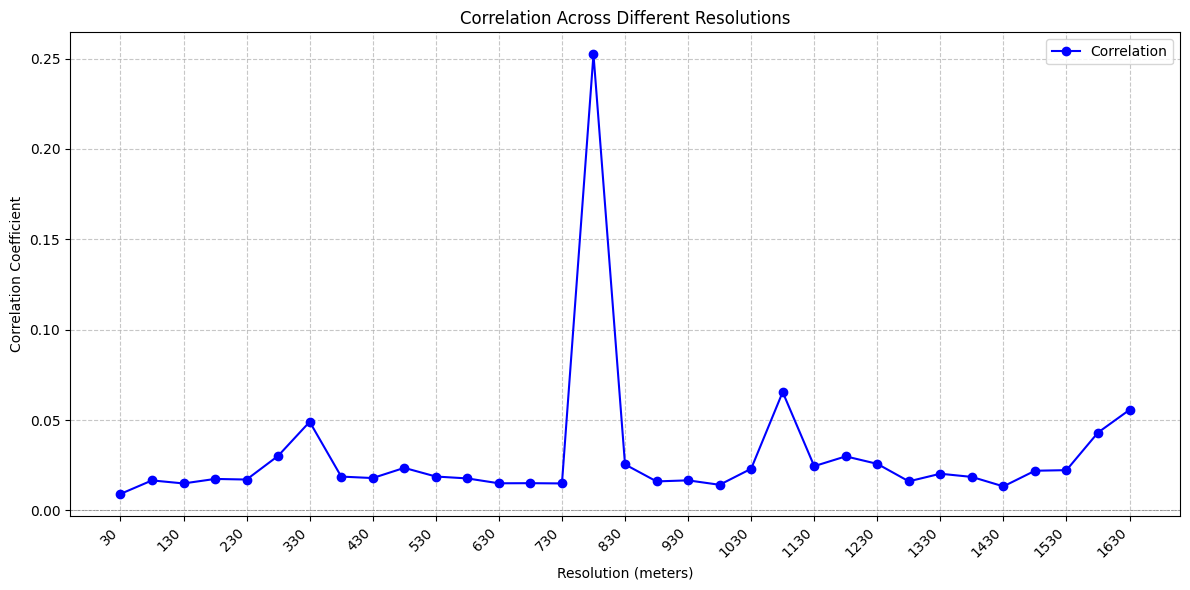

In [ ]:
best_res_b2, max_corr_b2 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b2"), ground_df,32618,"b2")
# 380
# rf780


Processing: b3_res30.tif
Feature importance improved: 0.0104

Processing: b3_res80.tif
Feature importance improved: 0.0180

Processing: b3_res130.tif
Feature importance improved: 0.0220

Processing: b3_res280.tif
Feature importance improved: 0.0546

Processing: b3_res780.tif
Feature importance improved: 0.1934

Best feature importance found:
Resolution: b3_res780.tif
Feature Importance: 0.1934


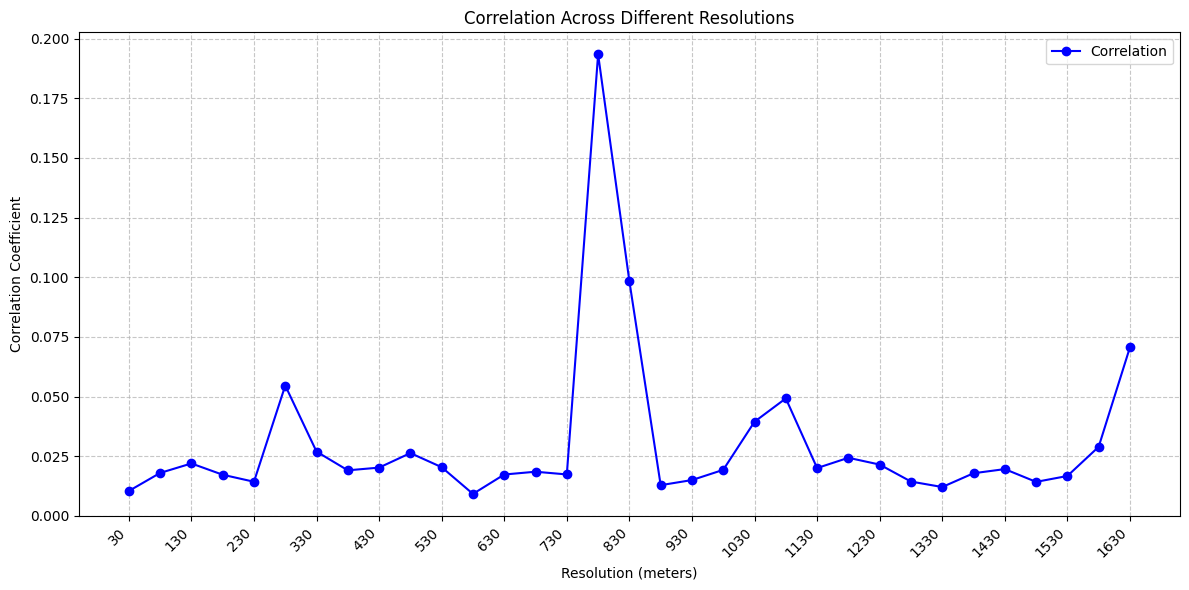

In [ ]:
best_res_b3, max_corr_b3 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b3"), ground_df,32618,"b3")
# 380
# rf780


Processing: b4_res30.tif
Feature importance improved: 0.0114

Processing: b4_res80.tif
Feature importance improved: 0.0253

Processing: b4_res280.tif
Feature importance improved: 0.0268

Processing: b4_res330.tif
Feature importance improved: 0.0413

Processing: b4_res780.tif
Feature importance improved: 0.2645

Best feature importance found:
Resolution: b4_res780.tif
Feature Importance: 0.2645


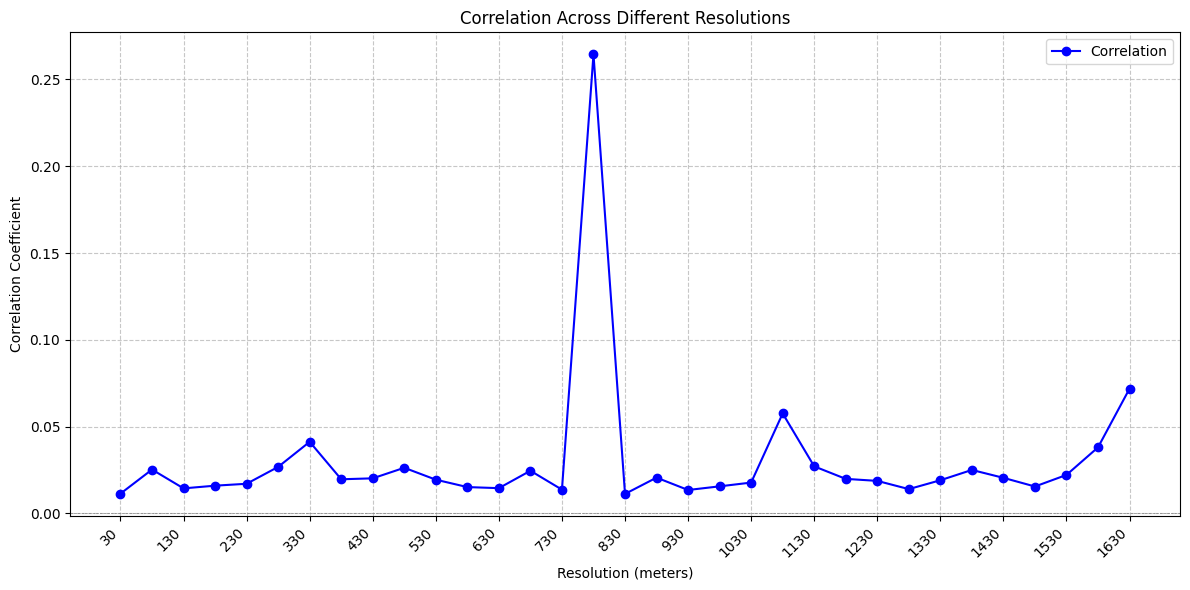

In [ ]:
best_res_b4, max_corr_b4 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b4"), ground_df,32618,"b4")
# 380
# rf780


Processing: b5_res30.tif
Feature importance improved: 0.0130

Processing: b5_res80.tif
Feature importance improved: 0.0161

Processing: b5_res130.tif
Feature importance improved: 0.0237

Processing: b5_res280.tif
Feature importance improved: 0.0510

Processing: b5_res730.tif
Feature importance improved: 0.0805

Processing: b5_res780.tif
Feature importance improved: 0.2214

Best feature importance found:
Resolution: b5_res780.tif
Feature Importance: 0.2214


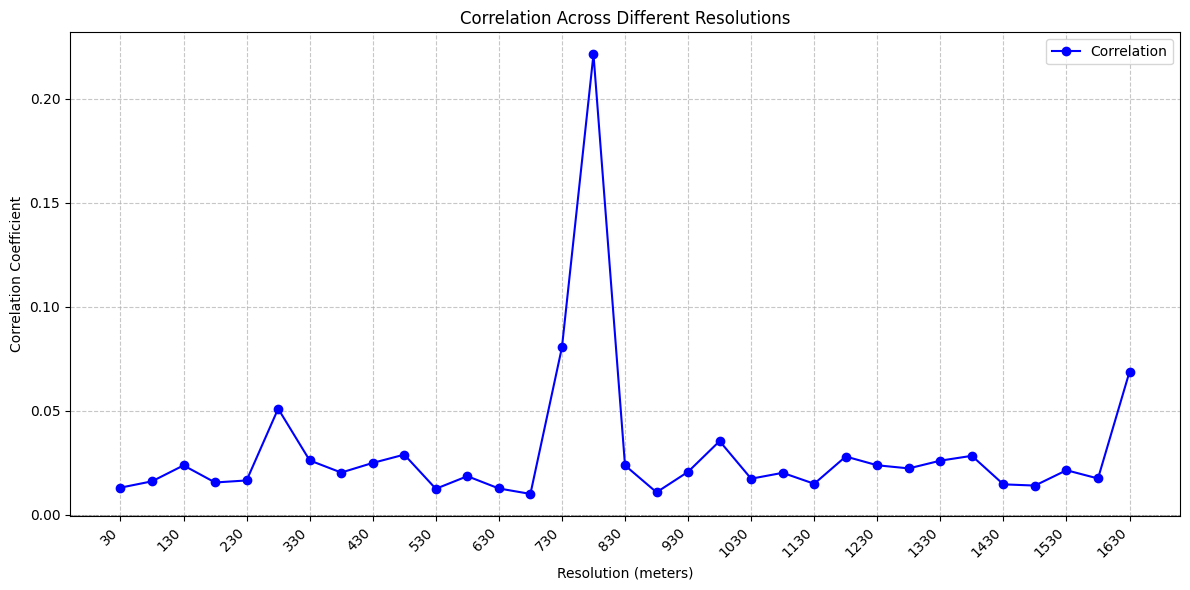

In [ ]:
best_res_b5, max_corr_b5 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b5"), ground_df,32618,"b5")
# 330
# rf780


Processing: b6_res30.tif
Feature importance improved: 0.0184

Processing: b6_res130.tif
Feature importance improved: 0.0253

Processing: b6_res230.tif
Feature importance improved: 0.0266

Processing: b6_res280.tif
Feature importance improved: 0.0398

Processing: b6_res330.tif
Feature importance improved: 0.0488

Processing: b6_res380.tif
Feature importance improved: 0.1065

Best feature importance found:
Resolution: b6_res380.tif
Feature Importance: 0.1065


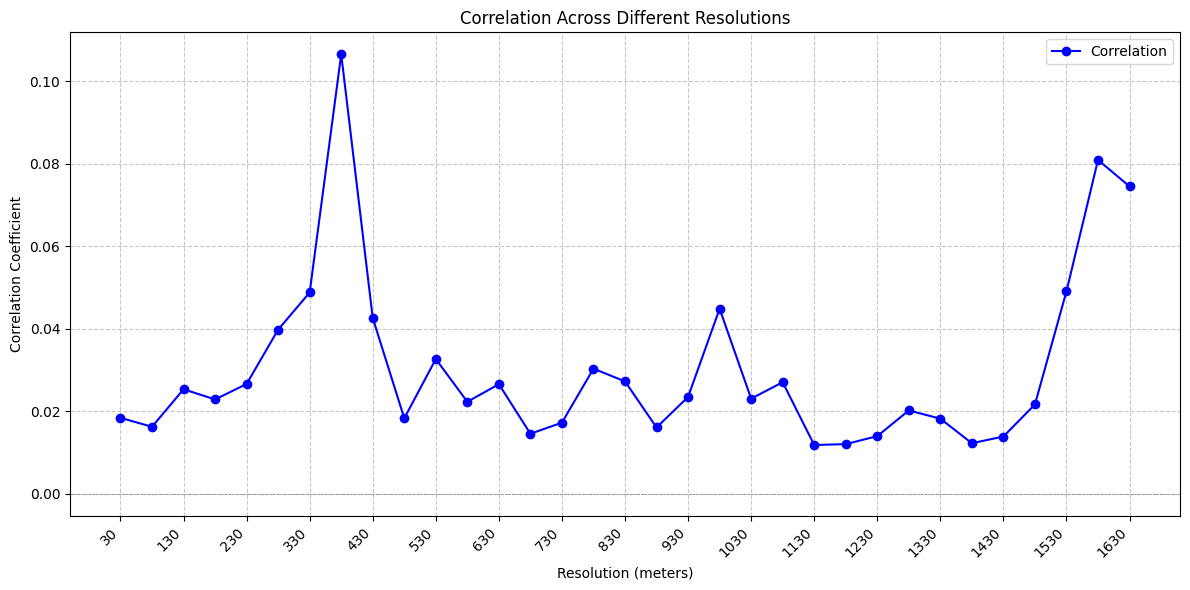

In [ ]:
best_res_b6, max_corr_b6 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b6"), ground_df,32618,"b6")
# 330
# rf380


Processing: b7_res30.tif
Feature importance improved: 0.0206

Processing: b7_res130.tif
Feature importance improved: 0.0256

Processing: b7_res180.tif
Feature importance improved: 0.0685

Processing: b7_res480.tif
Feature importance improved: 0.1047

Best feature importance found:
Resolution: b7_res480.tif
Feature Importance: 0.1047


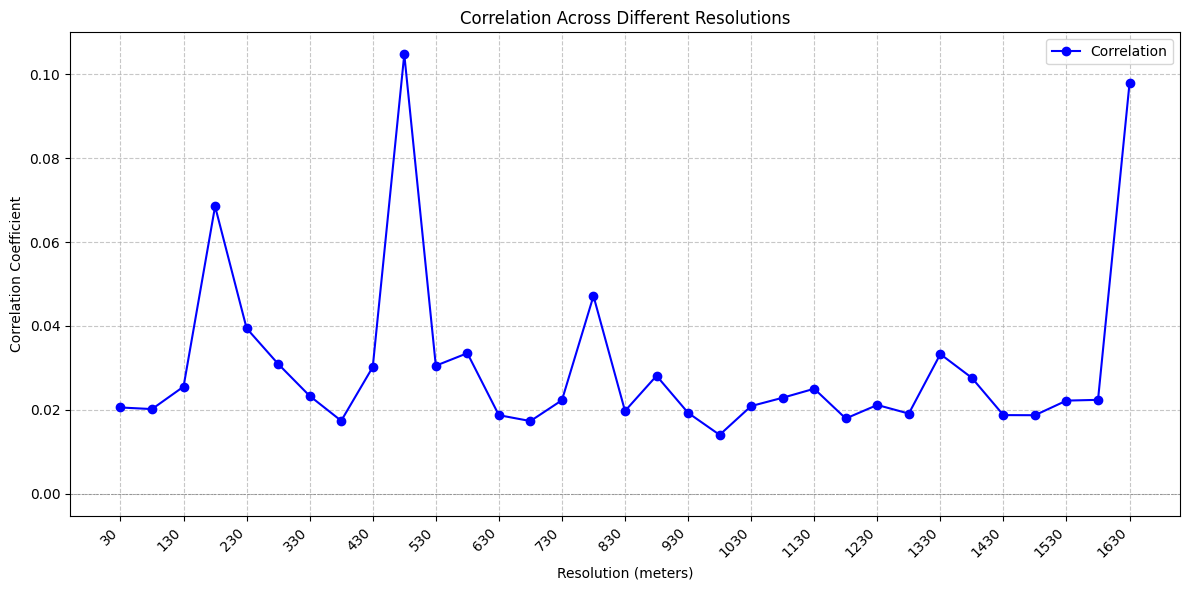

In [ ]:
best_res_b7, max_corr_b7 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b7"), ground_df,32618,"b7")
# 330
# rf480


Processing: b8_res30.tif
Feature importance improved: 0.0237

Processing: b8_res130.tif
Feature importance improved: 0.0270

Processing: b8_res180.tif
Feature importance improved: 0.0468

Processing: b8_res230.tif
Feature importance improved: 0.0581

Processing: b8_res480.tif
Feature importance improved: 0.0608

Processing: b8_res780.tif
Feature importance improved: 0.0876

Best feature importance found:
Resolution: b8_res780.tif
Feature Importance: 0.0876


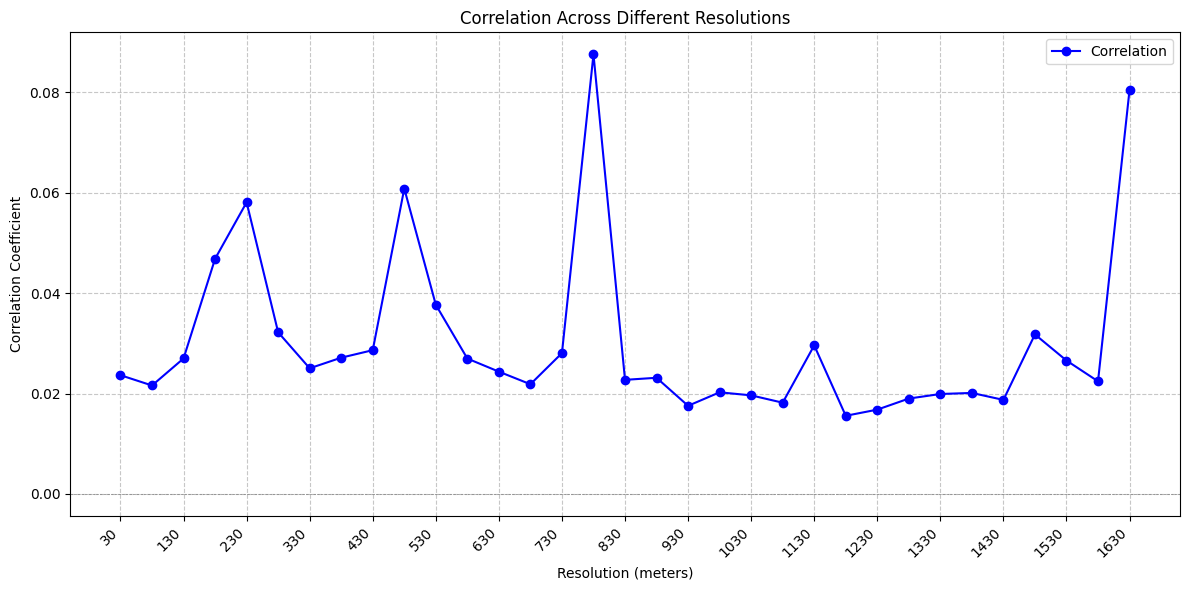

In [ ]:
best_res_b8, max_corr_b8 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b8"), ground_df,32618,"b8")
# 330
# rf780


Processing: b8a_res30.tif
Feature importance improved: 0.0272

Processing: b8a_res180.tif
Feature importance improved: 0.0513

Processing: b8a_res230.tif
Feature importance improved: 0.0576

Processing: b8a_res780.tif
Feature importance improved: 0.0768

Best feature importance found:
Resolution: b8a_res780.tif
Feature Importance: 0.0768


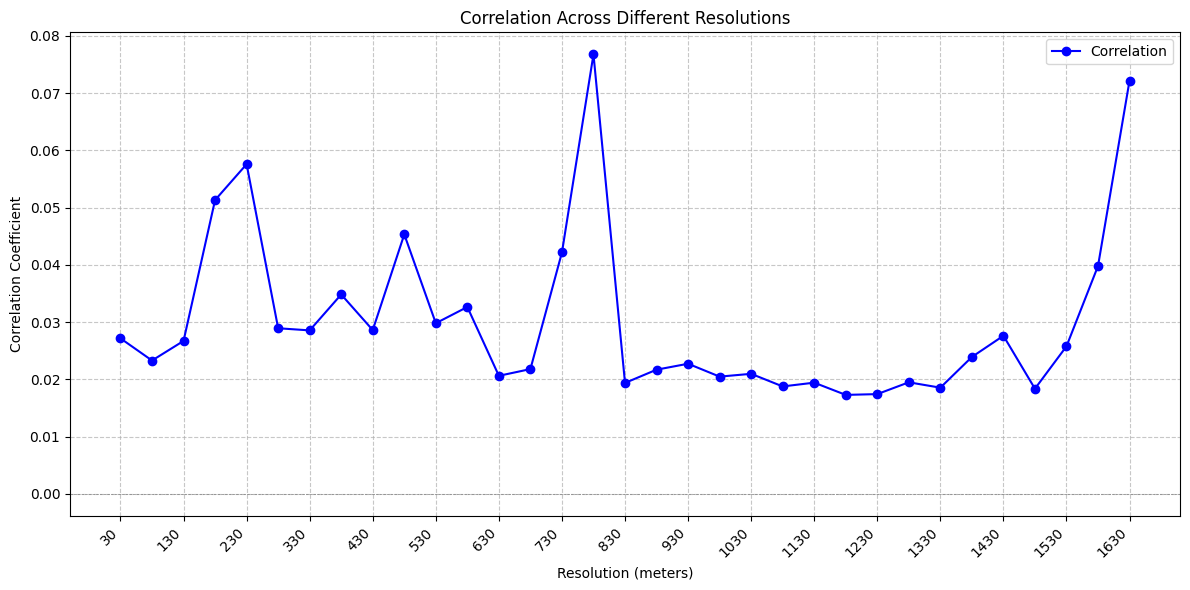

In [ ]:
best_res_b8a, max_corr_b8a = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b8a"), ground_df,32618,"b8a")
# 330
# rf780


Processing: b9_res30.tif
Feature importance improved: 0.0211

Processing: b9_res80.tif
Feature importance improved: 0.0272

Processing: b9_res130.tif
Feature importance improved: 0.0299

Processing: b9_res230.tif
Feature importance improved: 0.0583

Processing: b9_res330.tif
Feature importance improved: 0.0600

Processing: b9_res730.tif
Feature importance improved: 0.0879

Best feature importance found:
Resolution: b9_res730.tif
Feature Importance: 0.0879


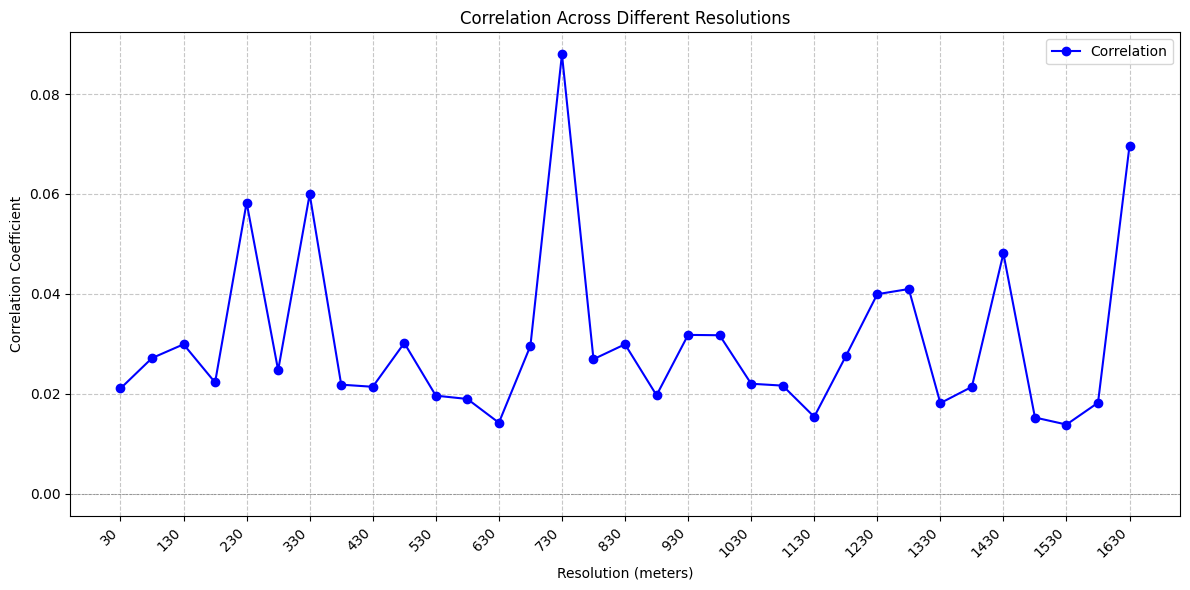

In [ ]:
best_res_b9, max_corr_b9 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b9"), ground_df,32618,"b9")
# 530
# rf730


Processing: b10_res30.tif
Feature importance improved: 0.0171

Processing: b10_res130.tif
Feature importance improved: 0.0210

Processing: b10_res180.tif
Feature importance improved: 0.0263

Processing: b10_res280.tif
Feature importance improved: 0.0304

Processing: b10_res380.tif
Feature importance improved: 0.0602

Processing: b10_res1630.tif
Feature importance improved: 0.1462

Best feature importance found:
Resolution: b10_res1630.tif
Feature Importance: 0.1462


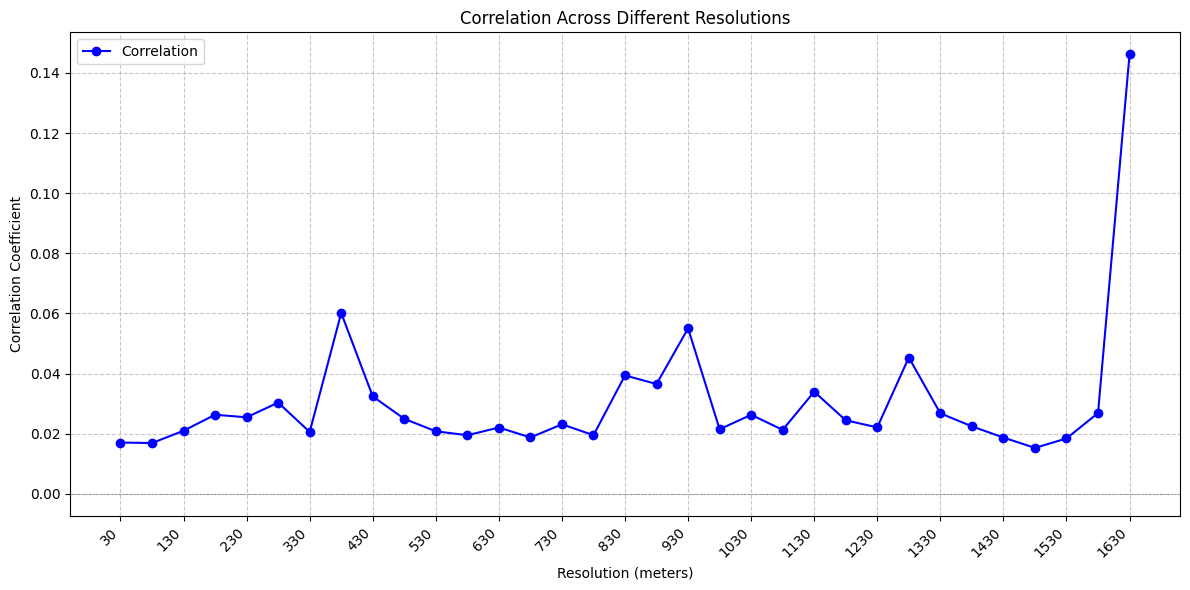

In [ ]:
best_res_b10, max_corr_b10 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b10"), ground_df,32618,"b10")
# 1480
# rf1630


Processing: b11_res30.tif
Feature importance improved: 0.0147

Processing: b11_res80.tif
Feature importance improved: 0.0173

Processing: b11_res130.tif
Feature importance improved: 0.0269

Processing: b11_res280.tif
Feature importance improved: 0.1022

Processing: b11_res880.tif
Feature importance improved: 0.1378

Best feature importance found:
Resolution: b11_res880.tif
Feature Importance: 0.1378


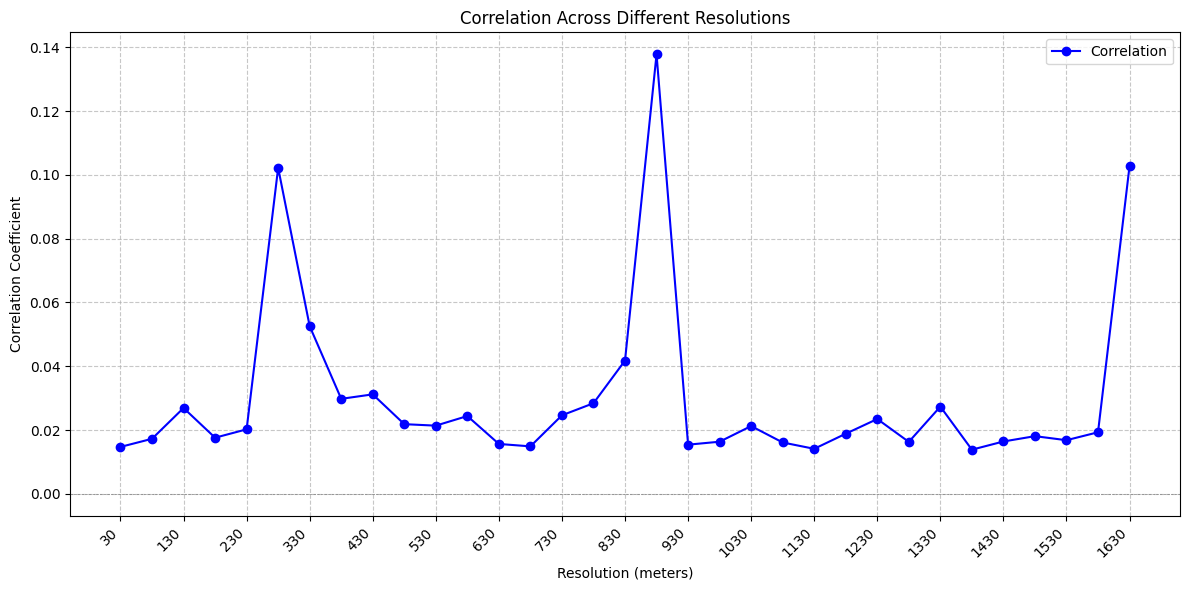

In [ ]:
best_res_b11, max_corr_b11 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b11"), ground_df,32618,"b11")
# 330
# rf880


Processing: b12_res30.tif
Feature importance improved: 0.0137

Processing: b12_res80.tif
Feature importance improved: 0.0155

Processing: b12_res180.tif
Feature importance improved: 0.0159

Processing: b12_res230.tif
Feature importance improved: 0.0249

Processing: b12_res280.tif
Feature importance improved: 0.0428

Processing: b12_res780.tif
Feature importance improved: 0.2750

Best feature importance found:
Resolution: b12_res780.tif
Feature Importance: 0.2750


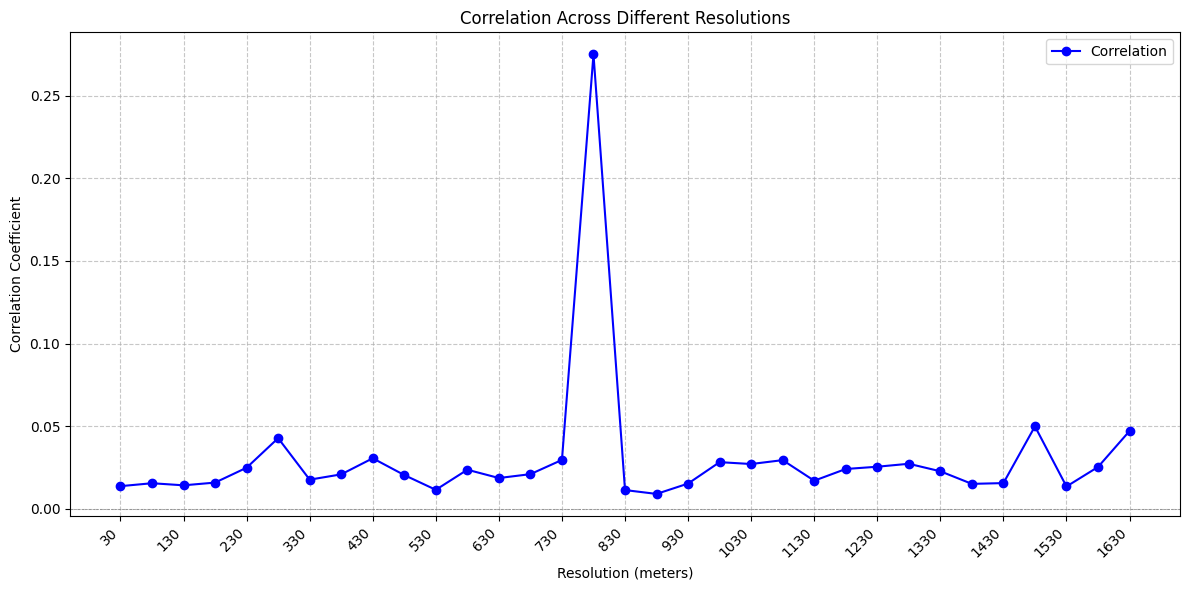

In [ ]:
best_res_b12, max_corr_b12 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"b12"), ground_df,32618,"b12")
# 330
# rf780


Processing: dem_res30.tif
Feature importance improved: 0.0209

Processing: dem_res80.tif
Feature importance improved: 0.0261

Processing: dem_res480.tif
Feature importance improved: 0.0323

Processing: dem_res530.tif
Feature importance improved: 0.0364

Processing: dem_res580.tif
Feature importance improved: 0.1430

Best feature importance found:
Resolution: dem_res580.tif
Feature Importance: 0.1430


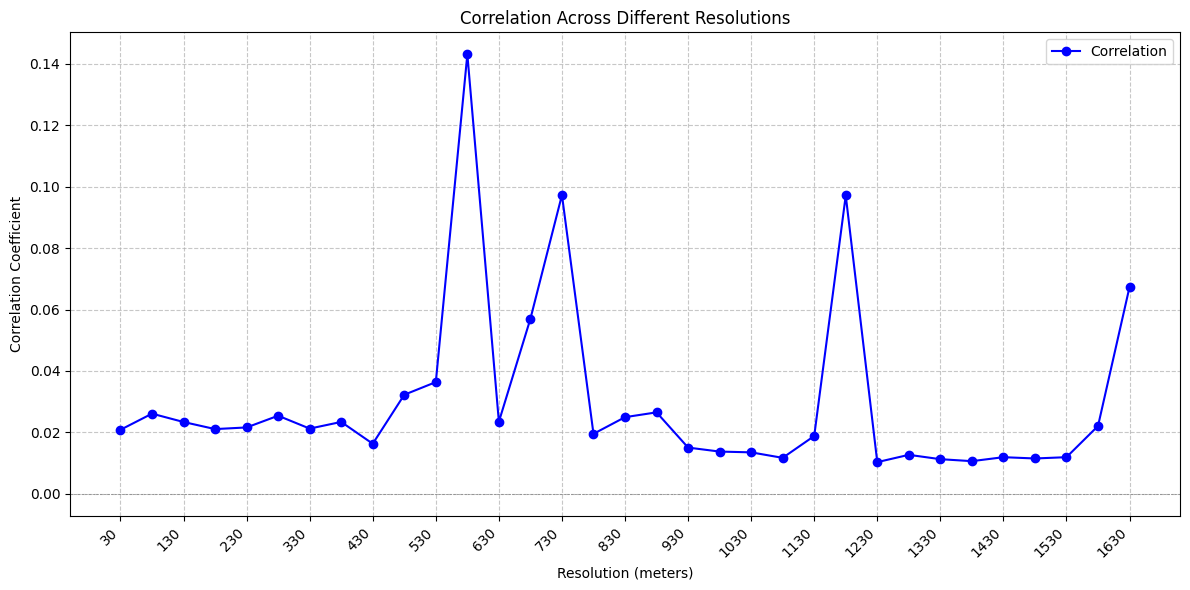

In [ ]:
best_res_dem, max_corr_dem = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"dem"), ground_df,32618,"dem")
# 930
# rf580


Processing: forest_hight_res30.tif
Feature importance improved: 0.0125

Processing: forest_hight_res80.tif
Feature importance improved: 0.0242

Processing: forest_hight_res130.tif
Feature importance improved: 0.0363

Processing: forest_hight_res180.tif
Feature importance improved: 0.1989

Best feature importance found:
Resolution: forest_hight_res180.tif
Feature Importance: 0.1989


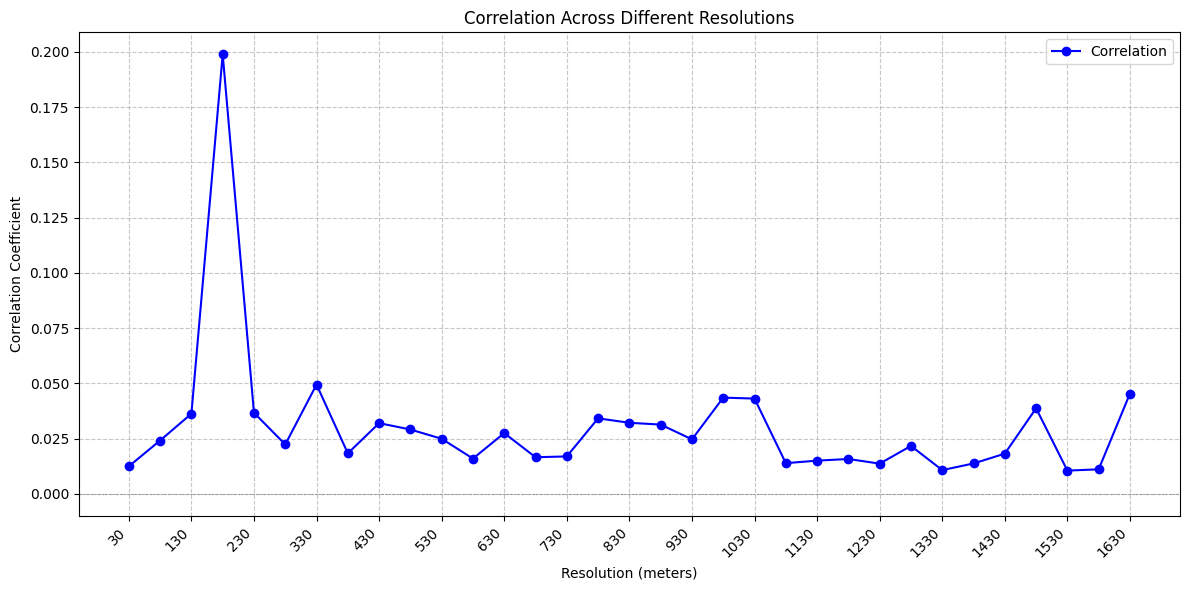

In [ ]:
best_res_forest_hight, max_corr_forest_hight = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"forest_hight"), ground_df,32618,"forest_hight")
# 330
# rf180


Processing: greeness_res30.tif
Feature importance improved: 0.0240

Processing: greeness_res130.tif
Feature importance improved: 0.0501

Processing: greeness_res580.tif
Feature importance improved: 0.0683

Processing: greeness_res1080.tif
Feature importance improved: 0.0731

Processing: greeness_res1630.tif
Feature importance improved: 0.1299

Best feature importance found:
Resolution: greeness_res1630.tif
Feature Importance: 0.1299


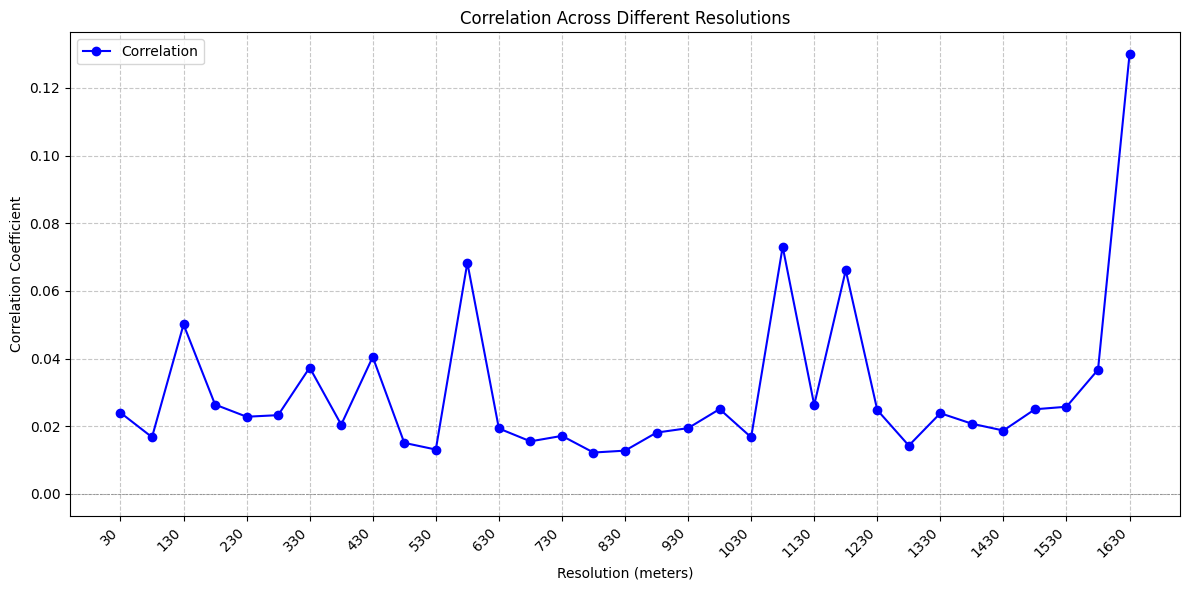

In [ ]:
best_res_greeness, max_corr_greeness = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"greeness"), ground_df,32618,"greeness")
# 1480
# rf1630


Processing: impervious_res30.tif
Feature importance improved: 0.0095

Processing: impervious_res80.tif
Feature importance improved: 0.0264

Processing: impervious_res1080.tif
Feature importance improved: 0.0347

Processing: impervious_res1230.tif
Feature importance improved: 0.0469

Processing: impervious_res1530.tif
Feature importance improved: 0.2076

Best feature importance found:
Resolution: impervious_res1530.tif
Feature Importance: 0.2076


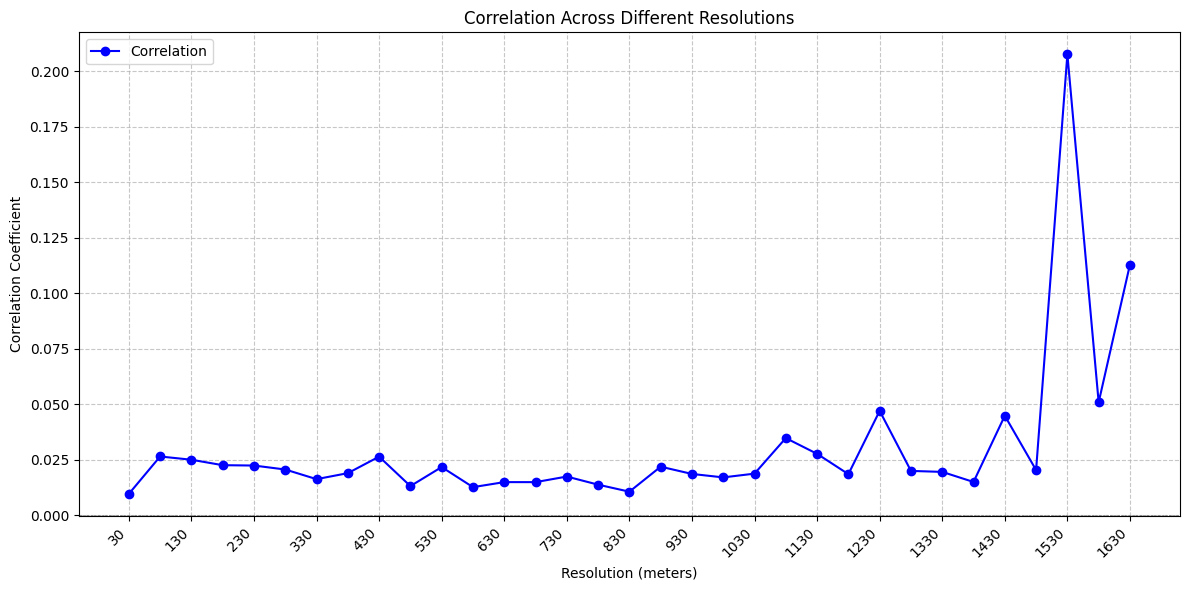

In [ ]:
best_res_impervious, max_corr_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"impervious"), ground_df,32618,"impervious")
# 1480
# rf1530


Processing: landsat_lst_res30.tif
Feature importance improved: 0.0594

Processing: landsat_lst_res1330.tif
Feature importance improved: 0.2170

Best feature importance found:
Resolution: landsat_lst_res1330.tif
Feature Importance: 0.2170


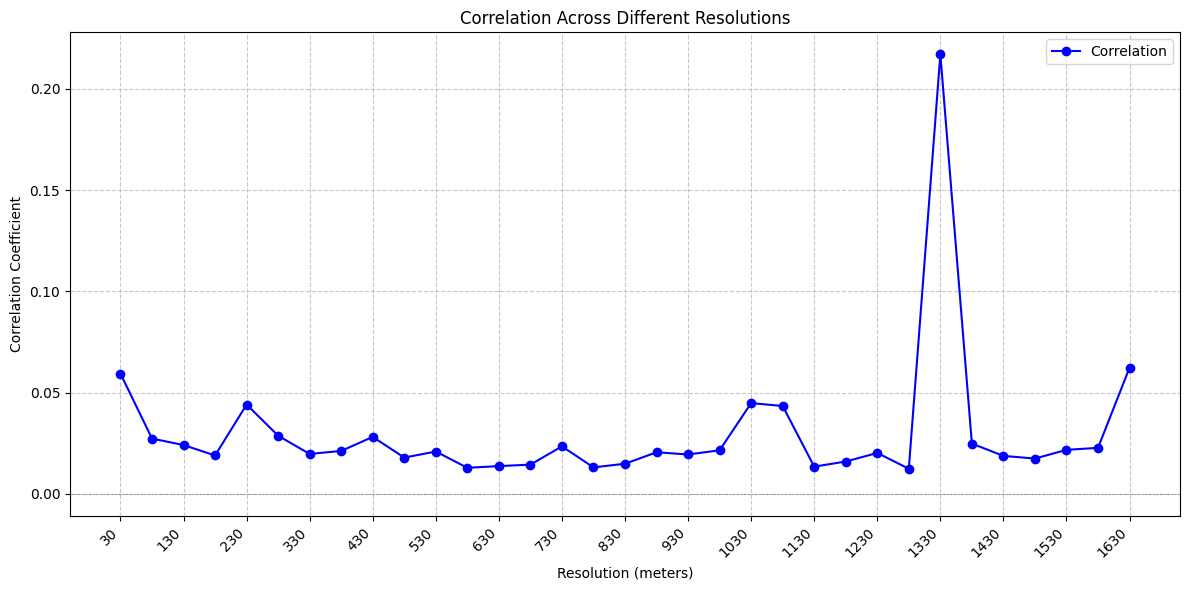

In [ ]:
best_res_landsat_lst, max_corr_landsat_lst = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"landsat_lst"), ground_df,32618,"landsat_lst")
# 880
# rf1330


Processing: mndwi_res30.tif
Feature importance improved: 0.0282

Processing: mndwi_res80.tif
Feature importance improved: 0.0419

Processing: mndwi_res180.tif
Feature importance improved: 0.0445

Processing: mndwi_res530.tif
Feature importance improved: 0.0992

Best feature importance found:
Resolution: mndwi_res530.tif
Feature Importance: 0.0992


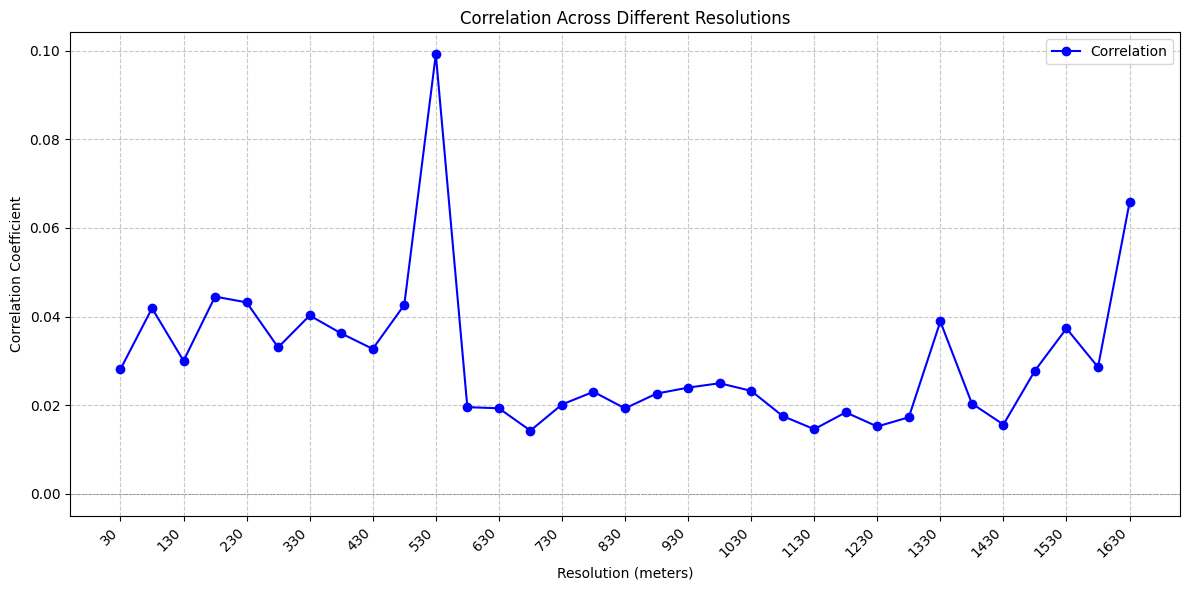

In [ ]:
best_res_mndwi, max_corr_mndwi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"mndwi"), ground_df,32618,"mndwi")
# 930
# rf530


Processing: ndbi_res30.tif
Feature importance improved: 0.0200

Processing: ndbi_res80.tif
Feature importance improved: 0.0374

Processing: ndbi_res280.tif
Feature importance improved: 0.0452

Processing: ndbi_res1330.tif
Feature importance improved: 0.1715

Best feature importance found:
Resolution: ndbi_res1330.tif
Feature Importance: 0.1715


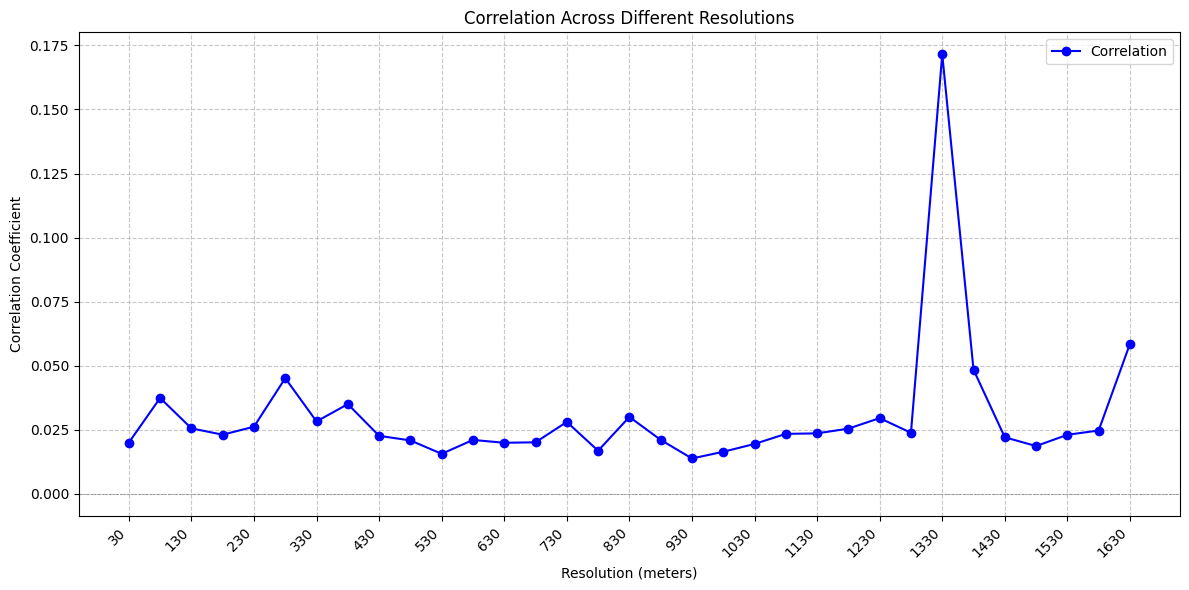

In [ ]:
best_res_ndbi, max_corr_ndbi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndbi"), ground_df,32618,"ndbi")
# 1280
# rf1330


Processing: ndli_res30.tif
Feature importance improved: 0.0481

Processing: ndli_res980.tif
Feature importance improved: 0.0623

Processing: ndli_res1330.tif
Feature importance improved: 0.1068

Best feature importance found:
Resolution: ndli_res1330.tif
Feature Importance: 0.1068


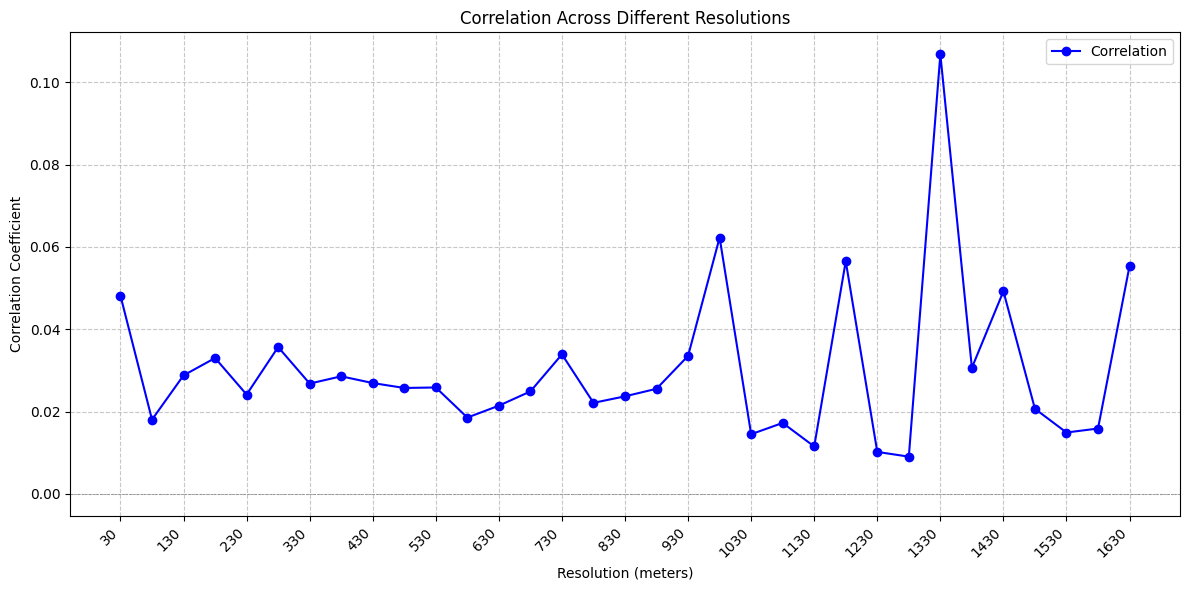

In [ ]:
best_res_ndli, max_corr_ndli = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndli"), ground_df,32618,"ndli")
# 30
# rf1330


Processing: ndvi_res30.tif
Feature importance improved: 0.0442

Processing: ndvi_res980.tif
Feature importance improved: 0.0695

Processing: ndvi_res1330.tif
Feature importance improved: 0.1090

Best feature importance found:
Resolution: ndvi_res1330.tif
Feature Importance: 0.1090


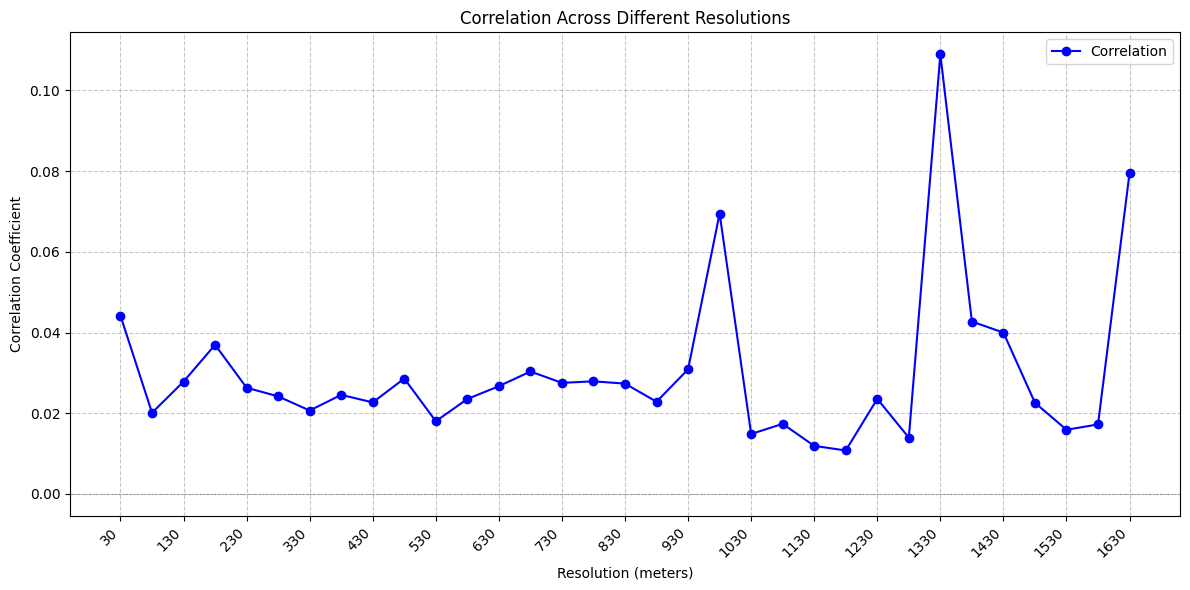

In [ ]:
best_res_ndvi, max_corr_ndvi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndvi"), ground_df,32618,"ndvi")
# 30
# rf1330


Processing: ndwi_res30.tif
Feature importance improved: 0.0392

Processing: ndwi_res130.tif
Feature importance improved: 0.0792

Processing: ndwi_res1630.tif
Feature importance improved: 0.1010

Best feature importance found:
Resolution: ndwi_res1630.tif
Feature Importance: 0.1010


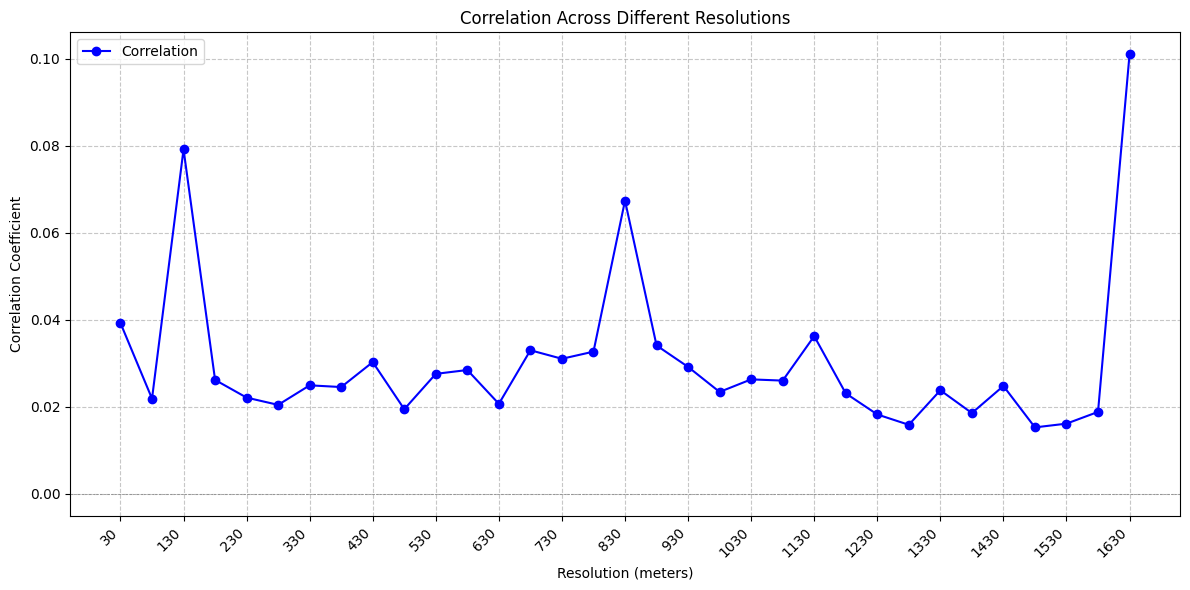

In [ ]:
best_res_ndwi, max_corr_ndwi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndwi"), ground_df,32618,"ndwi")
# 30
# rf1630


Processing: surface_albedo_res30.tif
Feature importance improved: 0.0146

Processing: surface_albedo_res80.tif
Feature importance improved: 0.0183

Processing: surface_albedo_res130.tif
Feature importance improved: 0.0199

Processing: surface_albedo_res180.tif
Feature importance improved: 0.0240

Processing: surface_albedo_res230.tif
Feature importance improved: 0.0270

Processing: surface_albedo_res280.tif
Feature importance improved: 0.0334

Processing: surface_albedo_res330.tif
Feature importance improved: 0.0554

Processing: surface_albedo_res880.tif
Feature importance improved: 0.2629

Best feature importance found:
Resolution: surface_albedo_res880.tif
Feature Importance: 0.2629


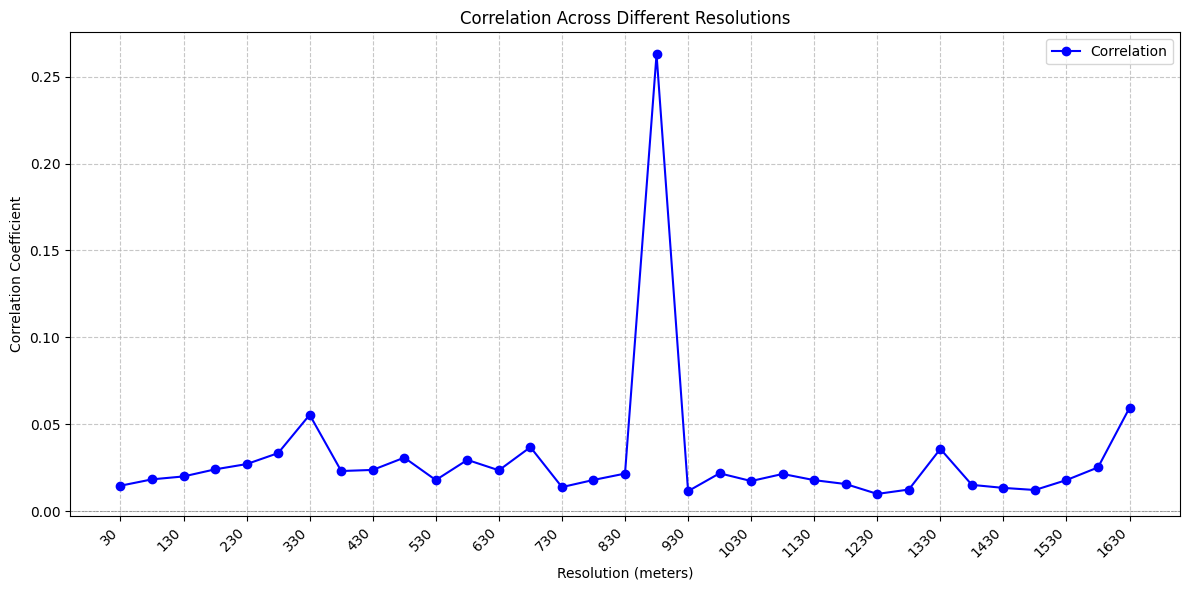

In [ ]:
best_res_surface_albedo, max_corr_surface_albedo = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"surface_albedo"), ground_df,32618,"surface_albedo")
# 380
# rf880

### Optimal Resolution for Social Indicator


Processing: anh_res30.tif
Feature importance improved: 0.0174

Processing: anh_res80.tif
Feature importance improved: 0.0273

Processing: anh_res230.tif
Feature importance improved: 0.0326

Processing: anh_res1130.tif
Feature importance improved: 0.0389

Processing: anh_res1580.tif
Feature importance improved: 0.2820

Best feature importance found:
Resolution: anh_res1580.tif
Feature Importance: 0.2820


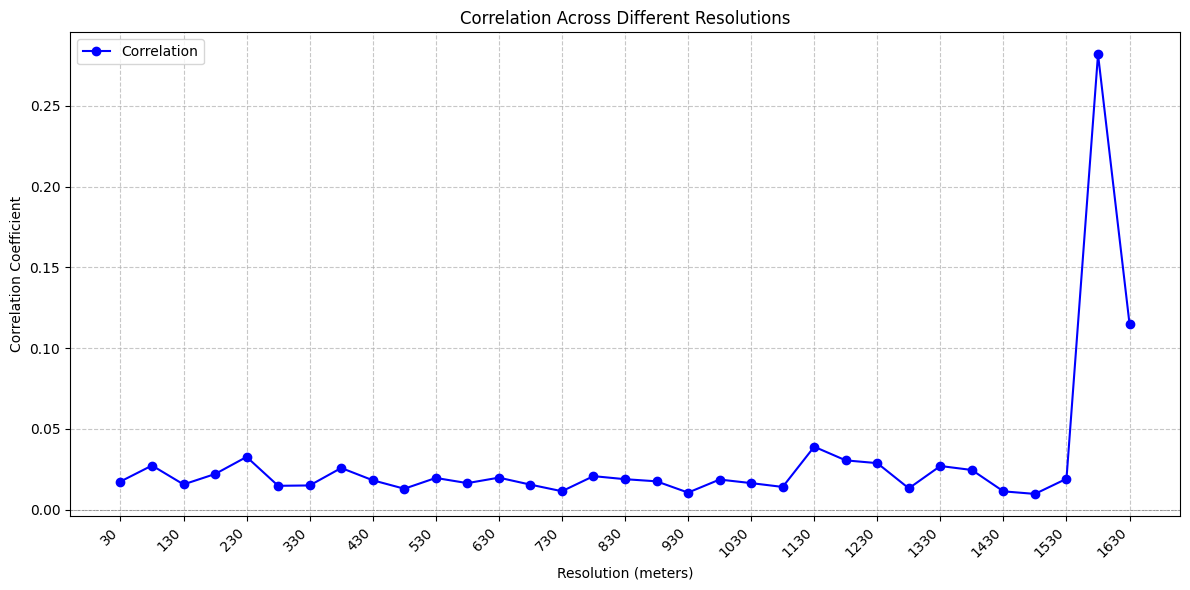

In [ ]:
best_res_anh, max_corr_anh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"anh"), ground_df,32618,"anh")
# 930
# rf1580


Processing: bnh_res30.tif
Feature importance improved: 0.0140

Processing: bnh_res80.tif
Feature importance improved: 0.0173

Processing: bnh_res130.tif
Feature importance improved: 0.0212

Processing: bnh_res530.tif
Feature importance improved: 0.0221

Processing: bnh_res580.tif
Feature importance improved: 0.0340

Processing: bnh_res730.tif
Feature importance improved: 0.0362

Processing: bnh_res980.tif
Feature importance improved: 0.0597

Processing: bnh_res1630.tif
Feature importance improved: 0.3182

Best feature importance found:
Resolution: bnh_res1630.tif
Feature Importance: 0.3182


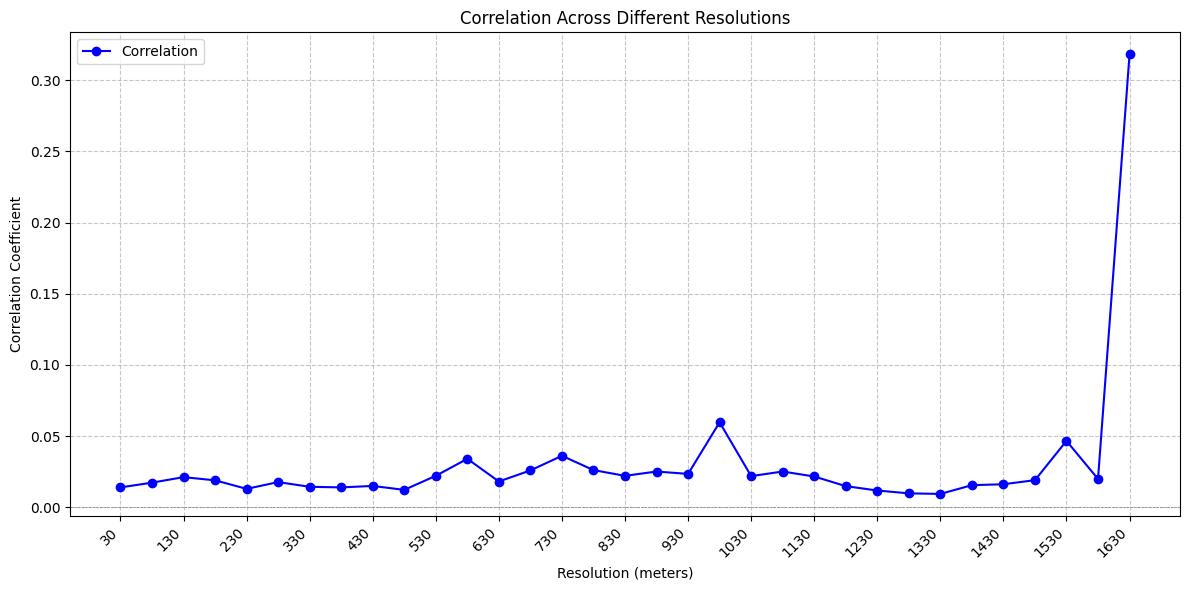

In [ ]:
best_res_bnh, max_corr_bnh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"bnh"), ground_df,32618,"bnh")
# 1480
# rf1630


Processing: hsp1_res30.tif
Feature importance improved: 0.0112

Processing: hsp1_res80.tif
Feature importance improved: 0.0136

Processing: hsp1_res130.tif
Feature importance improved: 0.0140

Processing: hsp1_res180.tif
Feature importance improved: 0.0271

Processing: hsp1_res930.tif
Feature importance improved: 0.0506

Processing: hsp1_res1630.tif
Feature importance improved: 0.3843

Best feature importance found:
Resolution: hsp1_res1630.tif
Feature Importance: 0.3843


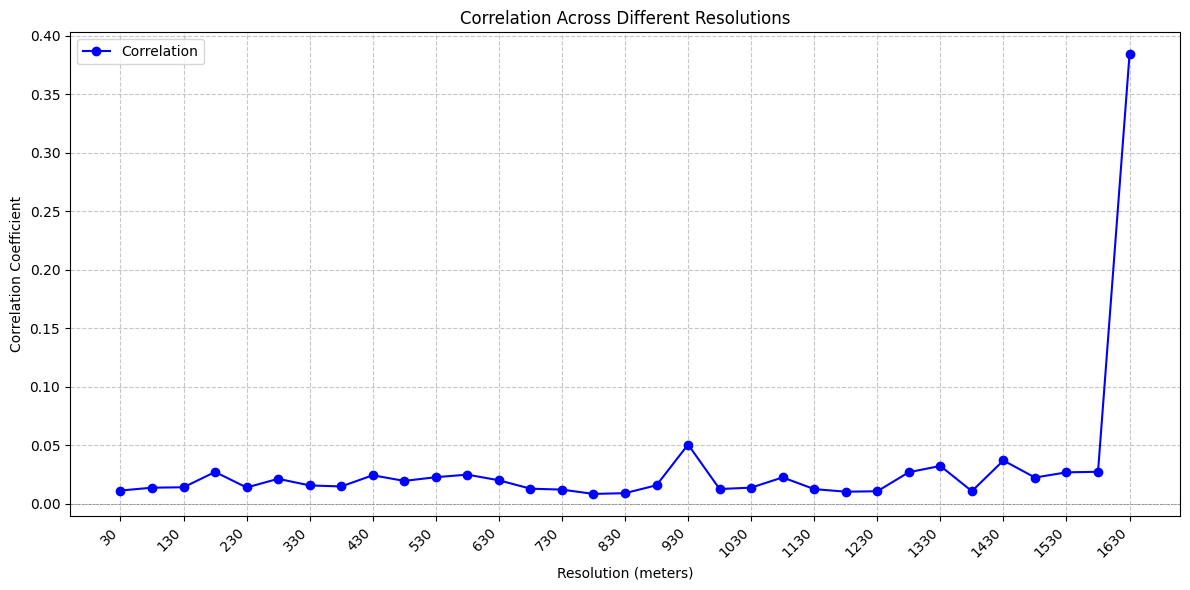

In [ ]:
best_res_hsp1, max_corr_hsp1 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"hsp1"), ground_df,32618,"hsp1")
# 1080
# rf1630


Processing: hunits_res30.tif
Feature importance improved: 0.0150

Processing: hunits_res80.tif
Feature importance improved: 0.0179

Processing: hunits_res180.tif
Feature importance improved: 0.0278

Processing: hunits_res380.tif
Feature importance improved: 0.0304

Processing: hunits_res1280.tif
Feature importance improved: 0.0323

Processing: hunits_res1480.tif
Feature importance improved: 0.0924

Processing: hunits_res1580.tif
Feature importance improved: 0.1977

Best feature importance found:
Resolution: hunits_res1580.tif
Feature Importance: 0.1977


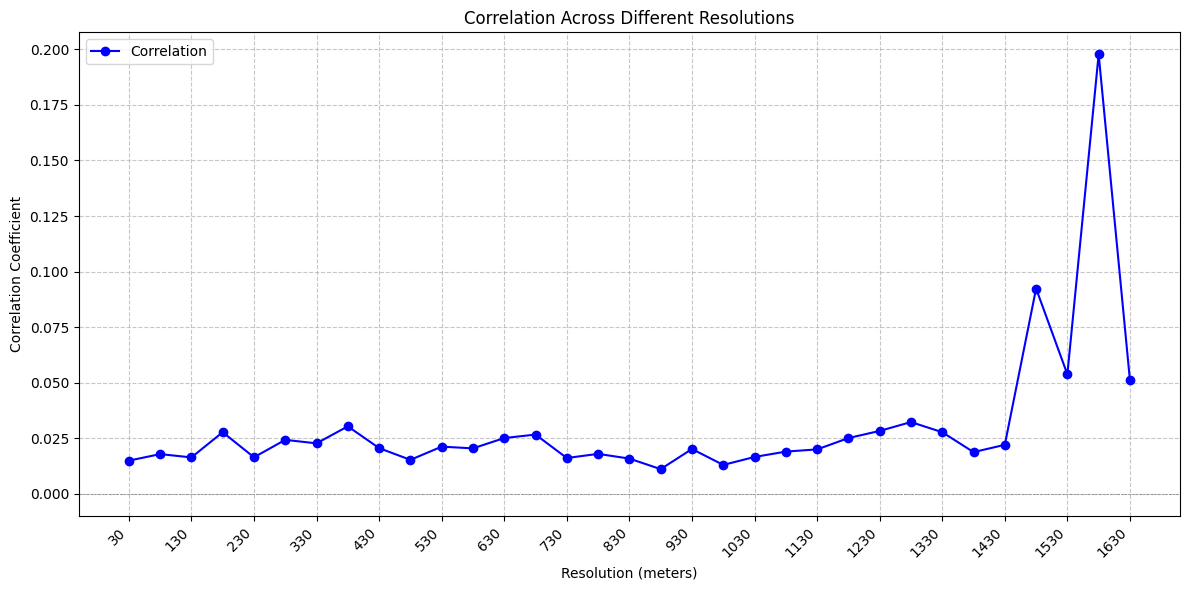

In [ ]:
best_res_hunits, max_corr_hunits = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"hunits"), ground_df,32618,"hunits")
# 1480
# rf1580


Processing: mean_b_yea_res30.tif
Feature importance improved: 0.0398

Processing: mean_b_yea_res1380.tif
Feature importance improved: 0.0955

Processing: mean_b_yea_res1630.tif
Feature importance improved: 0.1330

Best feature importance found:
Resolution: mean_b_yea_res1630.tif
Feature Importance: 0.1330


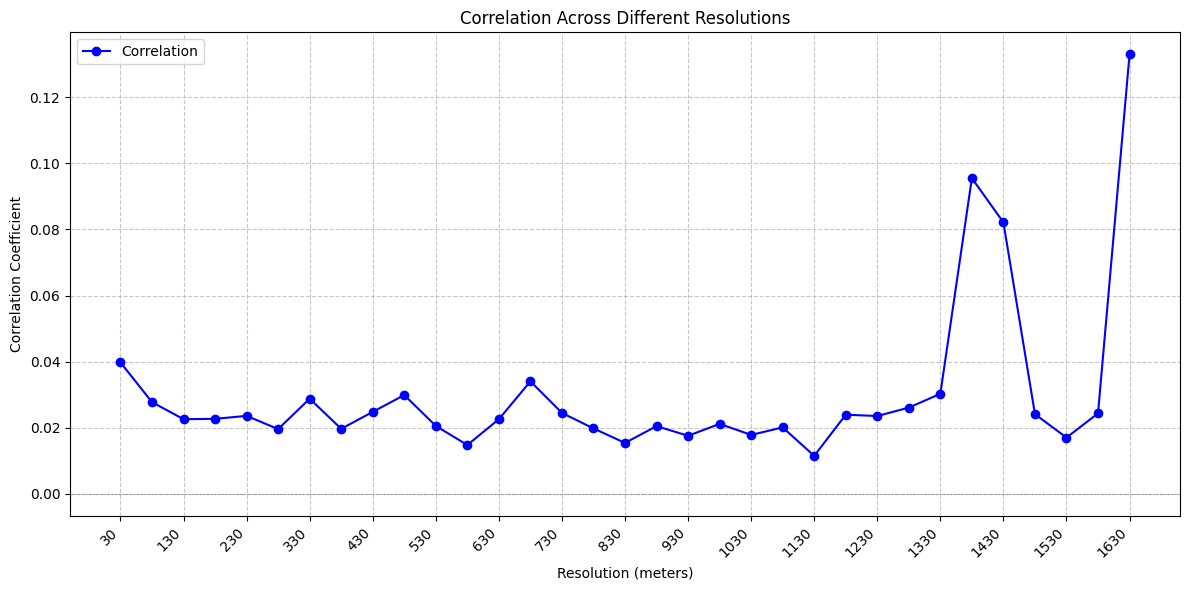

In [ ]:
best_res_mean_b_yea, max_corr_mean_b_yea = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"mean_b_yea"), ground_df,32618,"mean_b_yea")
# 180
# rf1630


Processing: mean_c_occ_res30.tif
Feature importance improved: 0.0940

Processing: mean_c_occ_res1630.tif
Feature importance improved: 0.1606

Best feature importance found:
Resolution: mean_c_occ_res1630.tif
Feature Importance: 0.1606


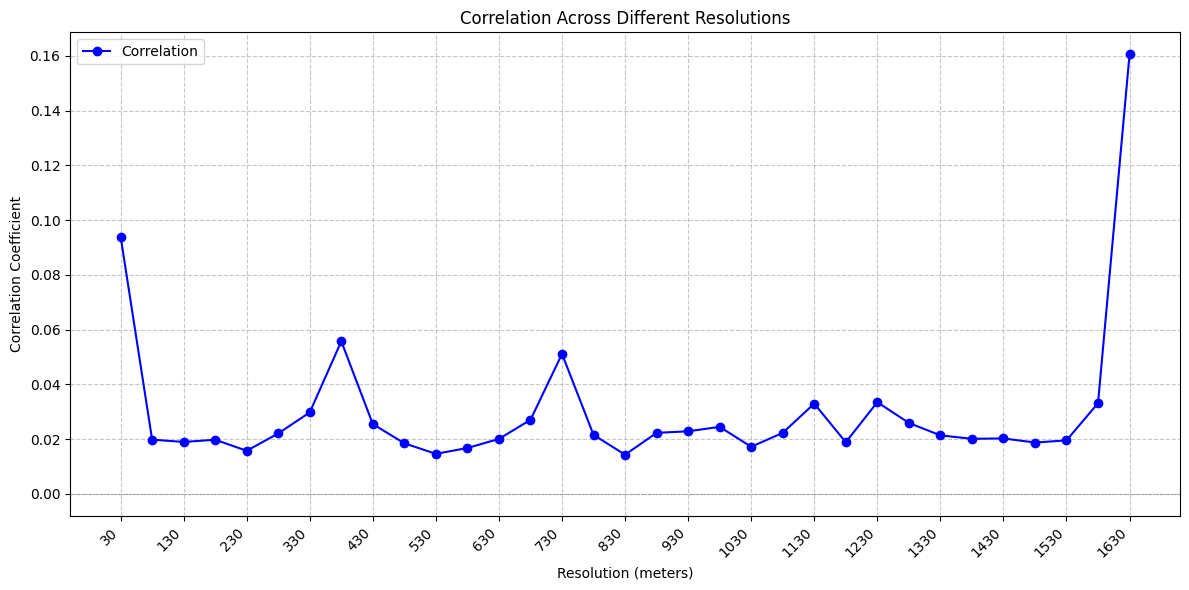

In [ ]:
best_res_mean_c_occ, max_corr_mean_c_occ = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"mean_c_occ"), ground_df,32618,"mean_c_occ")
# 1480
# rf1630


Processing: pop65pl_res30.tif
Feature importance improved: 0.0119

Processing: pop65pl_res80.tif
Feature importance improved: 0.0185

Processing: pop65pl_res130.tif
Feature importance improved: 0.0291

Processing: pop65pl_res330.tif
Feature importance improved: 0.0309

Processing: pop65pl_res380.tif
Feature importance improved: 0.0326

Processing: pop65pl_res1380.tif
Feature importance improved: 0.0461

Processing: pop65pl_res1630.tif
Feature importance improved: 0.3430

Best feature importance found:
Resolution: pop65pl_res1630.tif
Feature Importance: 0.3430


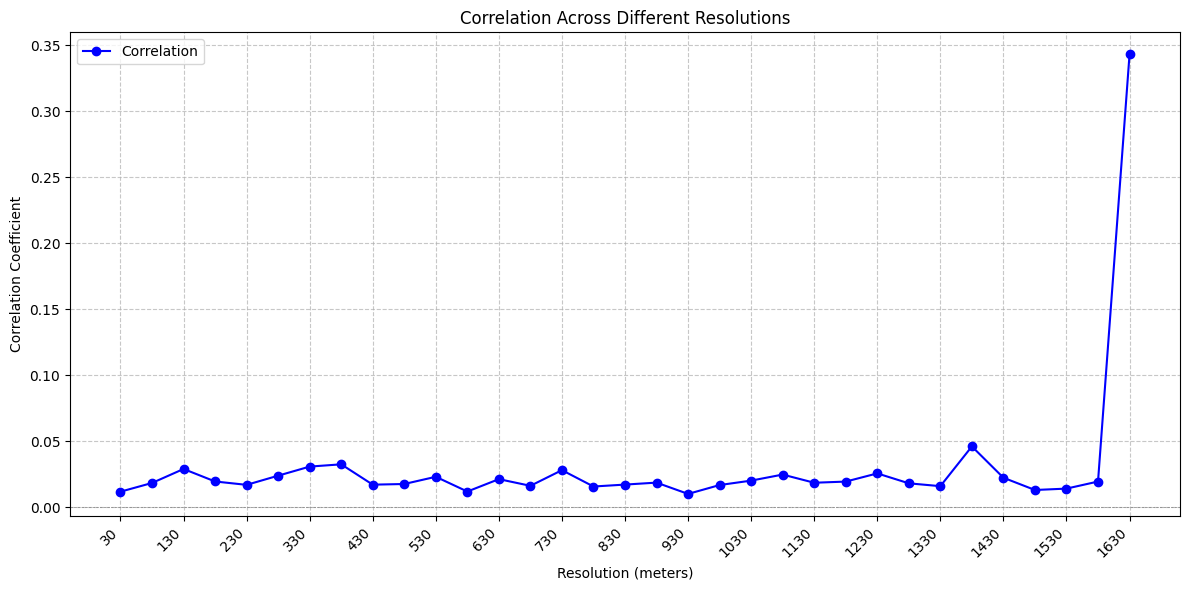

In [ ]:
best_res_pop65pl, max_corr_pop65pl = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"pop65pl"), ground_df,32618,"pop65pl")
# 1480
# rf1630


Processing: twopinh_res30.tif
Feature importance improved: 0.0188

Processing: twopinh_res130.tif
Feature importance improved: 0.0303

Processing: twopinh_res530.tif
Feature importance improved: 0.0315

Processing: twopinh_res930.tif
Feature importance improved: 0.0705

Processing: twopinh_res1430.tif
Feature importance improved: 0.1245

Best feature importance found:
Resolution: twopinh_res1430.tif
Feature Importance: 0.1245


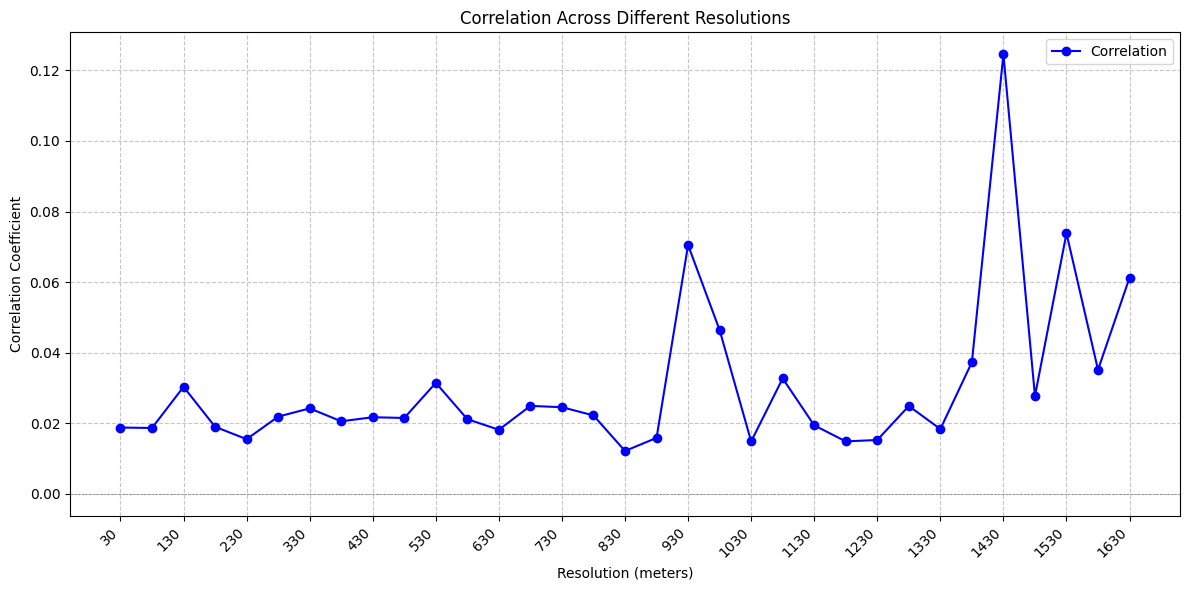

In [ ]:
best_res_twopinh, max_corr_twopinh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"twopinh"), ground_df,32618,"twopinh")
# 1230
# rf1430


Processing: vachus_res30.tif
Feature importance improved: 0.0141

Processing: vachus_res80.tif
Feature importance improved: 0.0158

Processing: vachus_res130.tif
Feature importance improved: 0.0186

Processing: vachus_res230.tif
Feature importance improved: 0.0373

Processing: vachus_res830.tif
Feature importance improved: 0.0537

Processing: vachus_res1030.tif
Feature importance improved: 0.0566

Processing: vachus_res1080.tif
Feature importance improved: 0.2898

Best feature importance found:
Resolution: vachus_res1080.tif
Feature Importance: 0.2898


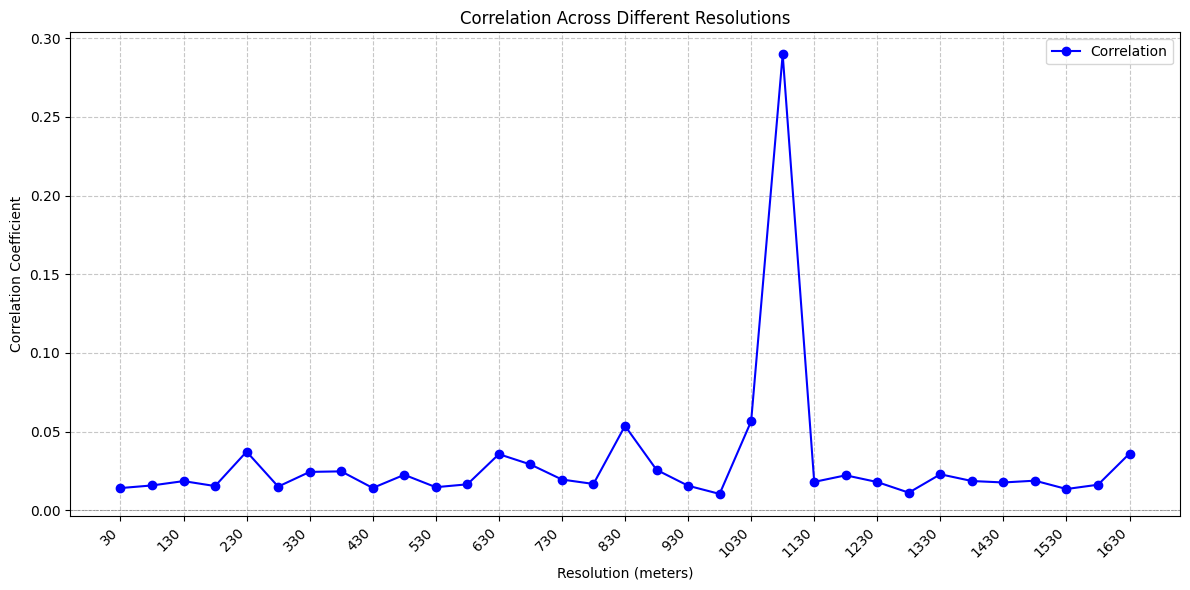

In [ ]:
best_res_vachus, max_corr_vachus = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"vachus"), ground_df,32618,"vachus")
# 180
# rf1080


Processing: wnh_res30.tif
Feature importance improved: 0.0261

Processing: wnh_res80.tif
Feature importance improved: 0.0281

Processing: wnh_res180.tif
Feature importance improved: 0.0344

Processing: wnh_res680.tif
Feature importance improved: 0.0468

Processing: wnh_res1630.tif
Feature importance improved: 0.4108

Best feature importance found:
Resolution: wnh_res1630.tif
Feature Importance: 0.4108


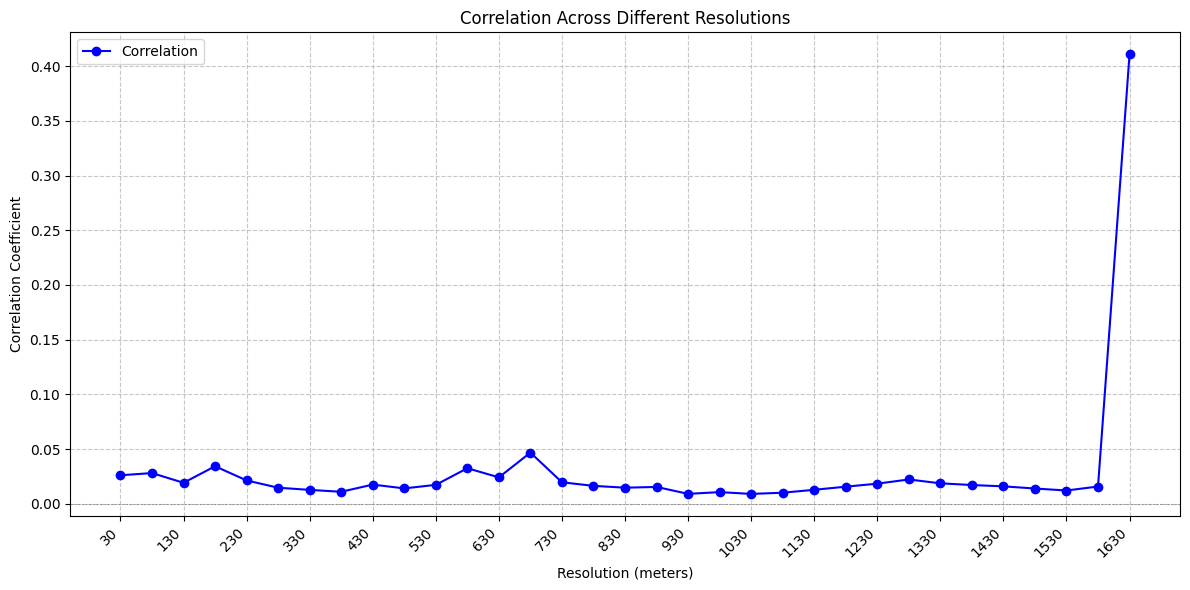

In [ ]:
best_res_wnh, max_corr_wnh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"wnh"), ground_df,32618,"wnh")
# 1480
# rf1630


Processing: build_cove_res30.tif
Feature importance improved: 0.0168

Processing: build_cove_res80.tif
Feature importance improved: 0.0198

Processing: build_cove_res130.tif
Feature importance improved: 0.0222

Processing: build_cove_res180.tif
Feature importance improved: 0.0309

Processing: build_cove_res230.tif
Feature importance improved: 0.0357

Processing: build_cove_res330.tif
Feature importance improved: 0.0425

Processing: build_cove_res680.tif
Feature importance improved: 0.0551

Processing: build_cove_res1280.tif
Feature importance improved: 0.0865

Best feature importance found:
Resolution: build_cove_res1280.tif
Feature Importance: 0.0865


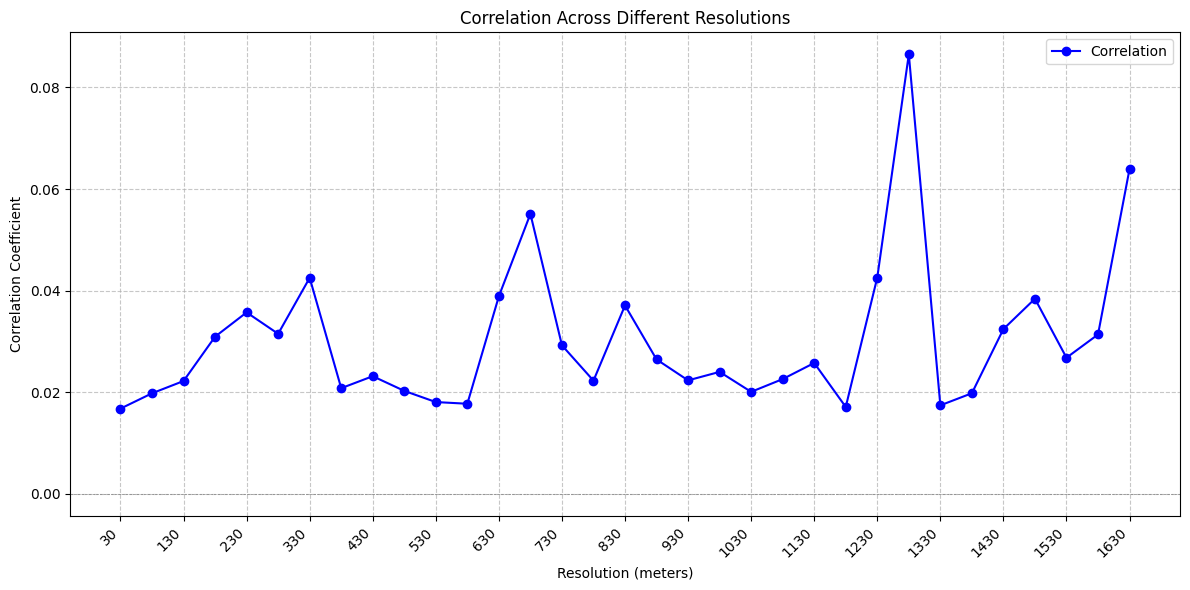

In [ ]:
best_res_build_cove, max_corr_build_cove = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"build_cove"), ground_df,32618,"build_cove")
# 880
# rf1280


Processing: build_dens_res30.tif
Feature importance improved: 0.0441

Processing: build_dens_res480.tif
Feature importance improved: 0.0442

Processing: build_dens_res1630.tif
Feature importance improved: 0.1259

Best feature importance found:
Resolution: build_dens_res1630.tif
Feature Importance: 0.1259


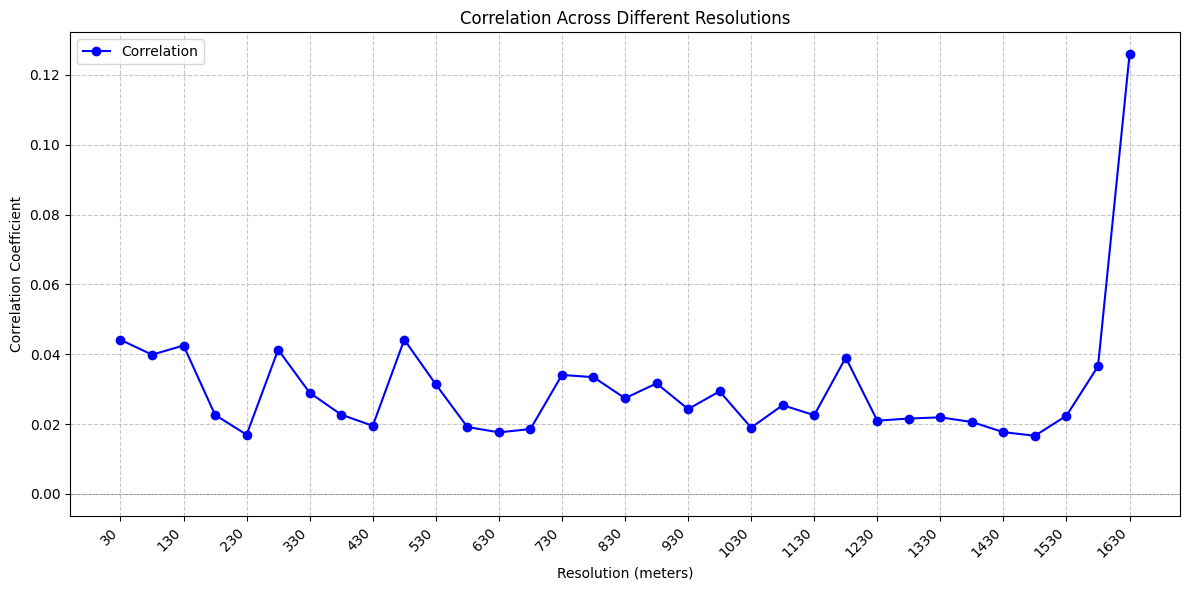

In [ ]:
best_res_build_dens, max_corr_build_dens = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"build_dens"), ground_df,32618,"build_dens")
# 30
# rf1630


Processing: mean_heigh_res30.tif
Feature importance improved: 0.0167

Processing: mean_heigh_res280.tif
Feature importance improved: 0.0218

Processing: mean_heigh_res580.tif
Feature importance improved: 0.0581

Processing: mean_heigh_res1530.tif
Feature importance improved: 0.0585

Processing: mean_heigh_res1630.tif
Feature importance improved: 0.2302

Best feature importance found:
Resolution: mean_heigh_res1630.tif
Feature Importance: 0.2302


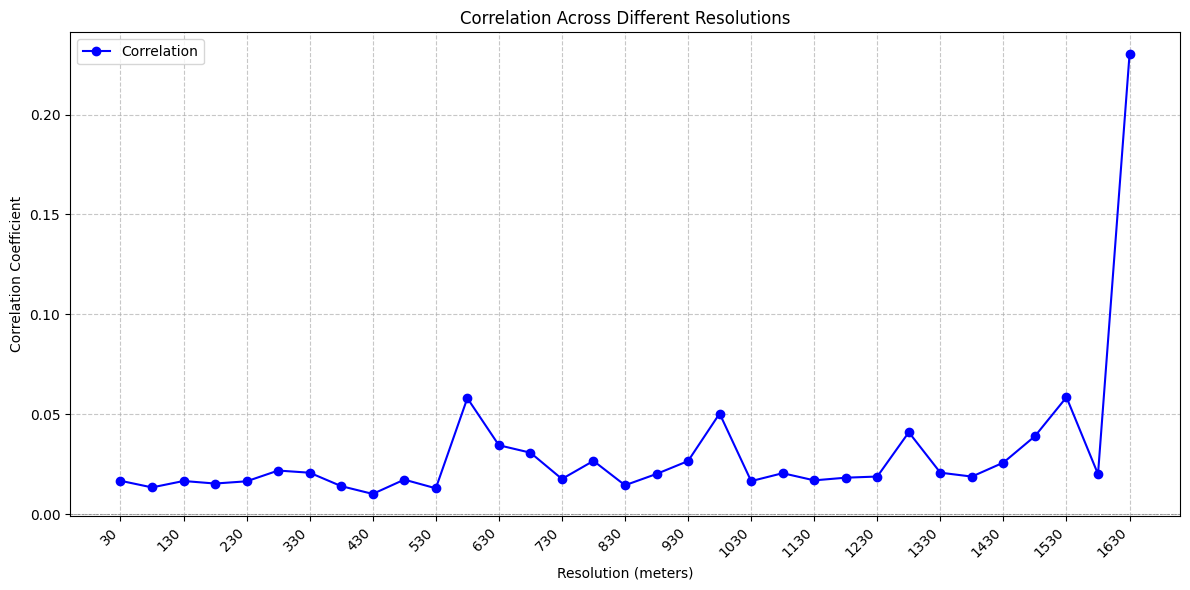

In [ ]:
best_res_mean_heigh, max_corr_mean_heigh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"mean_heigh"), ground_df,32618,"mean_heigh")
# 1480
# rf1630


Processing: popdensity_res30.tif
Feature importance improved: 0.0331

Processing: popdensity_res680.tif
Feature importance improved: 0.0419

Processing: popdensity_res1280.tif
Feature importance improved: 0.0865

Processing: popdensity_res1630.tif
Feature importance improved: 0.1192

Best feature importance found:
Resolution: popdensity_res1630.tif
Feature Importance: 0.1192


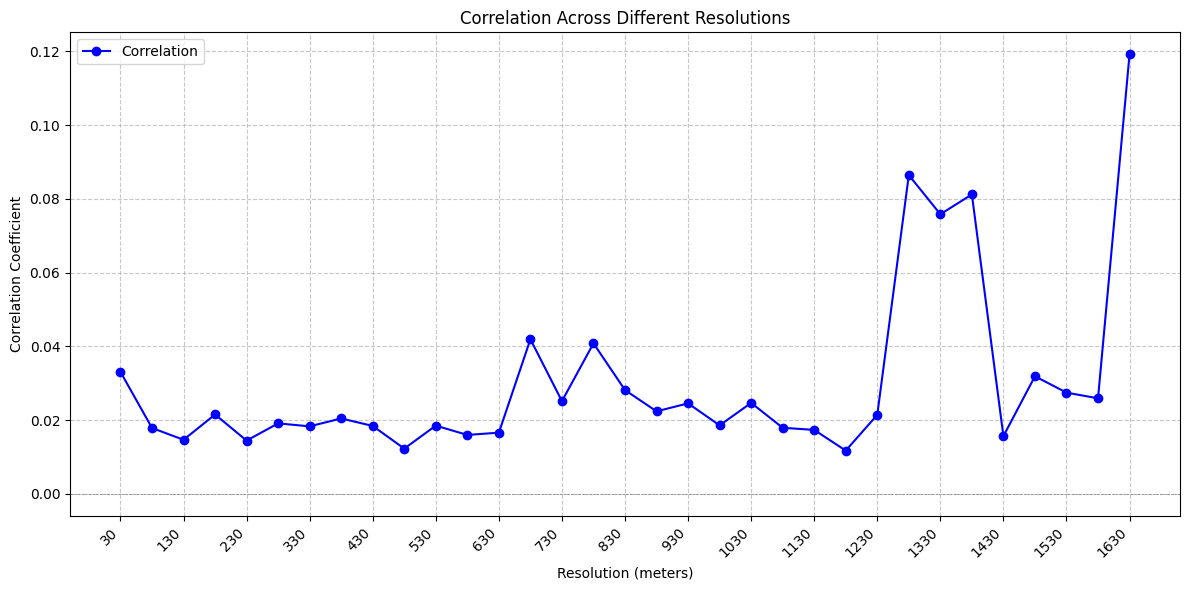

In [ ]:
best_res_popdensity, max_corr_popdensity = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity"), ground_df,32618,"popdensity")
# 1480
# rf1630

### Optimal Resolution for Theoretical Interaction


Processing: ndvi_impervious_res30.tif
Feature importance improved: 0.0754

Best feature importance found:
Resolution: ndvi_impervious_res30.tif
Feature Importance: 0.0754


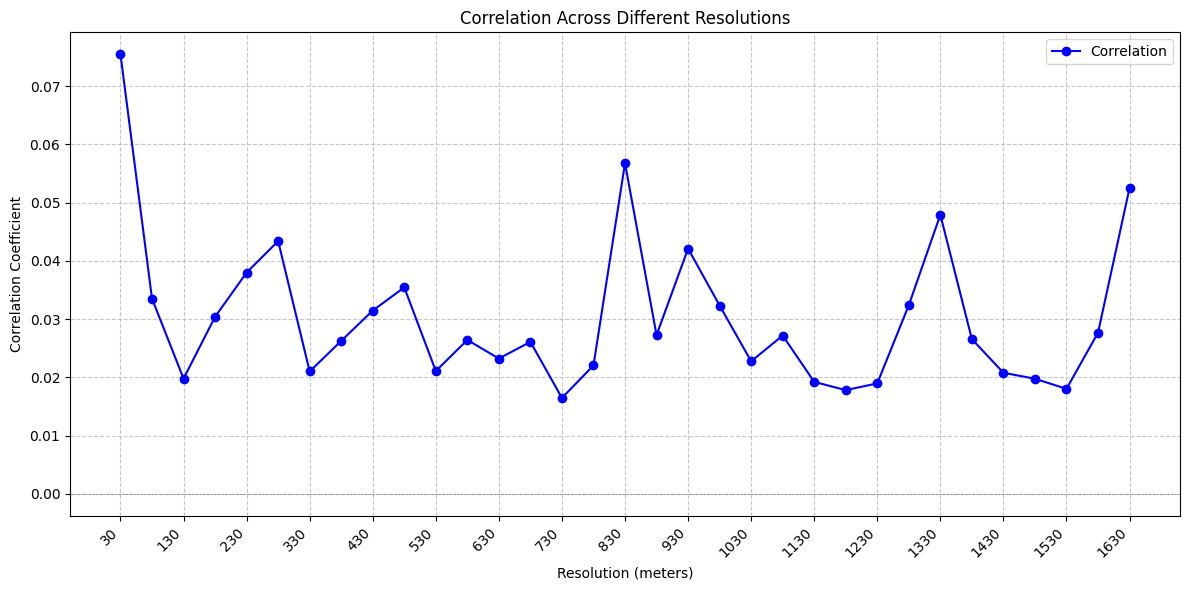

In [ ]:
best_res_ndvi_impervious, max_corr_ndvi_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndvi_impervious"), ground_df,32618,"ndvi_impervious")
# 1080
# rf30


Processing: ndvi_div_impervious_res30.tif
Feature importance improved: 0.0238

Processing: ndvi_div_impervious_res130.tif
Feature importance improved: 0.0279

Processing: ndvi_div_impervious_res280.tif
Feature importance improved: 0.0305

Processing: ndvi_div_impervious_res730.tif
Feature importance improved: 0.0501

Processing: ndvi_div_impervious_res930.tif
Feature importance improved: 0.0741

Processing: ndvi_div_impervious_res1630.tif
Feature importance improved: 0.2504

Best feature importance found:
Resolution: ndvi_div_impervious_res1630.tif
Feature Importance: 0.2504


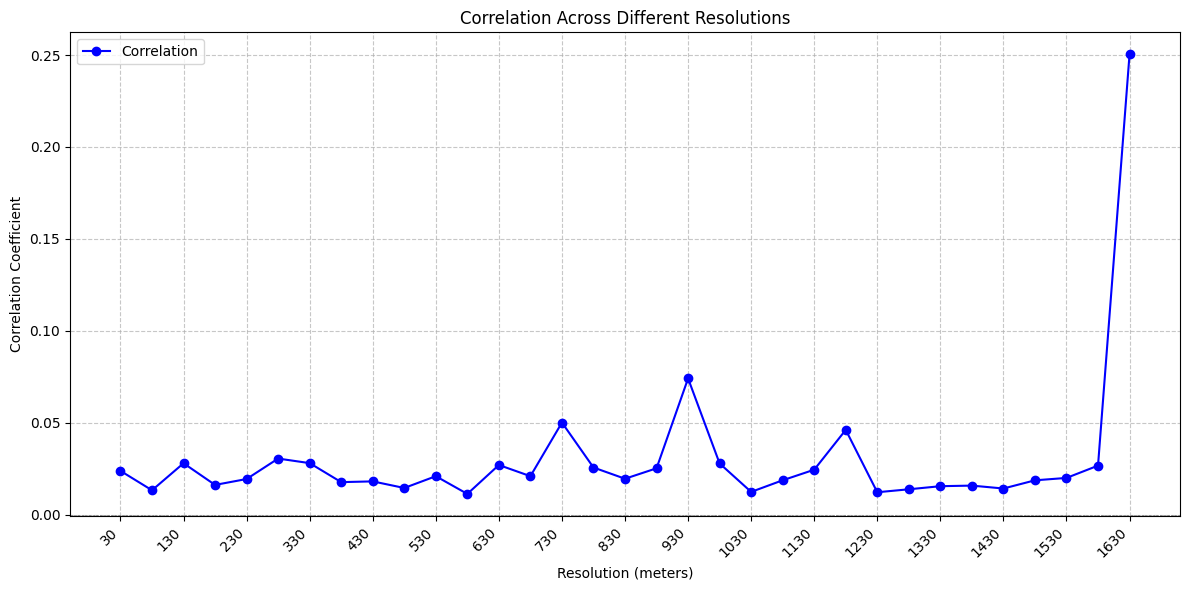

In [ ]:
best_res_ndvi_div_impervious, max_corr_ndvi_div_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndvi_div_impervious"), ground_df,32618,"ndvi_div_impervious")
# 1180
# rf1630


Processing: ndvi_buildcove_res30.tif
Feature importance improved: 0.0401

Processing: ndvi_buildcove_res180.tif
Feature importance improved: 0.0416

Processing: ndvi_buildcove_res380.tif
Feature importance improved: 0.0686

Processing: ndvi_buildcove_res1630.tif
Feature importance improved: 0.0800

Best feature importance found:
Resolution: ndvi_buildcove_res1630.tif
Feature Importance: 0.0800


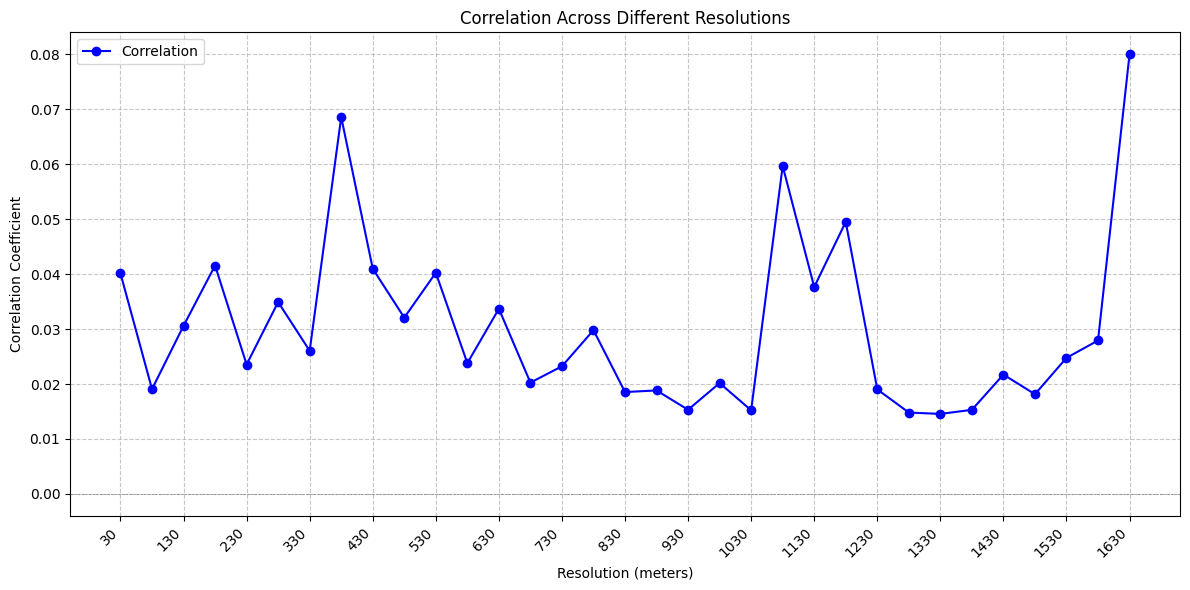

In [ ]:
best_res_ndvi_buildcove, max_corr_ndvi_buildcove = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndvi_buildcove"), ground_df,32618,"ndvi_buildcove")
# 30
# rf1630


Processing: ndvi_builddens_res30.tif
Feature importance improved: 0.0364

Processing: ndvi_builddens_res180.tif
Feature importance improved: 0.0377

Processing: ndvi_builddens_res330.tif
Feature importance improved: 0.0601

Processing: ndvi_builddens_res1030.tif
Feature importance improved: 0.0685

Best feature importance found:
Resolution: ndvi_builddens_res1030.tif
Feature Importance: 0.0685


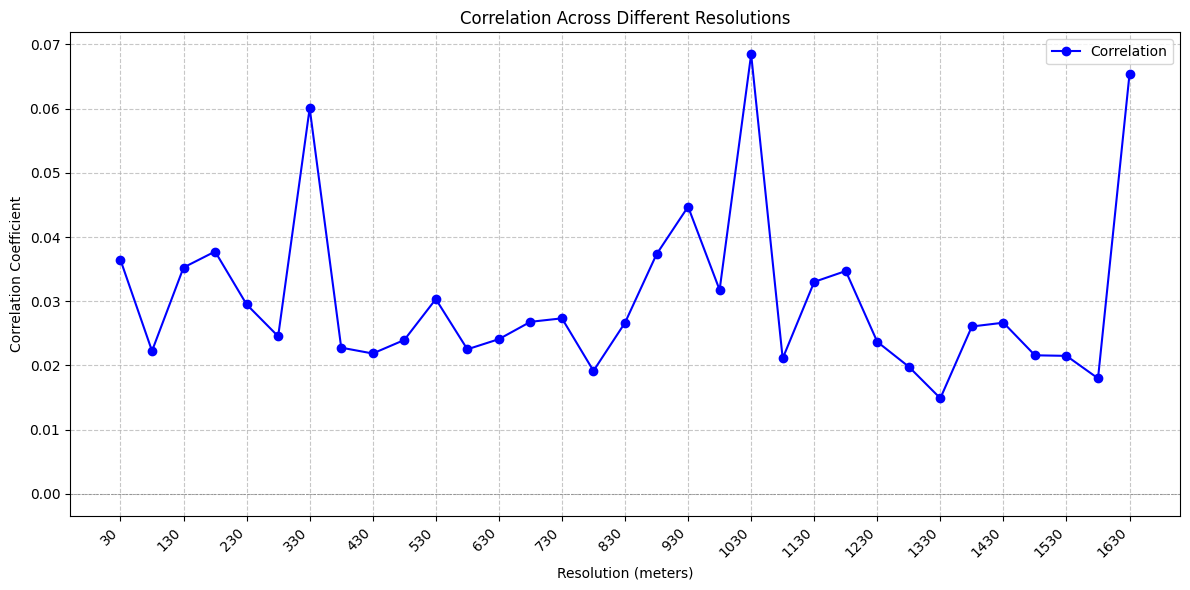

In [ ]:
best_res_ndvi_builddens, max_corr_ndvi_builddens = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndvi_builddens"), ground_df,32618,"ndvi_builddens")
# 1430
# rf1030


Processing: greenessres_impervious_res30.tif
Feature importance improved: 0.0064

Processing: greenessres_impervious_res80.tif
Feature importance improved: 0.0179

Processing: greenessres_impervious_res130.tif
Feature importance improved: 0.0245

Processing: greenessres_impervious_res180.tif
Feature importance improved: 0.0337

Processing: greenessres_impervious_res380.tif
Feature importance improved: 0.0355

Processing: greenessres_impervious_res880.tif
Feature importance improved: 0.0374

Processing: greenessres_impervious_res1430.tif
Feature importance improved: 0.0522

Processing: greenessres_impervious_res1580.tif
Feature importance improved: 0.0629

Processing: greenessres_impervious_res1630.tif
Feature importance improved: 0.1337

Best feature importance found:
Resolution: greenessres_impervious_res1630.tif
Feature Importance: 0.1337


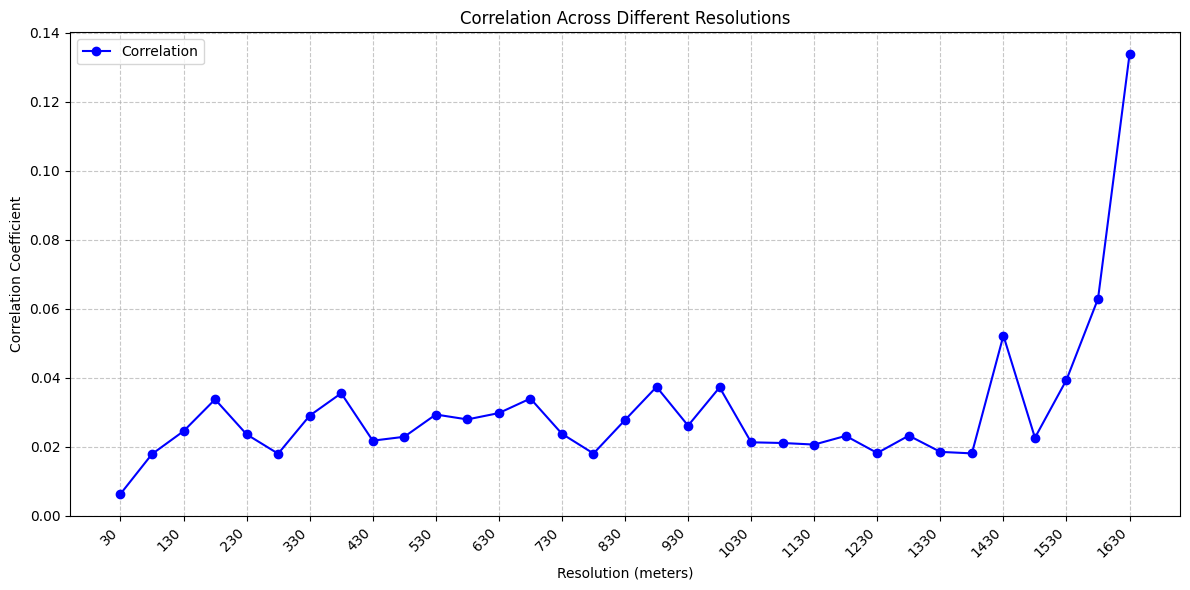

In [ ]:
best_res_greenessres_impervious, max_corr_greenessres_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"greenessres_impervious"), ground_df,32618,"greenessres_impervious")
# 30
# rf1630


Processing: ndvi_surfacealbedo_res30.tif
Feature importance improved: 0.0266

Processing: ndvi_surfacealbedo_res80.tif
Feature importance improved: 0.0278

Processing: ndvi_surfacealbedo_res130.tif
Feature importance improved: 0.0328

Processing: ndvi_surfacealbedo_res1030.tif
Feature importance improved: 0.0781

Processing: ndvi_surfacealbedo_res1530.tif
Feature importance improved: 0.1091

Best feature importance found:
Resolution: ndvi_surfacealbedo_res1530.tif
Feature Importance: 0.1091


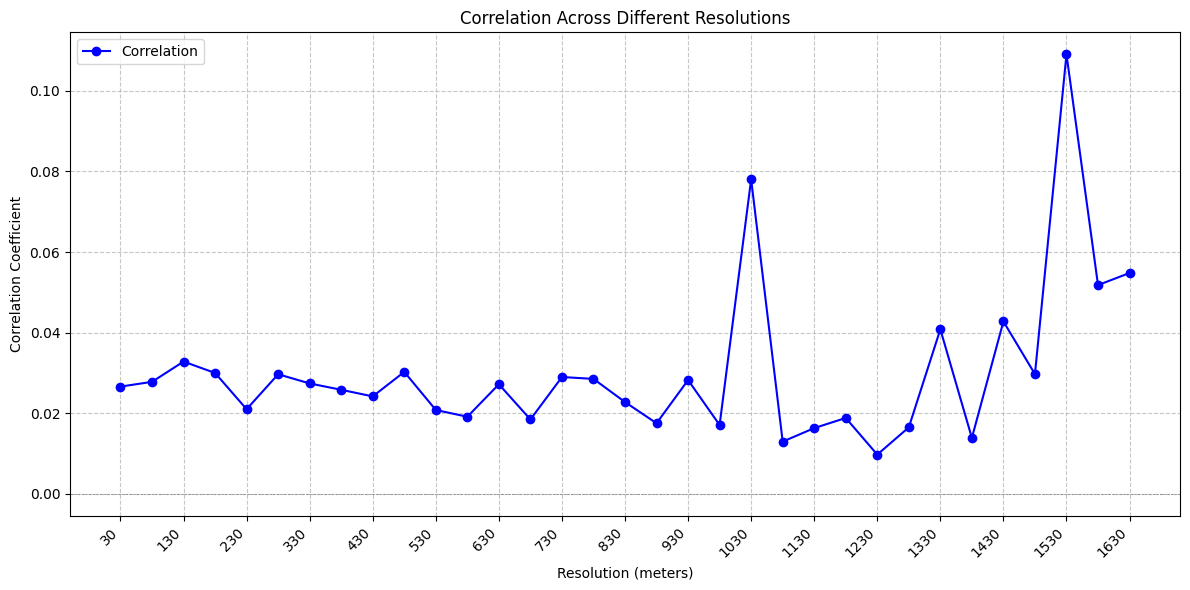

In [ ]:
best_res_ndvi_surfacealbedo, max_corr_ndvi_surfacealbedo = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"ndvi_surfacealbedo"), ground_df,32618,"ndvi_surfacealbedo")
# 30
# rf1530


Processing: landsatlst_buildcove_res30.tif
Feature importance improved: 0.0240

Processing: landsatlst_buildcove_res80.tif
Feature importance improved: 0.0357

Processing: landsatlst_buildcove_res280.tif
Feature importance improved: 0.0655

Best feature importance found:
Resolution: landsatlst_buildcove_res280.tif
Feature Importance: 0.0655


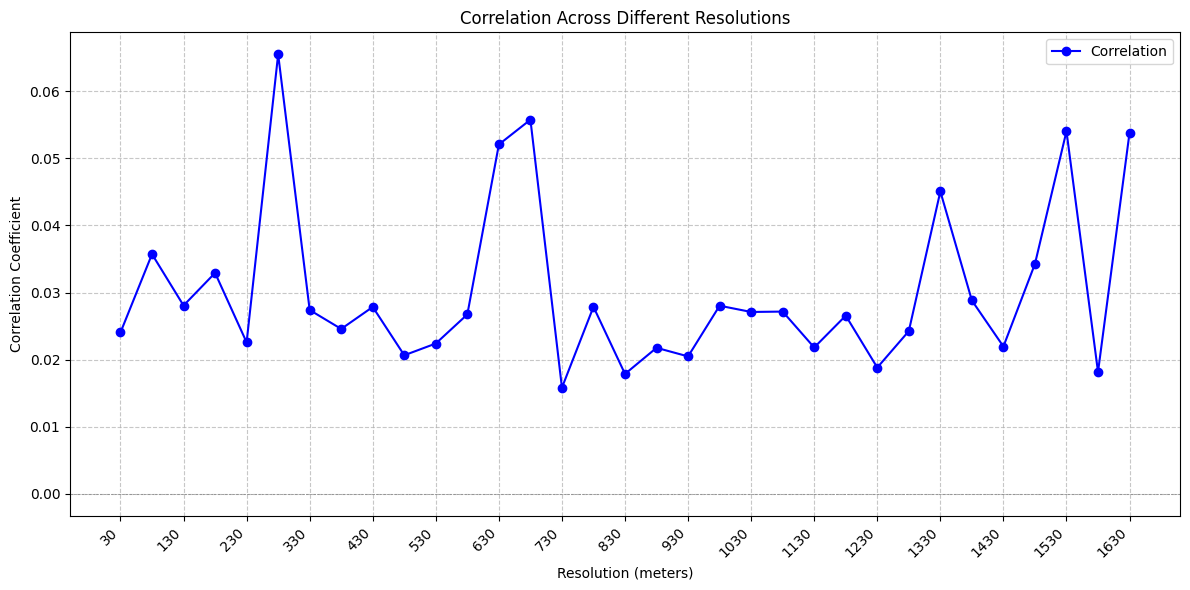

In [ ]:
best_res_landsatlst_buildcove, max_corr_landsatlst_buildcove = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"landsatlst_buildcove"), ground_df,32618,"landsatlst_buildcove")
# 1230
# rf280


Processing: landsatlst_builddens_res30.tif
Feature importance improved: 0.0317

Processing: landsatlst_builddens_res80.tif
Feature importance improved: 0.0464

Processing: landsatlst_builddens_res180.tif
Feature importance improved: 0.0557

Processing: landsatlst_builddens_res980.tif
Feature importance improved: 0.0632

Best feature importance found:
Resolution: landsatlst_builddens_res980.tif
Feature Importance: 0.0632


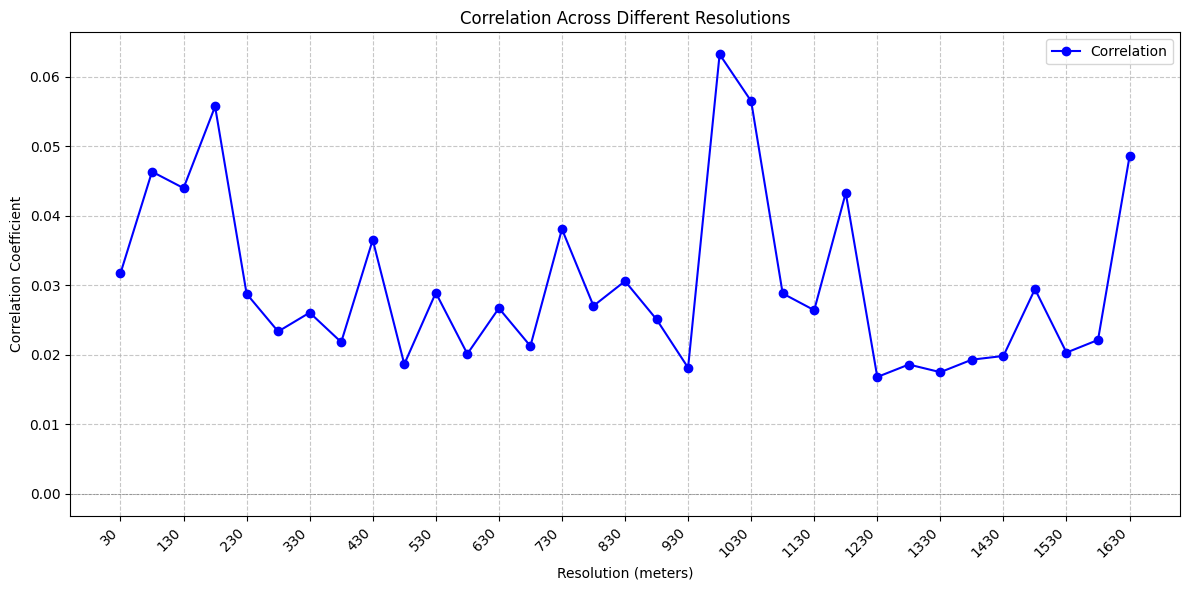

In [ ]:
best_res_landsatlst_builddens, max_corr_landsatlst_builddens = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"landsatlst_builddens"), ground_df,32618,"landsatlst_builddens")
# 1330
# rf980


Processing: landsatlst_meanheigh_res30.tif
Feature importance improved: 0.0363

Processing: landsatlst_meanheigh_res280.tif
Feature importance improved: 0.0388

Processing: landsatlst_meanheigh_res580.tif
Feature importance improved: 0.0422

Processing: landsatlst_meanheigh_res630.tif
Feature importance improved: 0.0597

Processing: landsatlst_meanheigh_res1430.tif
Feature importance improved: 0.0767

Best feature importance found:
Resolution: landsatlst_meanheigh_res1430.tif
Feature Importance: 0.0767


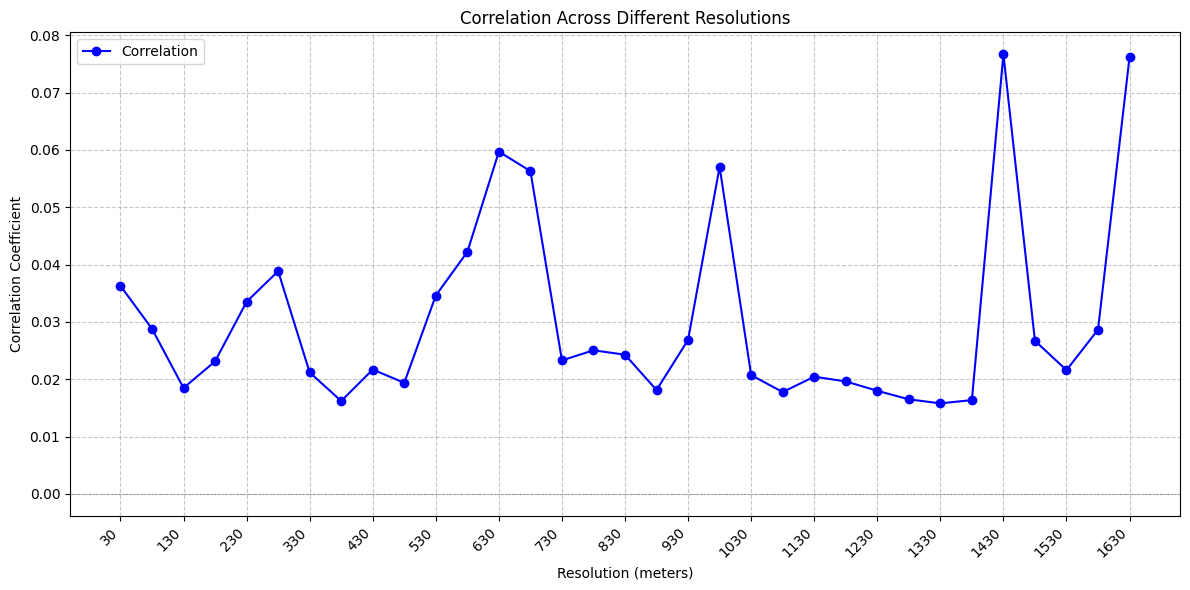

In [ ]:
best_res_landsatlst_meanheigh, max_corr_landsatlst_meanheigh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"landsatlst_meanheigh"), ground_df,32618,"landsatlst_meanheigh")
# 1180
# rf1430


Processing: landsatlst_impervious_res30.tif
Feature importance improved: 0.0165

Processing: landsatlst_impervious_res80.tif
Feature importance improved: 0.0244

Processing: landsatlst_impervious_res130.tif
Feature importance improved: 0.0488

Processing: landsatlst_impervious_res1030.tif
Feature importance improved: 0.0623

Processing: landsatlst_impervious_res1130.tif
Feature importance improved: 0.0627

Processing: landsatlst_impervious_res1180.tif
Feature importance improved: 0.1507

Best feature importance found:
Resolution: landsatlst_impervious_res1180.tif
Feature Importance: 0.1507


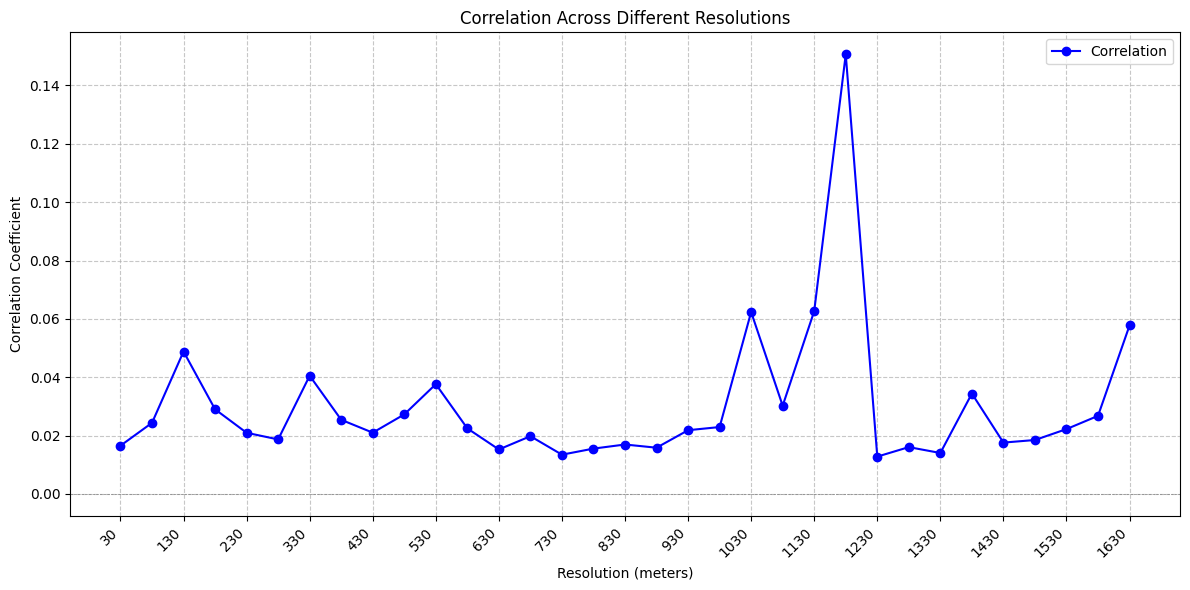

In [ ]:
best_res_landsatlst_impervious, max_corr_landsatlst_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"landsatlst_impervious"), ground_df,32618,"landsatlst_impervious")
# 1180
# rf1180


Processing: landsatlst_div_foresthight_res30.tif
Feature importance improved: 0.0400

Processing: landsatlst_div_foresthight_res580.tif
Feature importance improved: 0.0511

Processing: landsatlst_div_foresthight_res1630.tif
Feature importance improved: 0.1951

Best feature importance found:
Resolution: landsatlst_div_foresthight_res1630.tif
Feature Importance: 0.1951


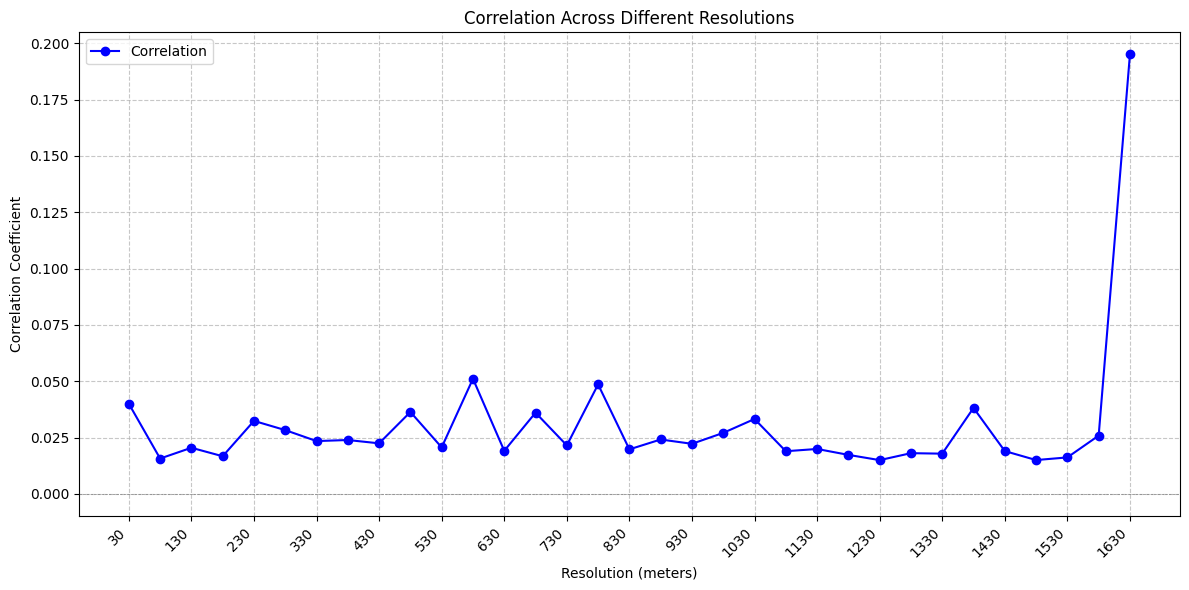

In [ ]:
best_res_landsatlst_div_foresthight, max_corr_landsatlst_div_foresthight = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"landsatlst_div_foresthight"), ground_df,32618,"landsatlst_div_foresthight")
# 980
# rf1630


Processing: popdensity_impervious_res30.tif
Feature importance improved: 0.0237

Processing: popdensity_impervious_res80.tif
Feature importance improved: 0.0669

Processing: popdensity_impervious_res1180.tif
Feature importance improved: 0.1016

Best feature importance found:
Resolution: popdensity_impervious_res1180.tif
Feature Importance: 0.1016


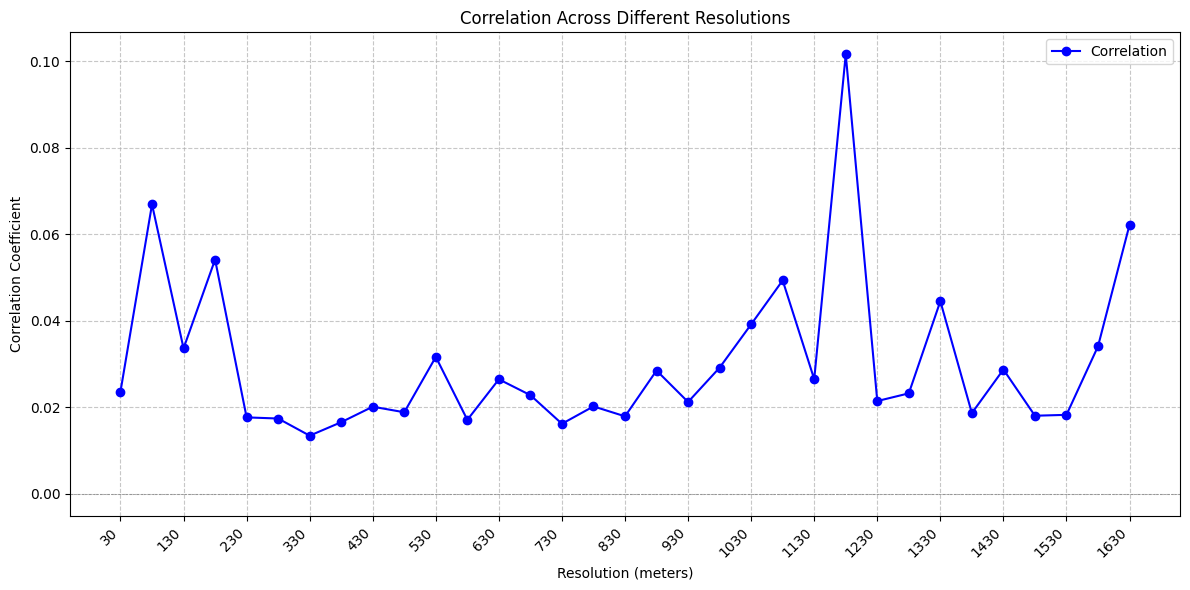

In [ ]:
best_res_popdensity_impervious, max_corr_popdensity_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_impervious"), ground_df,32618,"popdensity_impervious")
# 1030
# rf1180


Processing: popdensity_buildcove_res30.tif
Feature importance improved: 0.0188

Processing: popdensity_buildcove_res80.tif
Feature importance improved: 0.0316

Processing: popdensity_buildcove_res130.tif
Feature importance improved: 0.0387

Processing: popdensity_buildcove_res180.tif
Feature importance improved: 0.0677

Processing: popdensity_buildcove_res1180.tif
Feature importance improved: 0.0951

Processing: popdensity_buildcove_res1230.tif
Feature importance improved: 0.1281

Best feature importance found:
Resolution: popdensity_buildcove_res1230.tif
Feature Importance: 0.1281


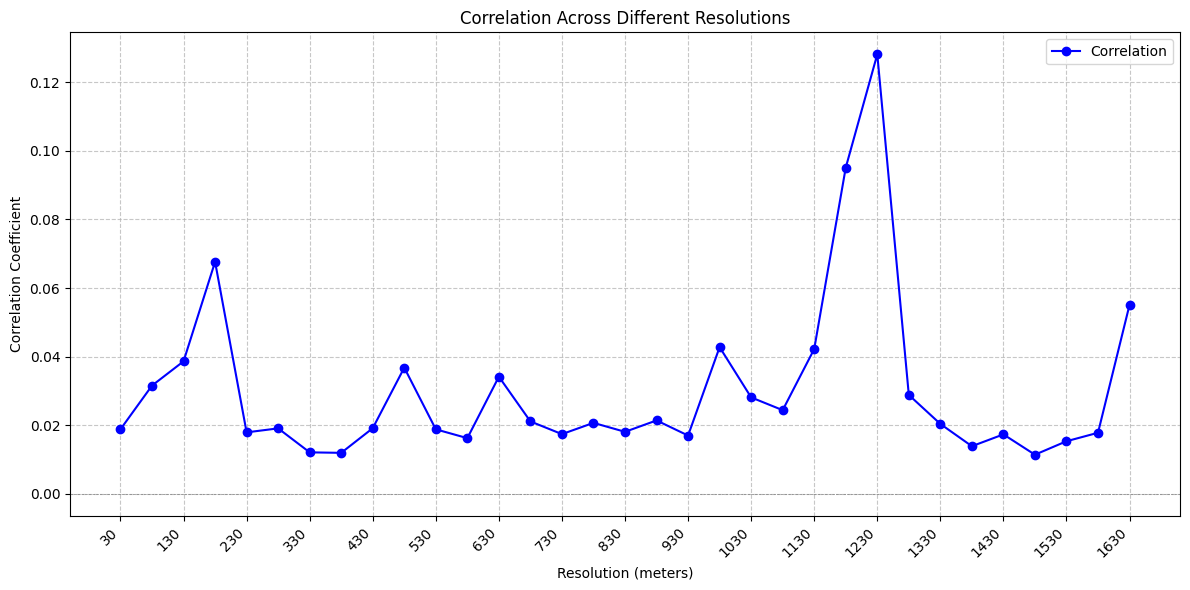

In [ ]:
best_res_popdensity_buildcove, max_corr_popdensity_buildcove = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_buildcove"), ground_df,32618,"popdensity_buildcove")
# 1180
# rf1230


Processing: popdensity_builddens_res30.tif
Feature importance improved: 0.0196

Processing: popdensity_builddens_res80.tif
Feature importance improved: 0.0261

Processing: popdensity_builddens_res180.tif
Feature importance improved: 0.0586

Processing: popdensity_builddens_res1280.tif
Feature importance improved: 0.1067

Processing: popdensity_builddens_res1630.tif
Feature importance improved: 0.1310

Best feature importance found:
Resolution: popdensity_builddens_res1630.tif
Feature Importance: 0.1310


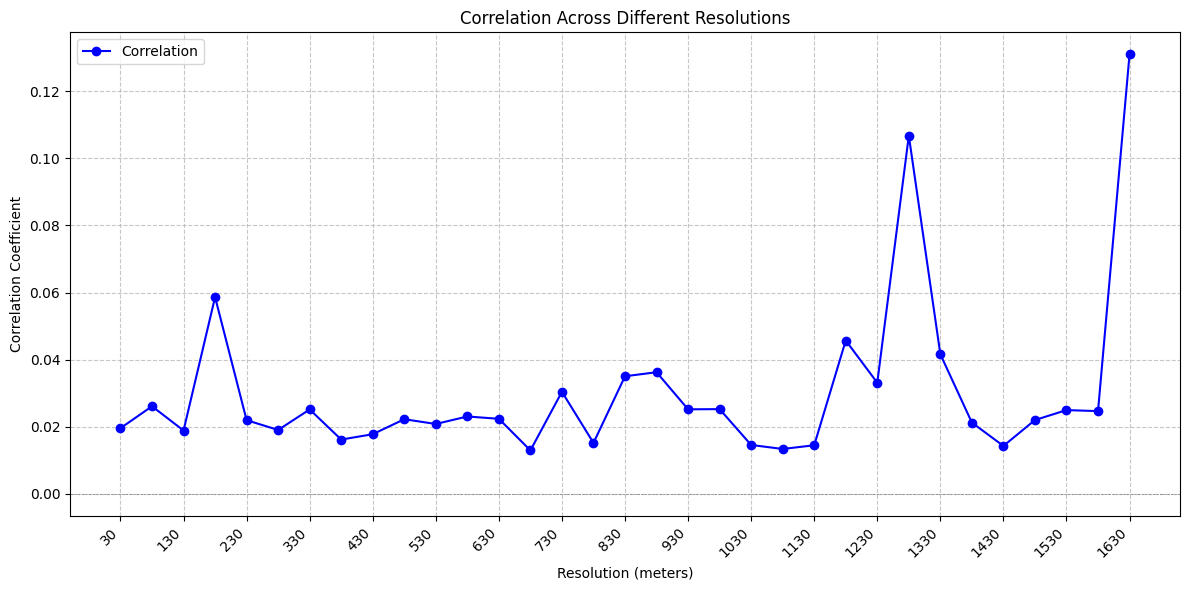

In [ ]:
best_res_popdensity_builddens, max_corr_popdensity_builddens = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_builddens"), ground_df,32618,"popdensity_builddens")
# 1280
# rf1630


Processing: popdensity_meanheigh_res30.tif
Feature importance improved: 0.0157

Processing: popdensity_meanheigh_res80.tif
Feature importance improved: 0.0166

Processing: popdensity_meanheigh_res130.tif
Feature importance improved: 0.0176

Processing: popdensity_meanheigh_res180.tif
Feature importance improved: 0.0577

Processing: popdensity_meanheigh_res1080.tif
Feature importance improved: 0.0602

Processing: popdensity_meanheigh_res1130.tif
Feature importance improved: 0.1372

Best feature importance found:
Resolution: popdensity_meanheigh_res1130.tif
Feature Importance: 0.1372


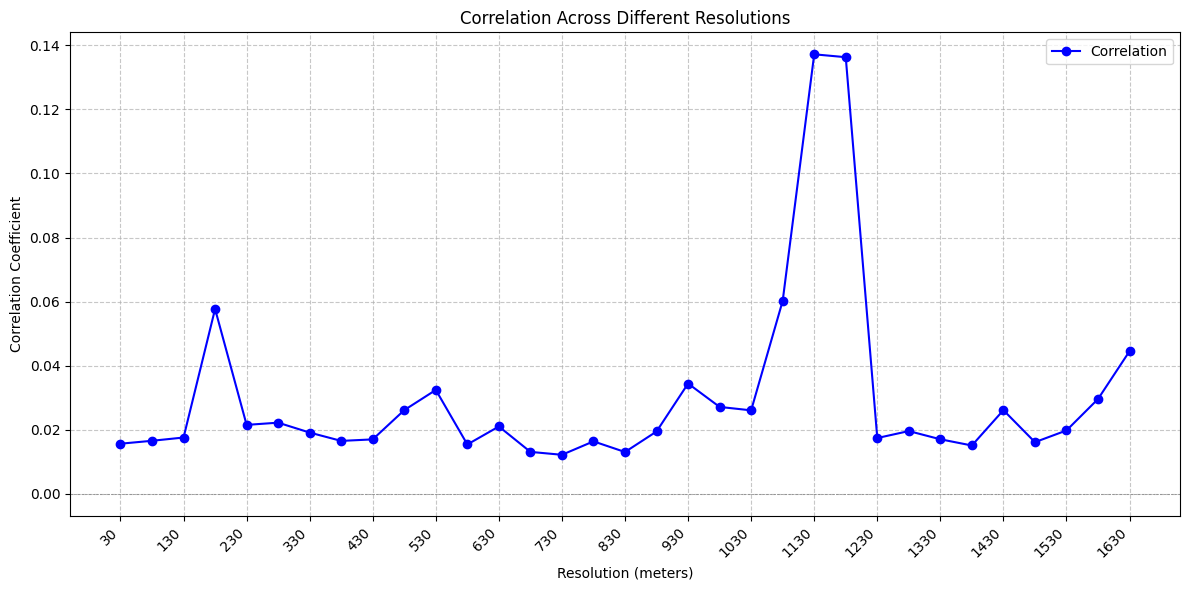

In [ ]:
best_res_popdensity_meanheigh, max_corr_popdensity_meanheigh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_meanheigh"), ground_df,32618,"popdensity_meanheigh")
# 1130
# rf1130


Processing: popdensity_surfacealbedo_res30.tif
Feature importance improved: 0.0218

Processing: popdensity_surfacealbedo_res80.tif
Feature importance improved: 0.0236

Processing: popdensity_surfacealbedo_res130.tif
Feature importance improved: 0.0550

Processing: popdensity_surfacealbedo_res180.tif
Feature importance improved: 0.0580

Processing: popdensity_surfacealbedo_res1630.tif
Feature importance improved: 0.0620

Best feature importance found:
Resolution: popdensity_surfacealbedo_res1630.tif
Feature Importance: 0.0620


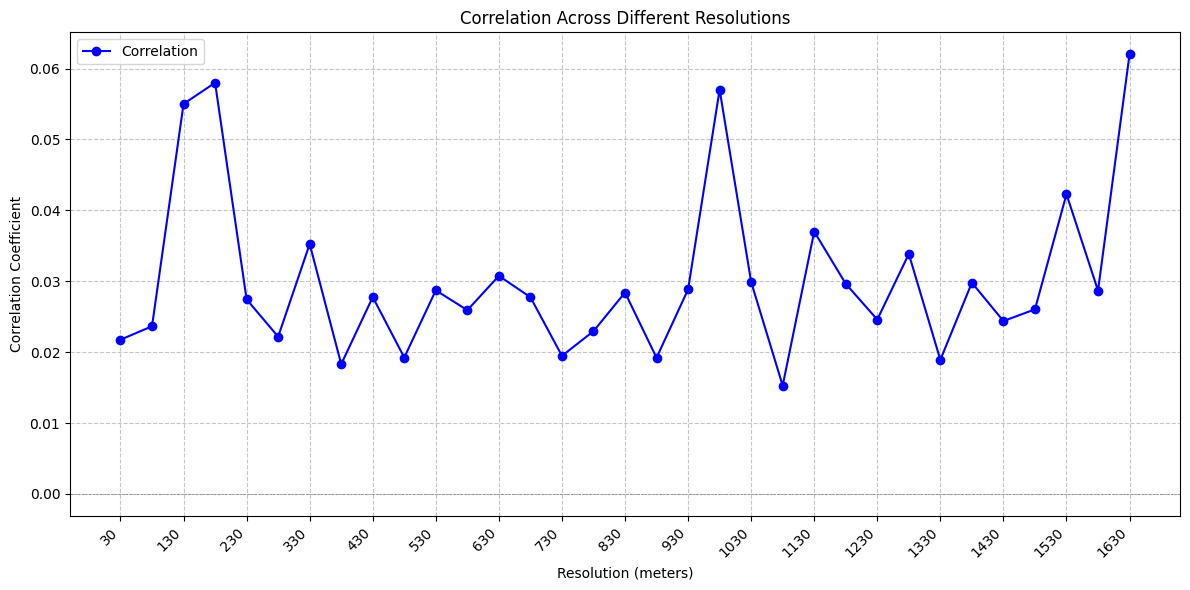

In [ ]:
best_res_popdensity_surfacealbedo, max_corr_popdensity_surfacealbedo = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_surfacealbedo"), ground_df,32618,"popdensity_surfacealbedo")
# 880
# rf1630


Processing: popdensity_landsatlst_res30.tif
Feature importance improved: 0.0197

Processing: popdensity_landsatlst_res80.tif
Feature importance improved: 0.0454

Processing: popdensity_landsatlst_res130.tif
Feature importance improved: 0.0469

Processing: popdensity_landsatlst_res180.tif
Feature importance improved: 0.0691

Processing: popdensity_landsatlst_res1180.tif
Feature importance improved: 0.0913

Best feature importance found:
Resolution: popdensity_landsatlst_res1180.tif
Feature Importance: 0.0913


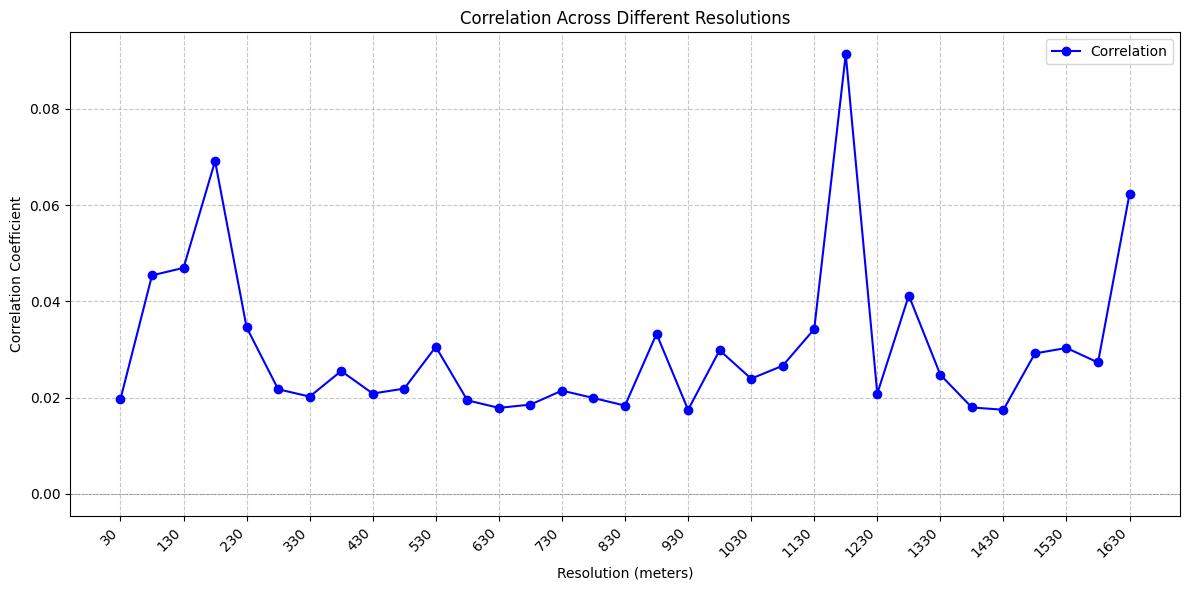

In [ ]:
best_res_popdensity_landsatlst, max_corr_popdensity_landsatlst = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_landsatlst"), ground_df,32618,"popdensity_landsatlst")
# 980
# rf1180


Processing: popdensity_hsp1_res30.tif
Feature importance improved: 0.0277

Processing: popdensity_hsp1_res80.tif
Feature importance improved: 0.0287

Processing: popdensity_hsp1_res130.tif
Feature importance improved: 0.0401

Processing: popdensity_hsp1_res830.tif
Feature importance improved: 0.0568

Processing: popdensity_hsp1_res980.tif
Feature importance improved: 0.0798

Processing: popdensity_hsp1_res1080.tif
Feature importance improved: 0.1016

Best feature importance found:
Resolution: popdensity_hsp1_res1080.tif
Feature Importance: 0.1016


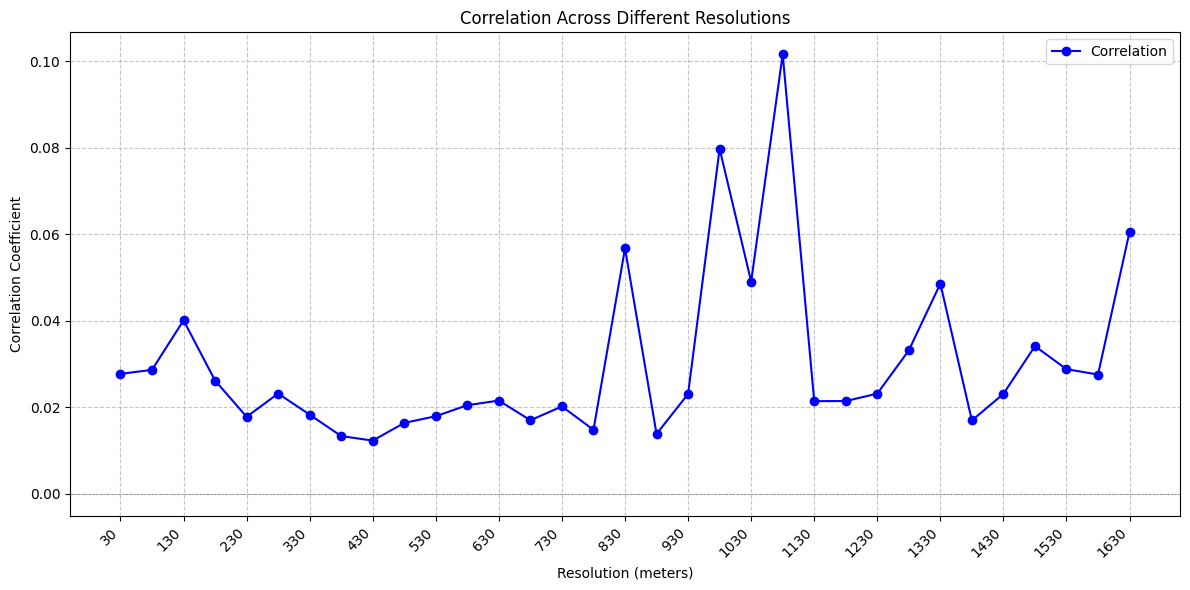

In [ ]:
best_res_popdensity_hsp1, max_corr_popdensity_hsp1 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_hsp1"), ground_df,32618,"popdensity_hsp1")
# 1180
# rf1080


Processing: popdensity_hunits_res30.tif
Feature importance improved: 0.0268

Processing: popdensity_hunits_res130.tif
Feature importance improved: 0.0585

Processing: popdensity_hunits_res1230.tif
Feature importance improved: 0.0669

Processing: popdensity_hunits_res1330.tif
Feature importance improved: 0.2386

Best feature importance found:
Resolution: popdensity_hunits_res1330.tif
Feature Importance: 0.2386


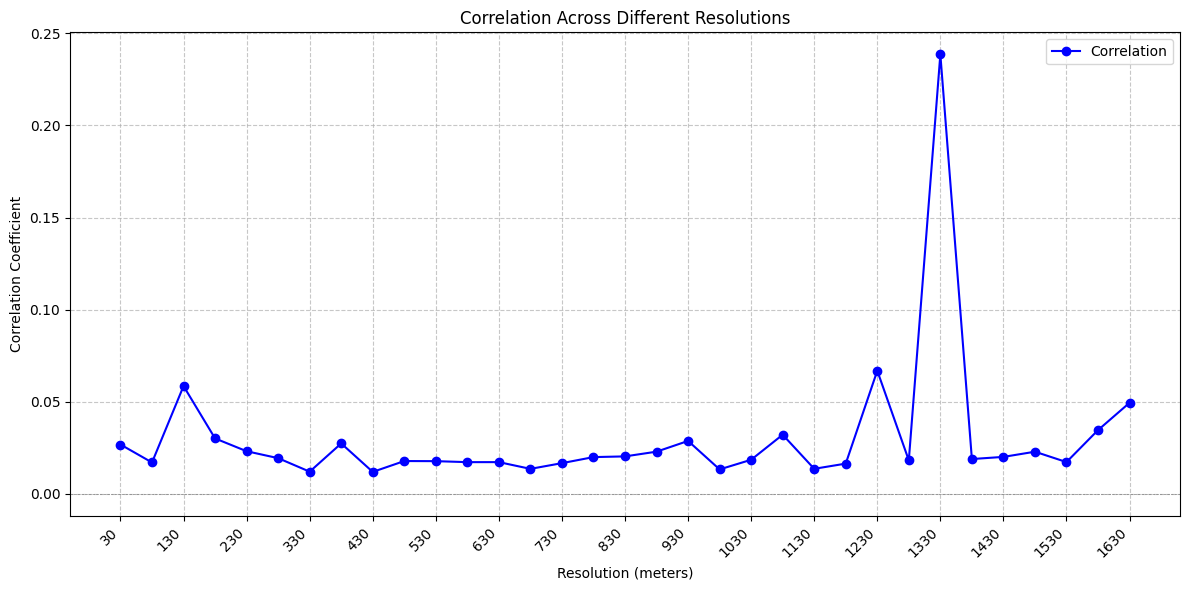

In [ ]:
best_res_popdensity_hunits, max_corr_popdensity_hunits = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"popdensity_hunits"), ground_df,32618,"popdensity_hunits")
# 1230
# rf1330


Processing: meanheigh_impervious_res30.tif
Feature importance improved: 0.0248

Processing: meanheigh_impervious_res80.tif
Feature importance improved: 0.0398

Processing: meanheigh_impervious_res180.tif
Feature importance improved: 0.0769

Processing: meanheigh_impervious_res1630.tif
Feature importance improved: 0.1062

Best feature importance found:
Resolution: meanheigh_impervious_res1630.tif
Feature Importance: 0.1062


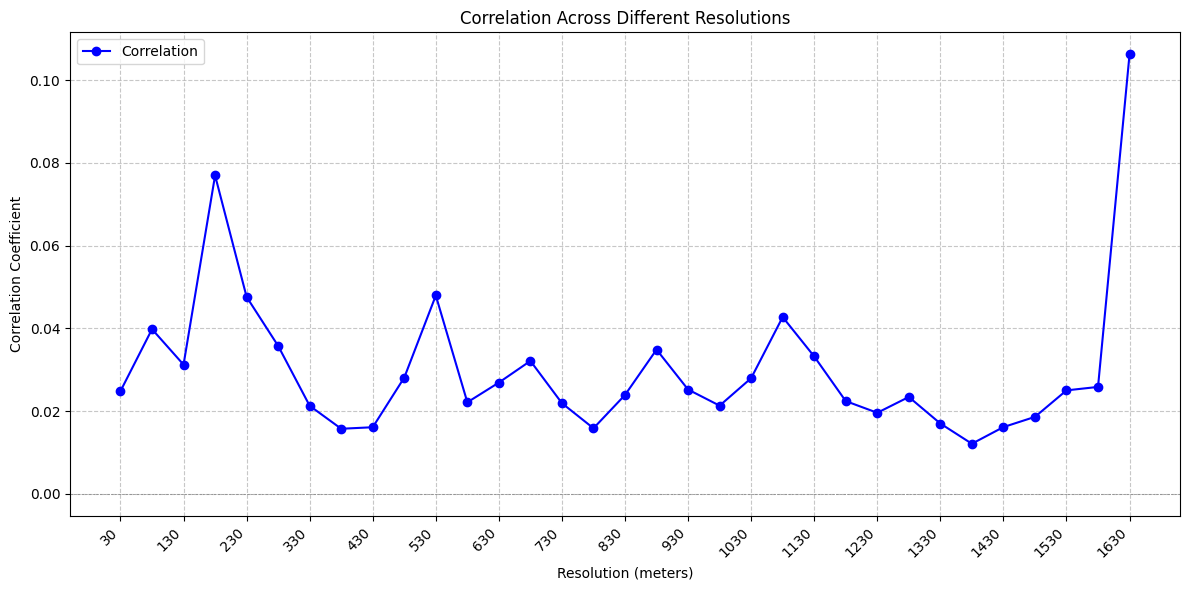

In [ ]:
best_res_meanheigh_impervious, max_corr_meanheigh_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"meanheigh_impervious"), ground_df,32618,"meanheigh_impervious")
# 930
# rf1630


Processing: meanheigh_buildcove_res30.tif
Feature importance improved: 0.0183

Processing: meanheigh_buildcove_res80.tif
Feature importance improved: 0.0245

Processing: meanheigh_buildcove_res130.tif
Feature importance improved: 0.0250

Processing: meanheigh_buildcove_res180.tif
Feature importance improved: 0.0267

Processing: meanheigh_buildcove_res230.tif
Feature importance improved: 0.0365

Processing: meanheigh_buildcove_res480.tif
Feature importance improved: 0.0440

Processing: meanheigh_buildcove_res730.tif
Feature importance improved: 0.0572

Processing: meanheigh_buildcove_res1080.tif
Feature importance improved: 0.2468

Best feature importance found:
Resolution: meanheigh_buildcove_res1080.tif
Feature Importance: 0.2468


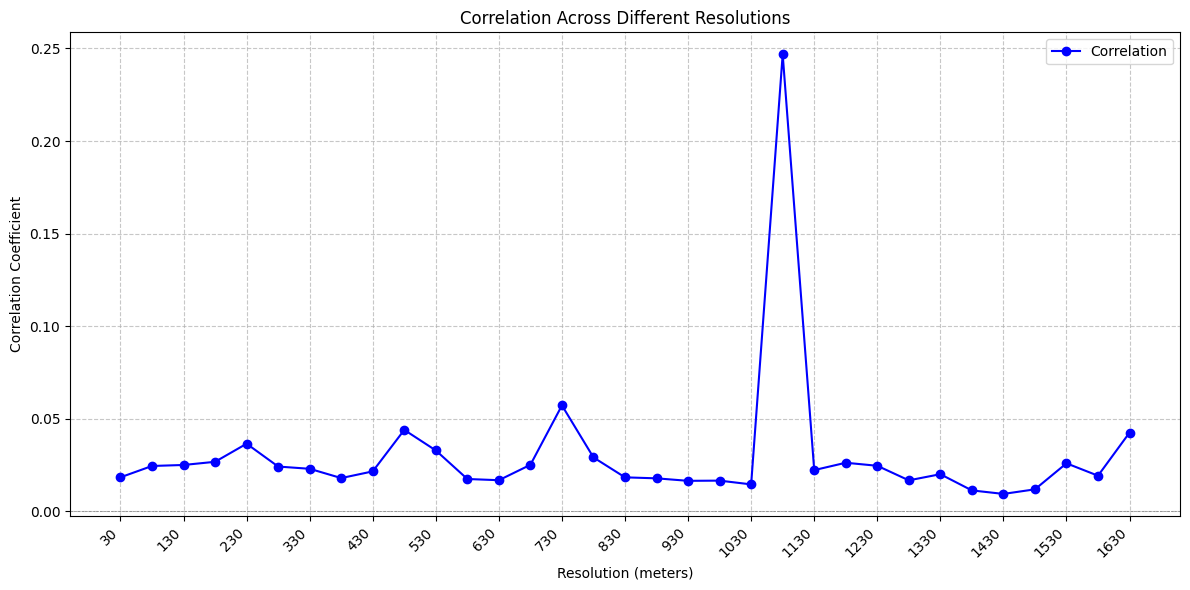

In [ ]:
best_res_meanheigh_buildcove, max_corr_meanheigh_buildcove = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"meanheigh_buildcove"), ground_df,32618,"meanheigh_buildcove")
# 1080
# rf1080


Processing: meanheigh_builddens_res30.tif
Feature importance improved: 0.0236

Processing: meanheigh_builddens_res130.tif
Feature importance improved: 0.0289

Processing: meanheigh_builddens_res230.tif
Feature importance improved: 0.0422

Processing: meanheigh_builddens_res1180.tif
Feature importance improved: 0.1692

Best feature importance found:
Resolution: meanheigh_builddens_res1180.tif
Feature Importance: 0.1692


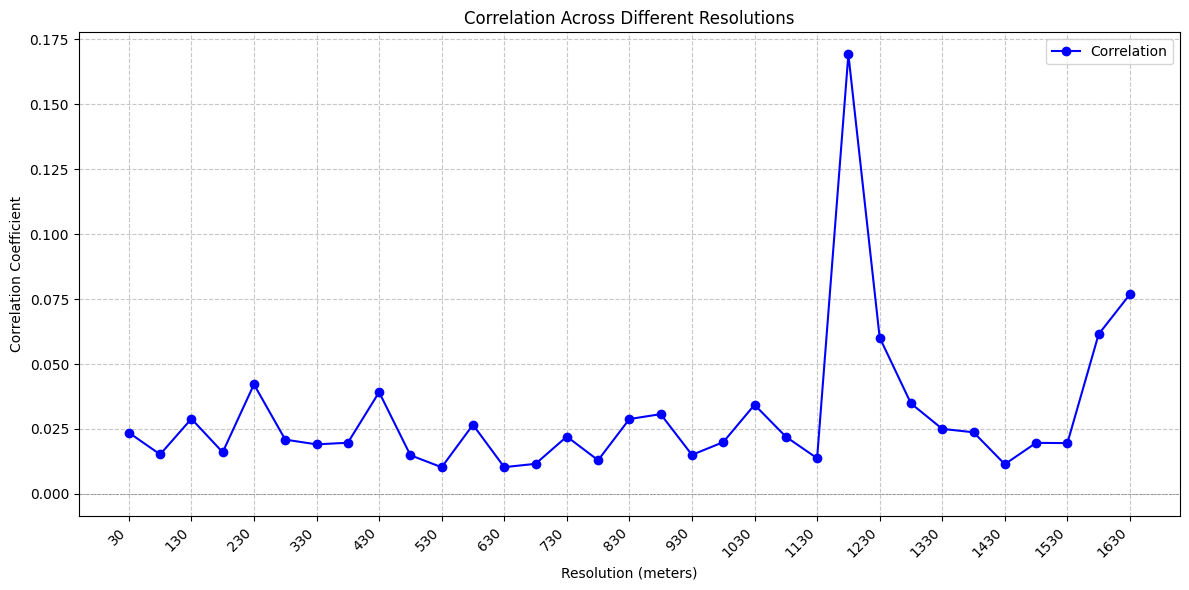

In [ ]:
best_res_meanheigh_builddens, max_corr_meanheigh_builddens = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"meanheigh_builddens"), ground_df,32618,"meanheigh_builddens")
# 1230
# rf1180


Processing: meanheigh_div_foresthight_res30.tif
Feature importance improved: 0.0316

Processing: meanheigh_div_foresthight_res180.tif
Feature importance improved: 0.0324

Processing: meanheigh_div_foresthight_res230.tif
Feature importance improved: 0.0368

Processing: meanheigh_div_foresthight_res330.tif
Feature importance improved: 0.0441

Processing: meanheigh_div_foresthight_res1080.tif
Feature importance improved: 0.0530

Processing: meanheigh_div_foresthight_res1580.tif
Feature importance improved: 0.0622

Best feature importance found:
Resolution: meanheigh_div_foresthight_res1580.tif
Feature Importance: 0.0622


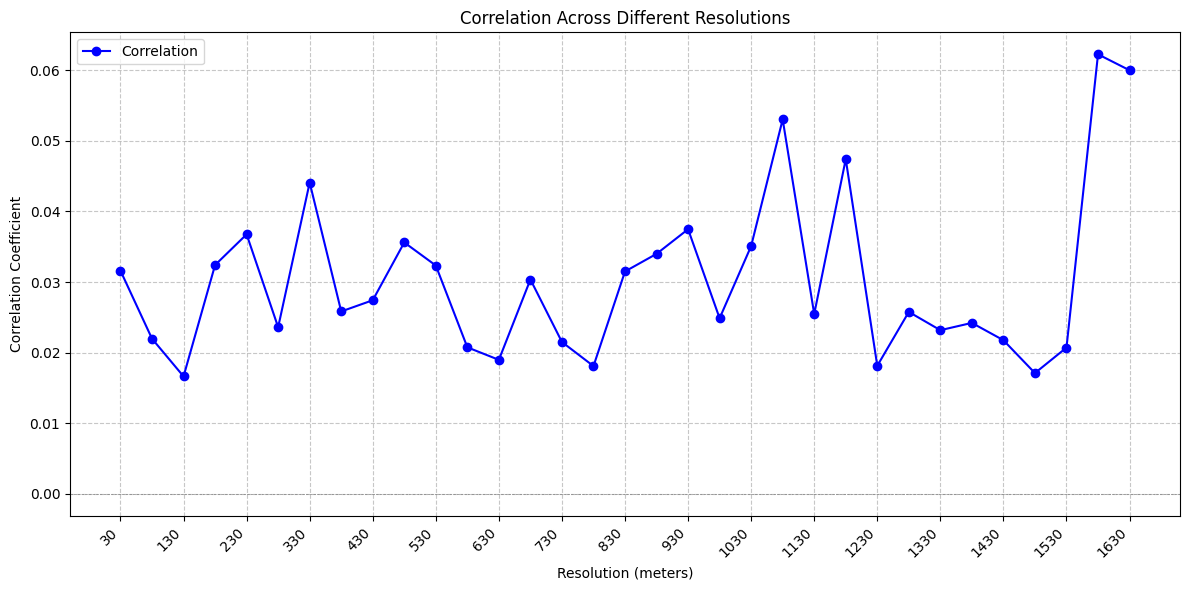

In [ ]:
best_res_meanheigh_div_foresthight, max_corr_meanheigh_div_foresthight = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"meanheigh_div_foresthight"), ground_df,32618,"meanheigh_div_foresthight")
# 30
# rf1080


Processing: buildcove_meanb_yea_res30.tif
Feature importance improved: 0.0307

Processing: buildcove_meanb_yea_res80.tif
Feature importance improved: 0.0351

Processing: buildcove_meanb_yea_res230.tif
Feature importance improved: 0.0388

Processing: buildcove_meanb_yea_res280.tif
Feature importance improved: 0.0411

Processing: buildcove_meanb_yea_res580.tif
Feature importance improved: 0.0632

Processing: buildcove_meanb_yea_res1630.tif
Feature importance improved: 0.0826

Best feature importance found:
Resolution: buildcove_meanb_yea_res1630.tif
Feature Importance: 0.0826


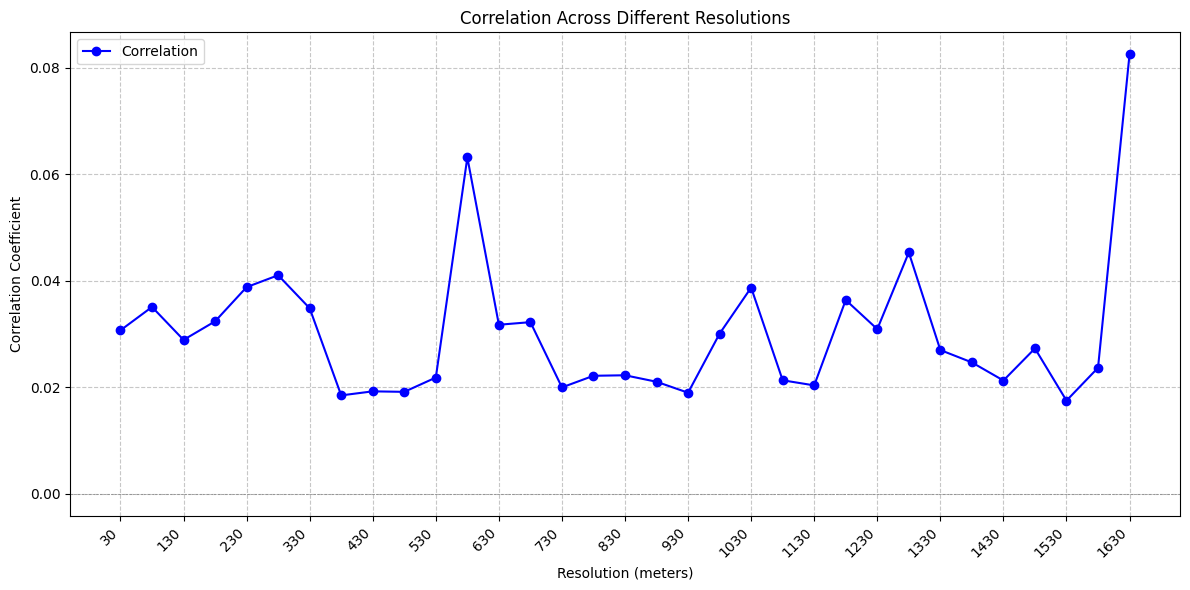

In [ ]:
best_res_buildcove_meanb_yea, max_corr_buildcove_meanb_yea = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"buildcove_meanb_yea"), ground_df,32618,"buildcove_meanb_yea")
# 1230
# rf1630


Processing: buildcove_meanc_occ_res30.tif
Feature importance improved: 0.0343

Processing: buildcove_meanc_occ_res80.tif
Feature importance improved: 0.0360

Processing: buildcove_meanc_occ_res230.tif
Feature importance improved: 0.0422

Processing: buildcove_meanc_occ_res280.tif
Feature importance improved: 0.0452

Processing: buildcove_meanc_occ_res630.tif
Feature importance improved: 0.0480

Processing: buildcove_meanc_occ_res680.tif
Feature importance improved: 0.0600

Best feature importance found:
Resolution: buildcove_meanc_occ_res680.tif
Feature Importance: 0.0600


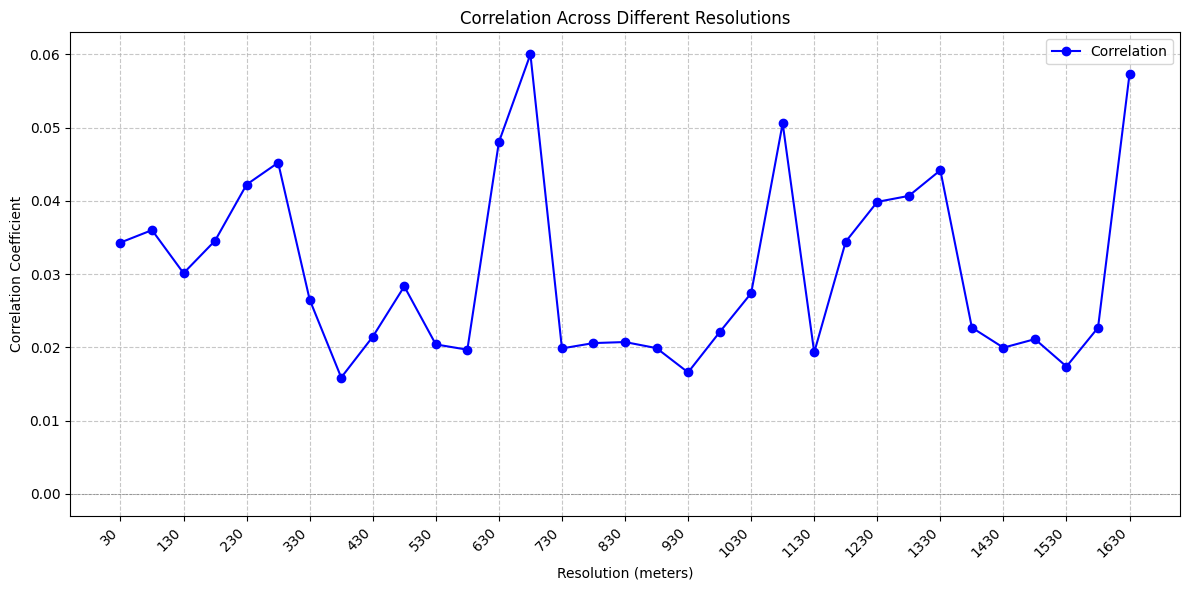

In [ ]:
best_res_buildcove_meanc_occ, max_corr_buildcove_meanc_occ = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"buildcove_meanc_occ"), ground_df,32618,"buildcove_meanc_occ")
# 1230
# rf680


Processing: impervious_hunits_res30.tif
Feature importance improved: 0.0211

Processing: impervious_hunits_res80.tif
Feature importance improved: 0.0223

Processing: impervious_hunits_res130.tif
Feature importance improved: 0.0262

Processing: impervious_hunits_res180.tif
Feature importance improved: 0.0531

Processing: impervious_hunits_res1230.tif
Feature importance improved: 0.2281

Best feature importance found:
Resolution: impervious_hunits_res1230.tif
Feature Importance: 0.2281


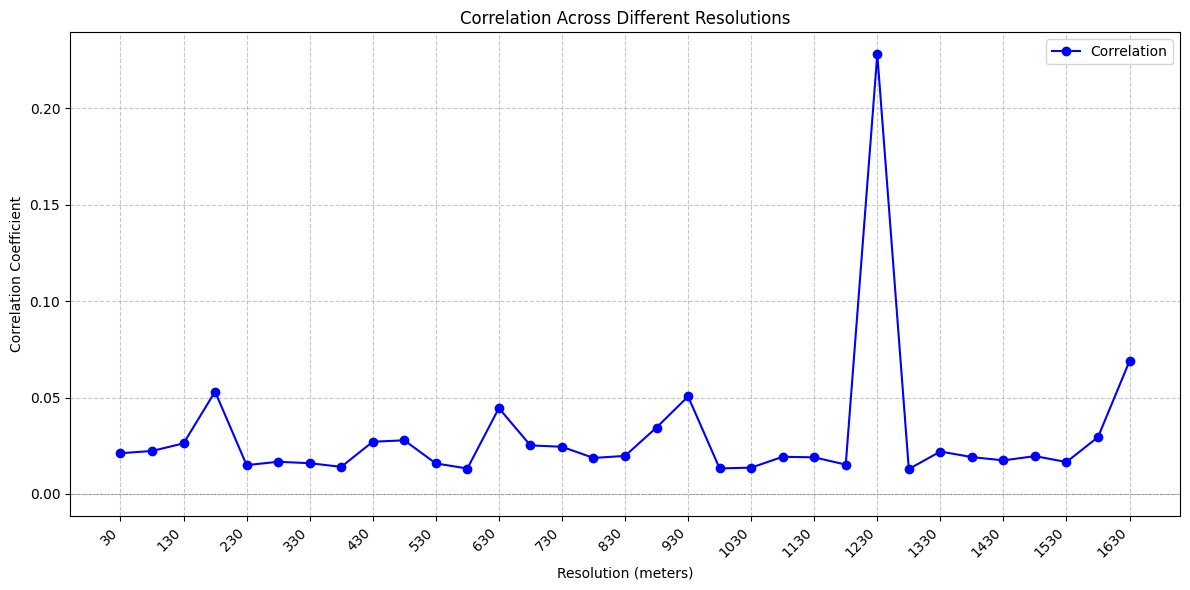

In [ ]:
best_res_impervious_hunits, max_corr_impervious_hunits = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"impervious_hunits"), ground_df,32618,"impervious_hunits")
# 1230
# rf1230


Processing: impervious_vachus_res30.tif
Feature importance improved: 0.0128

Processing: impervious_vachus_res80.tif
Feature importance improved: 0.0164

Processing: impervious_vachus_res130.tif
Feature importance improved: 0.0207

Processing: impervious_vachus_res180.tif
Feature importance improved: 0.0252

Processing: impervious_vachus_res330.tif
Feature importance improved: 0.0287

Processing: impervious_vachus_res830.tif
Feature importance improved: 0.0318

Processing: impervious_vachus_res880.tif
Feature importance improved: 0.0380

Processing: impervious_vachus_res1480.tif
Feature importance improved: 0.2278

Best feature importance found:
Resolution: impervious_vachus_res1480.tif
Feature Importance: 0.2278


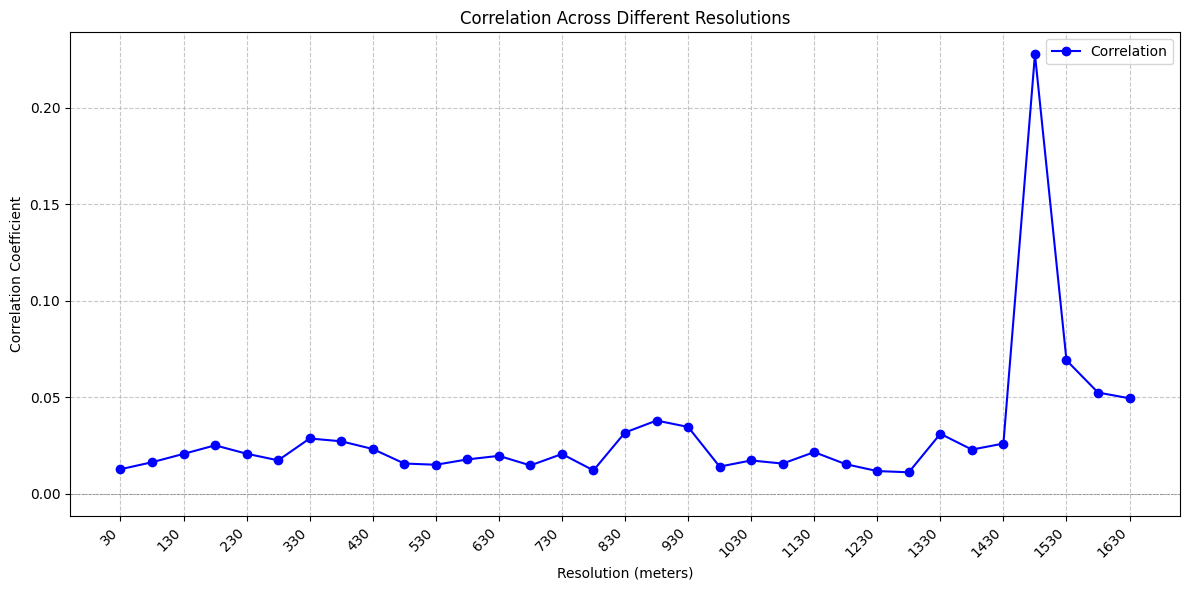

In [ ]:
best_res_impervious_vachus, max_corr_impervious_vachus = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"impervious_vachus"), ground_df,32618,"impervious_vachus")
# 1480
# rf1480


Processing: surfacealbedo_impervious_res30.tif
Feature importance improved: 0.0116

Processing: surfacealbedo_impervious_res80.tif
Feature importance improved: 0.0444

Processing: surfacealbedo_impervious_res830.tif
Feature importance improved: 0.2830

Best feature importance found:
Resolution: surfacealbedo_impervious_res830.tif
Feature Importance: 0.2830


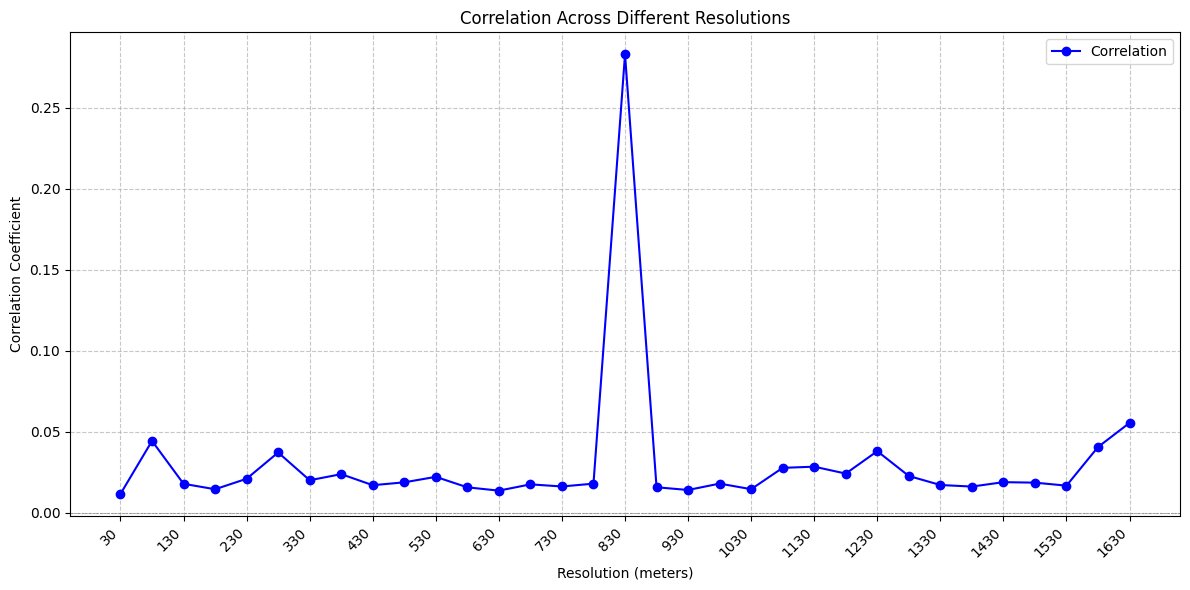

In [ ]:
best_res_surfacealbedo_impervious, max_corr_surfacealbedo_impervious = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"surfacealbedo_impervious"), ground_df,32618,"surfacealbedo_impervious")
# 330
# rf830


Processing: surfacealbedo_buildcove_res30.tif
Feature importance improved: 0.0238

Processing: surfacealbedo_buildcove_res80.tif
Feature importance improved: 0.0285

Processing: surfacealbedo_buildcove_res280.tif
Feature importance improved: 0.0442

Processing: surfacealbedo_buildcove_res880.tif
Feature importance improved: 0.0860

Best feature importance found:
Resolution: surfacealbedo_buildcove_res880.tif
Feature Importance: 0.0860


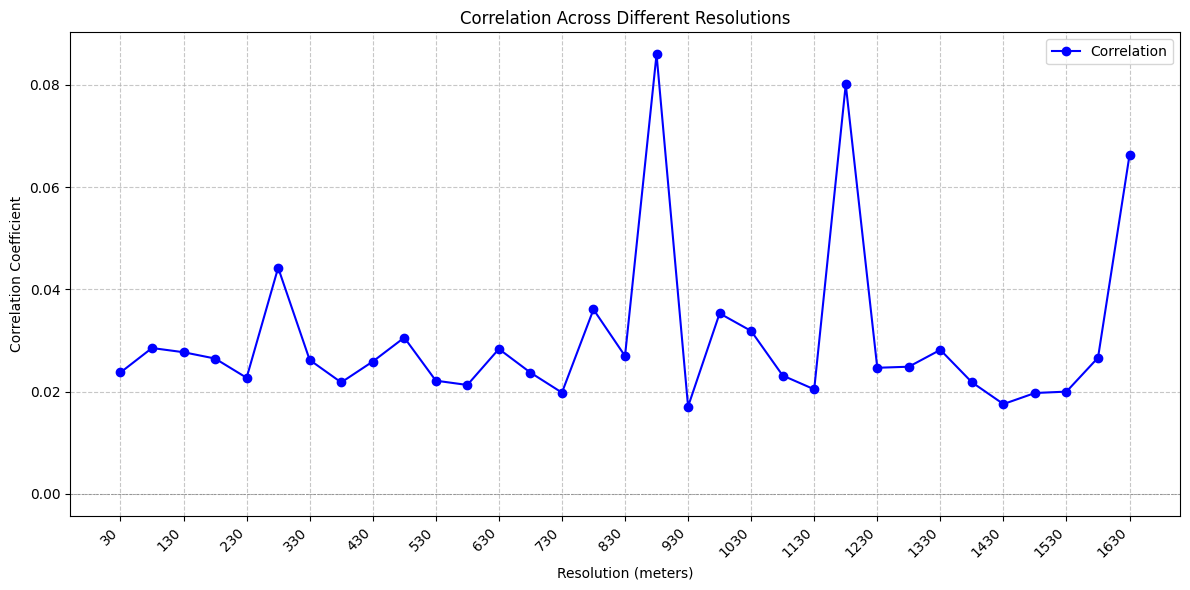

In [ ]:
best_res_surfacealbedo_buildcove, max_corr_surfacealbedo_buildcove = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"surfacealbedo_buildcove"), ground_df,32618,"surfacealbedo_buildcove")
# 1280
# rf880


Processing: surfacealbedo_ndvi_res30.tif
Feature importance improved: 0.0266

Processing: surfacealbedo_ndvi_res80.tif
Feature importance improved: 0.0278

Processing: surfacealbedo_ndvi_res130.tif
Feature importance improved: 0.0328

Processing: surfacealbedo_ndvi_res1030.tif
Feature importance improved: 0.0781

Processing: surfacealbedo_ndvi_res1530.tif
Feature importance improved: 0.1091

Best feature importance found:
Resolution: surfacealbedo_ndvi_res1530.tif
Feature Importance: 0.1091


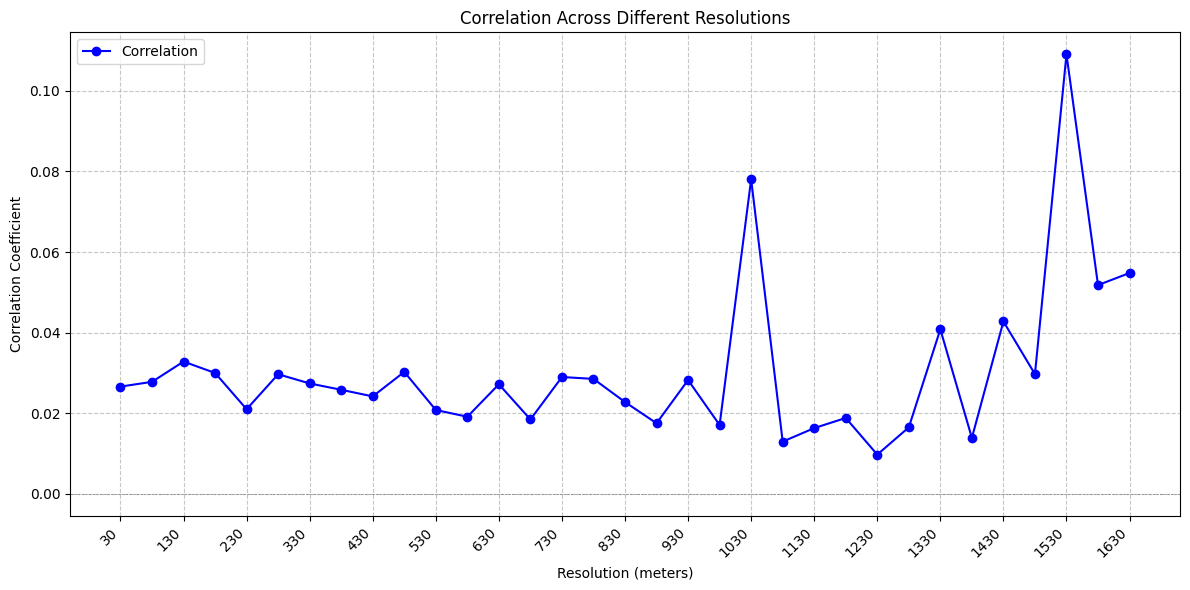

In [ ]:
best_res_surfacealbedo_ndvi, max_corr_surfacealbedo_ndvi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"surfacealbedo_ndvi"), ground_df,32618,"surfacealbedo_ndvi")
# 30
# rf1530


Processing: surfacealbedo_landsatlst_res30.tif
Feature importance improved: 0.0127

Processing: surfacealbedo_landsatlst_res80.tif
Feature importance improved: 0.0197

Processing: surfacealbedo_landsatlst_res230.tif
Feature importance improved: 0.0454

Processing: surfacealbedo_landsatlst_res280.tif
Feature importance improved: 0.0724

Processing: surfacealbedo_landsatlst_res830.tif
Feature importance improved: 0.2277

Best feature importance found:
Resolution: surfacealbedo_landsatlst_res830.tif
Feature Importance: 0.2277


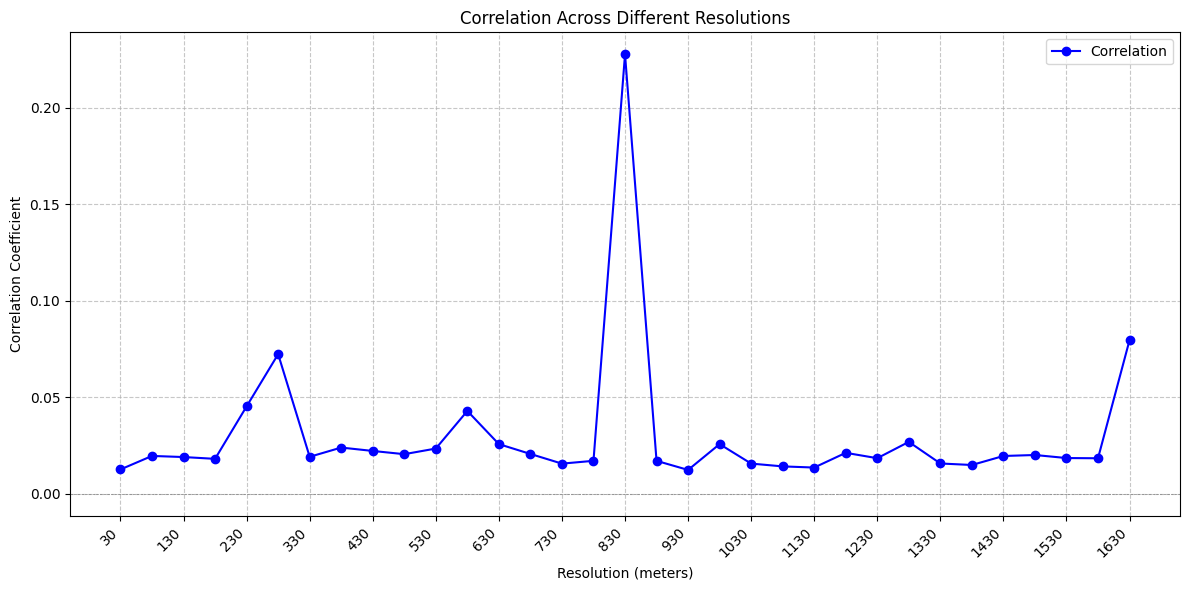

In [ ]:
best_res_surfacealbedo_landsatlst, max_corr_surfacealbedo_landsatlst = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"surfacealbedo_landsatlst"), ground_df,32618,"surfacealbedo_landsatlst")
# 280
# rf830


Processing: surfacealbedo_meanheigh_res30.tif
Feature importance improved: 0.0242

Processing: surfacealbedo_meanheigh_res80.tif
Feature importance improved: 0.0336

Processing: surfacealbedo_meanheigh_res130.tif
Feature importance improved: 0.0338

Processing: surfacealbedo_meanheigh_res280.tif
Feature importance improved: 0.0501

Processing: surfacealbedo_meanheigh_res1130.tif
Feature importance improved: 0.0557

Processing: surfacealbedo_meanheigh_res1380.tif
Feature importance improved: 0.0574

Best feature importance found:
Resolution: surfacealbedo_meanheigh_res1380.tif
Feature Importance: 0.0574


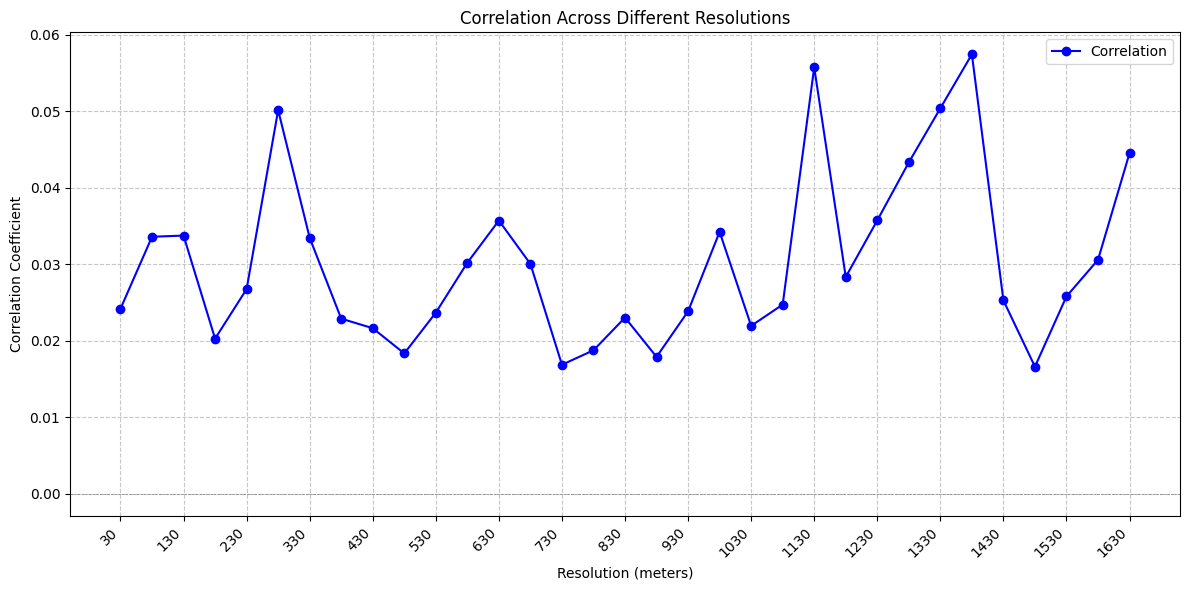

In [ ]:
best_res_surfacealbedo_meanheigh, max_corr_surfacealbedo_meanheigh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"surfacealbedo_meanheigh"), ground_df,32618,"surfacealbedo_meanheigh")
# 880
# rf1380


Processing: surfacealbedo_popdensity_res30.tif
Feature importance improved: 0.0218

Processing: surfacealbedo_popdensity_res80.tif
Feature importance improved: 0.0236

Processing: surfacealbedo_popdensity_res130.tif
Feature importance improved: 0.0550

Processing: surfacealbedo_popdensity_res180.tif
Feature importance improved: 0.0580

Processing: surfacealbedo_popdensity_res1630.tif
Feature importance improved: 0.0620

Best feature importance found:
Resolution: surfacealbedo_popdensity_res1630.tif
Feature Importance: 0.0620


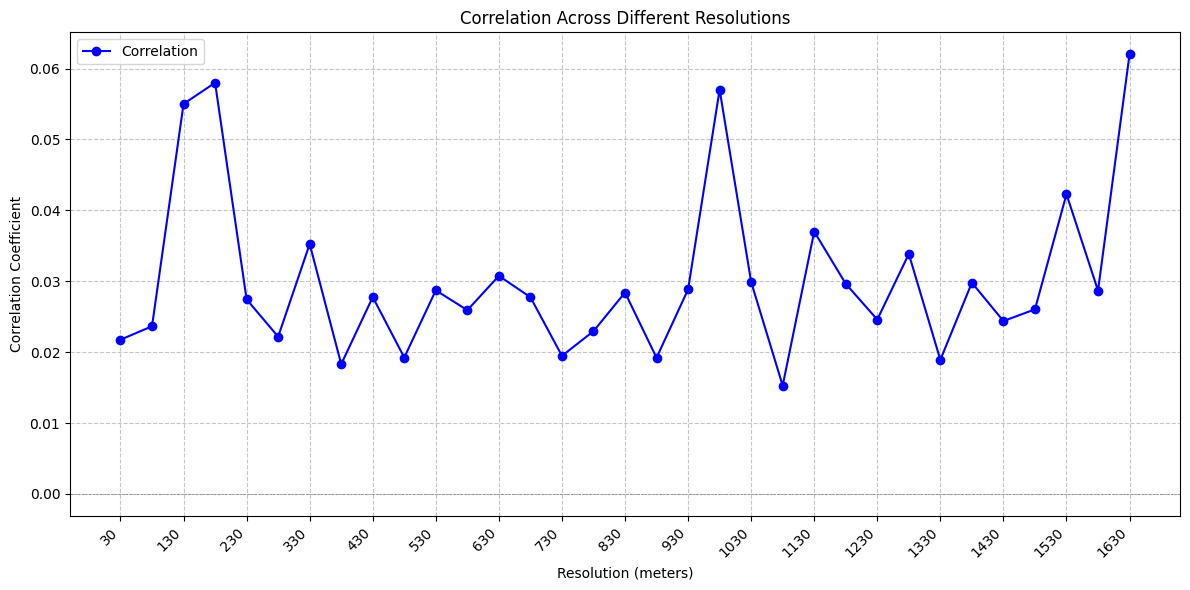

In [ ]:
best_res_surfacealbedo_popdensity, max_corr_surfacealbedo_popdensity = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"surfacealbedo_popdensity"), ground_df,32618,"surfacealbedo_popdensity")
# 880
# rf1630


Processing: dem_forest_hight_res30.tif
Feature importance improved: 0.0062

Processing: dem_forest_hight_res80.tif
Feature importance improved: 0.0656

Processing: dem_forest_hight_res1130.tif
Feature importance improved: 0.1709

Best feature importance found:
Resolution: dem_forest_hight_res1130.tif
Feature Importance: 0.1709


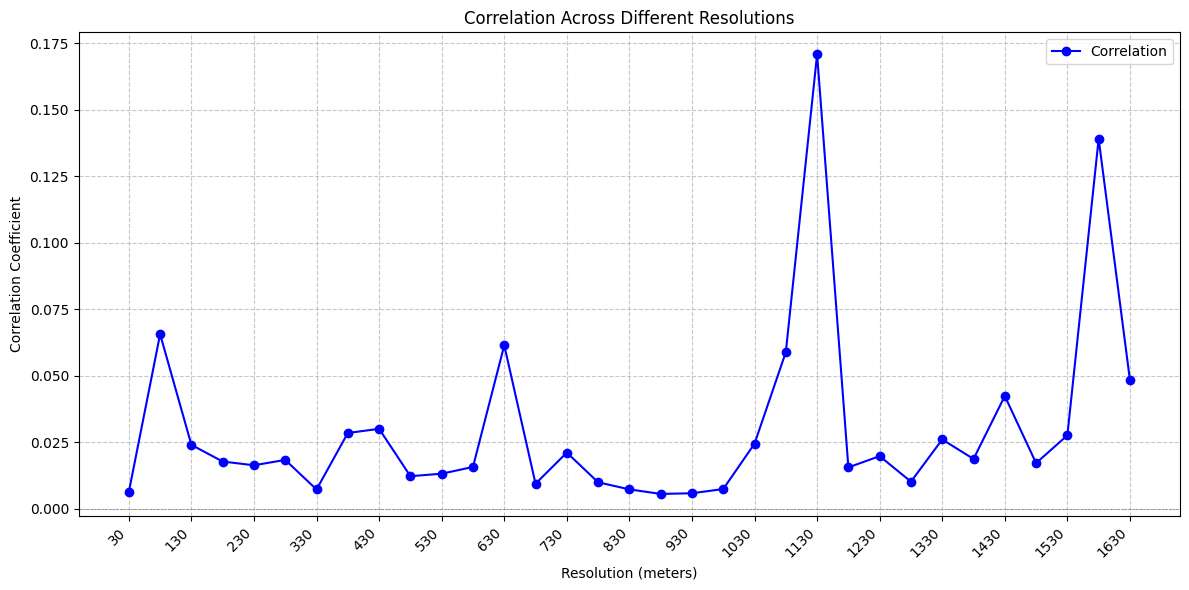

In [ ]:
best_res_dem_forest_hight, max_corr_dem_forest_hight = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"dem_forest_hight"), ground_df,32618,"dem_forest_hight")


Processing: forest_hight_greeness_res30.tif
Feature importance improved: 0.0116

Processing: forest_hight_greeness_res80.tif
Feature importance improved: 0.0120

Processing: forest_hight_greeness_res130.tif
Feature importance improved: 0.0188

Processing: forest_hight_greeness_res180.tif
Feature importance improved: 0.0214

Processing: forest_hight_greeness_res380.tif
Feature importance improved: 0.0344

Processing: forest_hight_greeness_res430.tif
Feature importance improved: 0.0494

Processing: forest_hight_greeness_res1380.tif
Feature importance improved: 0.1088

Processing: forest_hight_greeness_res1630.tif
Feature importance improved: 0.1362

Best feature importance found:
Resolution: forest_hight_greeness_res1630.tif
Feature Importance: 0.1362


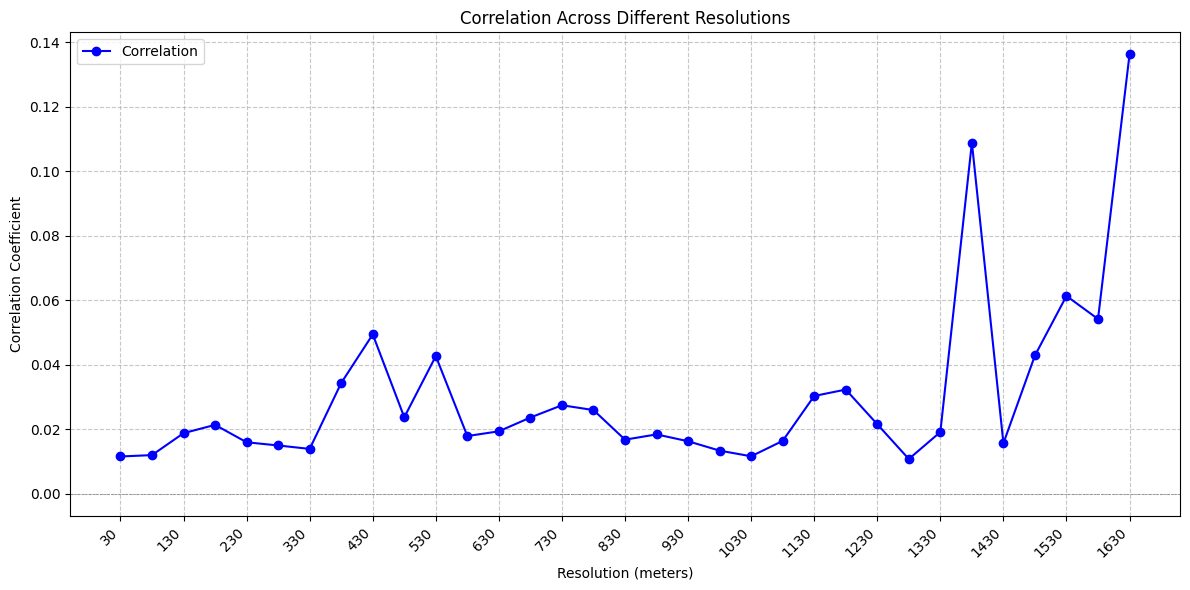

In [ ]:
best_res_forest_hight_greeness, max_corr_forest_hight_greeness = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"forest_hight_greeness"), ground_df,32618,"forest_hight_greeness")


Processing: forest_hight_ndbi_res30.tif
Feature importance improved: 0.0048

Processing: forest_hight_ndbi_res80.tif
Feature importance improved: 0.0136

Processing: forest_hight_ndbi_res180.tif
Feature importance improved: 0.0216

Processing: forest_hight_ndbi_res380.tif
Feature importance improved: 0.0327

Processing: forest_hight_ndbi_res480.tif
Feature importance improved: 0.0533

Processing: forest_hight_ndbi_res1380.tif
Feature importance improved: 0.1449

Best feature importance found:
Resolution: forest_hight_ndbi_res1380.tif
Feature Importance: 0.1449


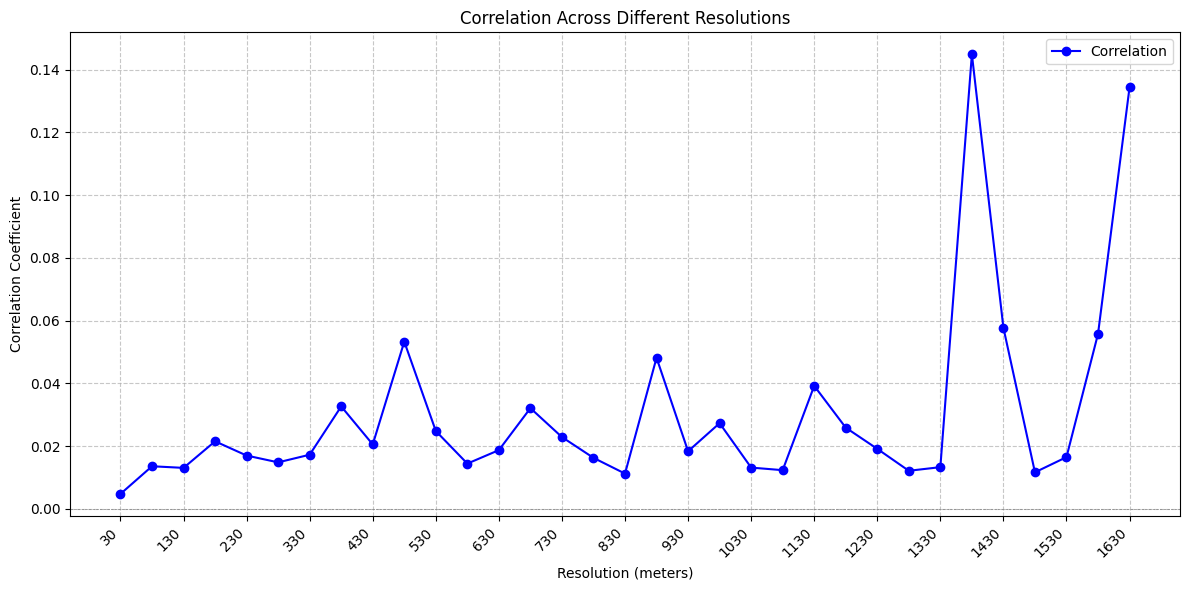

In [ ]:
best_res_forest_hight_ndbi, max_corr_forest_hight_ndbi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path,"forest_hight_ndbi"), ground_df,32618,"forest_hight_ndbi")

### Optimal Resolution for Experimental Interaction


Processing: anh_build_dens_res30.tif
Feature importance improved: 0.0134

Processing: anh_build_dens_res80.tif
Feature importance improved: 0.0227

Processing: anh_build_dens_res380.tif
Feature importance improved: 0.0390

Processing: anh_build_dens_res1230.tif
Feature importance improved: 0.0609

Processing: anh_build_dens_res1280.tif
Feature importance improved: 0.2453

Best feature importance found:
Resolution: anh_build_dens_res1280.tif
Feature Importance: 0.2453


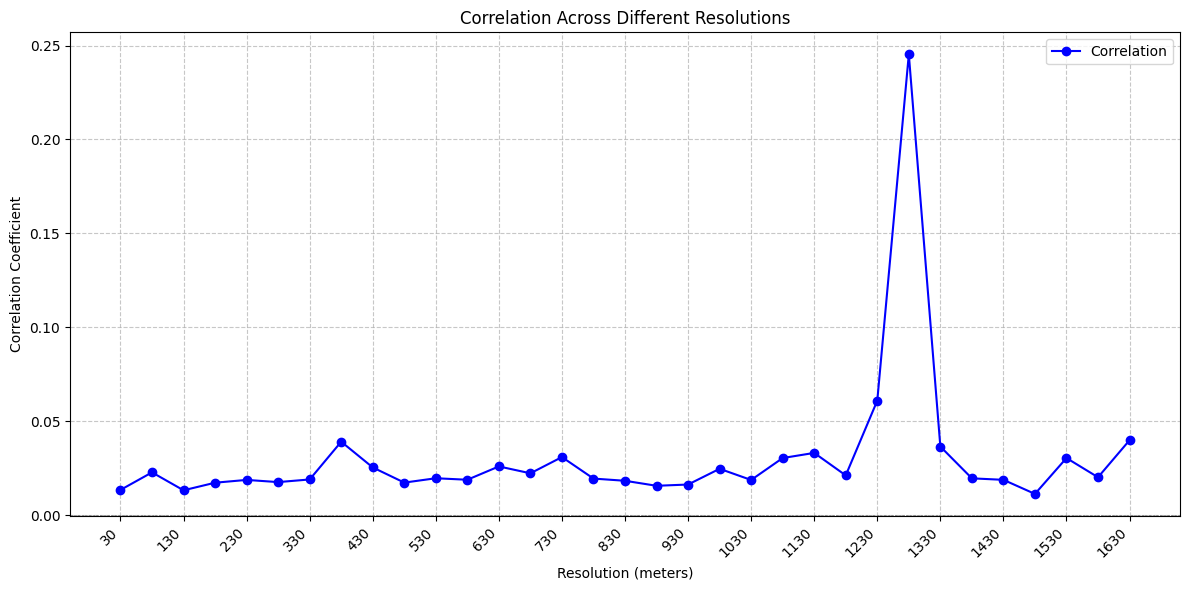

In [ ]:
best_res_anh_build_dens, max_corr_anh_build_dens = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "anh_build_dens"), ground_df, 32618, "anh_build_dens")
# 1080
# rf1530


Processing: anh_popdensity_res30.tif
Feature importance improved: 0.0149

Processing: anh_popdensity_res80.tif
Feature importance improved: 0.0191

Processing: anh_popdensity_res230.tif
Feature importance improved: 0.0401

Processing: anh_popdensity_res1630.tif
Feature importance improved: 0.4037

Best feature importance found:
Resolution: anh_popdensity_res1630.tif
Feature Importance: 0.4037


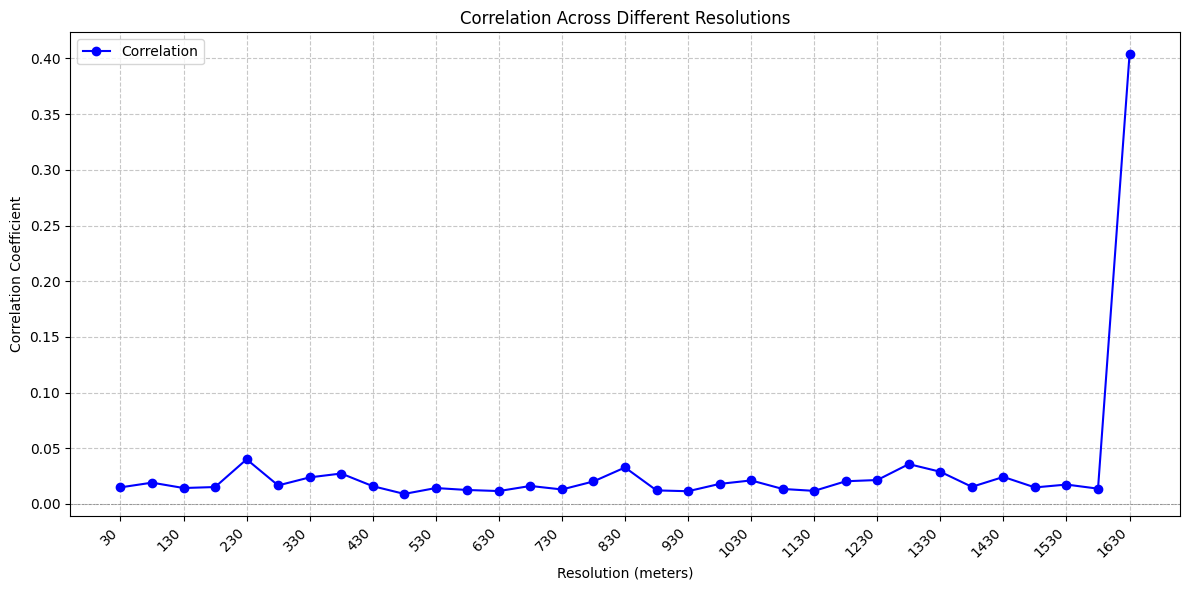

In [ ]:
best_res_anh_popdensity, max_corr_anh_popdensity = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "anh_popdensity"), ground_df, 32618, "anh_popdensity")
# 880
# rf1630


Processing: b12_ndbi_res30.tif
Feature importance improved: 0.0201

Processing: b12_ndbi_res230.tif
Feature importance improved: 0.0232

Processing: b12_ndbi_res430.tif
Feature importance improved: 0.0281

Processing: b12_ndbi_res1080.tif
Feature importance improved: 0.0286

Processing: b12_ndbi_res1230.tif
Feature importance improved: 0.0435

Processing: b12_ndbi_res1330.tif
Feature importance improved: 0.2796

Best feature importance found:
Resolution: b12_ndbi_res1330.tif
Feature Importance: 0.2796


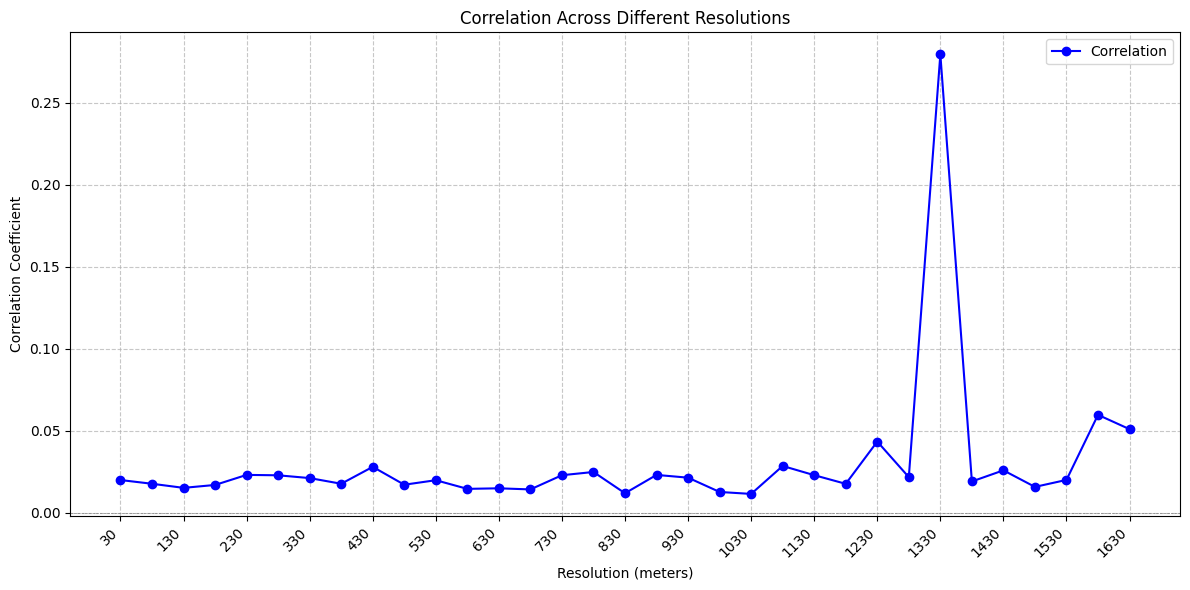

In [ ]:
best_res_b12_ndbi, max_corr_b12_ndbi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "b12_ndbi"), ground_df, 32618, "b12_ndbi")
# 1380
# rf1330


Processing: b12_ndli_res30.tif
Feature importance improved: 0.0597

Processing: b12_ndli_res1530.tif
Feature importance improved: 0.0896

Best feature importance found:
Resolution: b12_ndli_res1530.tif
Feature Importance: 0.0896


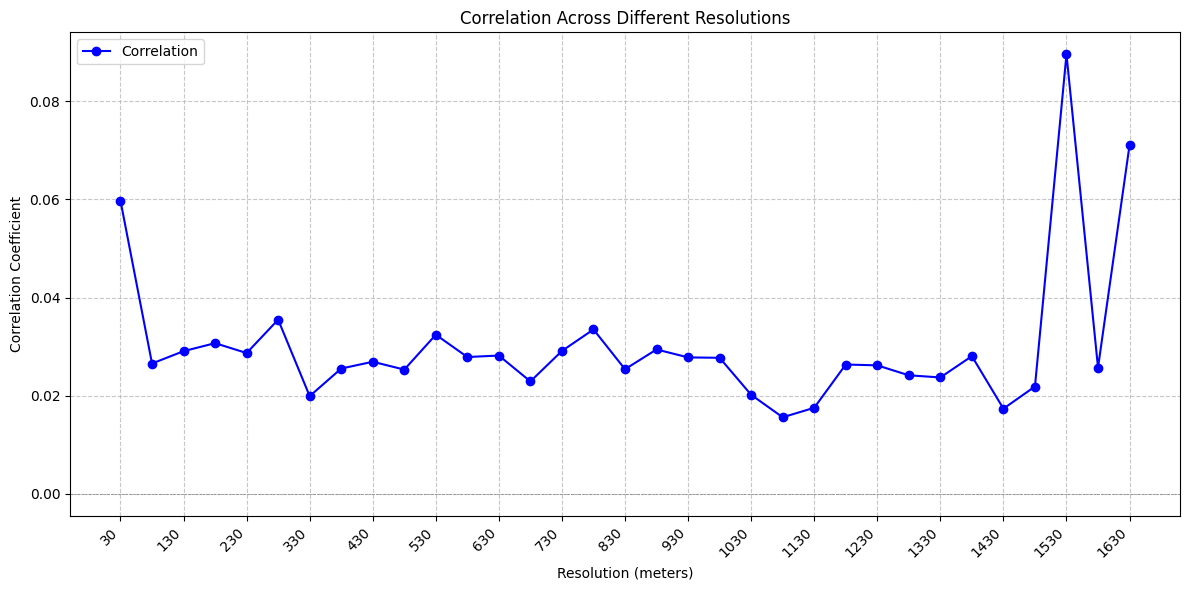

In [ ]:
best_res_b12_ndli, max_corr_b12_ndli = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "b12_ndli"), ground_df, 32618, "b12_ndli")
# 30
# rf1530


Processing: b4_ndli_res30.tif
Feature importance improved: 0.0754

Processing: b4_ndli_res980.tif
Feature importance improved: 0.0883

Best feature importance found:
Resolution: b4_ndli_res980.tif
Feature Importance: 0.0883


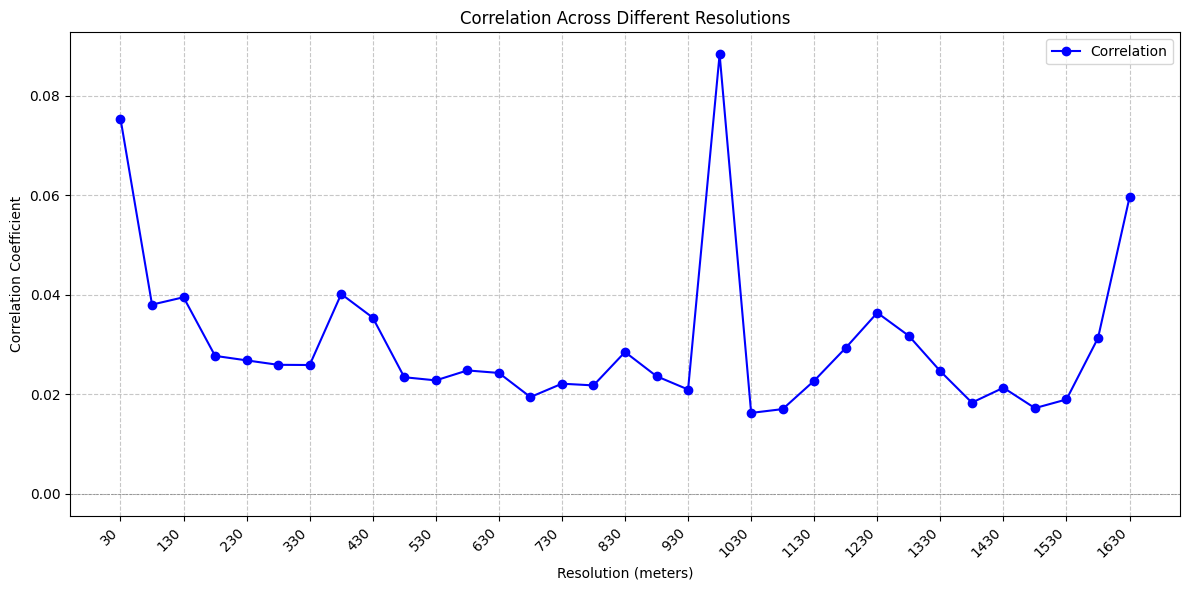

In [ ]:
best_res_b4_ndli, max_corr_b4_ndli = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "b4_ndli"), ground_df, 32618, "b4_ndli")
# 30
# rf980


Processing: bnh_greeness_res30.tif
Feature importance improved: 0.0042

Processing: bnh_greeness_res80.tif
Feature importance improved: 0.0122

Processing: bnh_greeness_res130.tif
Feature importance improved: 0.0271

Processing: bnh_greeness_res280.tif
Feature importance improved: 0.0367

Processing: bnh_greeness_res830.tif
Feature importance improved: 0.0379

Processing: bnh_greeness_res1030.tif
Feature importance improved: 0.0721

Processing: bnh_greeness_res1630.tif
Feature importance improved: 0.2325

Best feature importance found:
Resolution: bnh_greeness_res1630.tif
Feature Importance: 0.2325


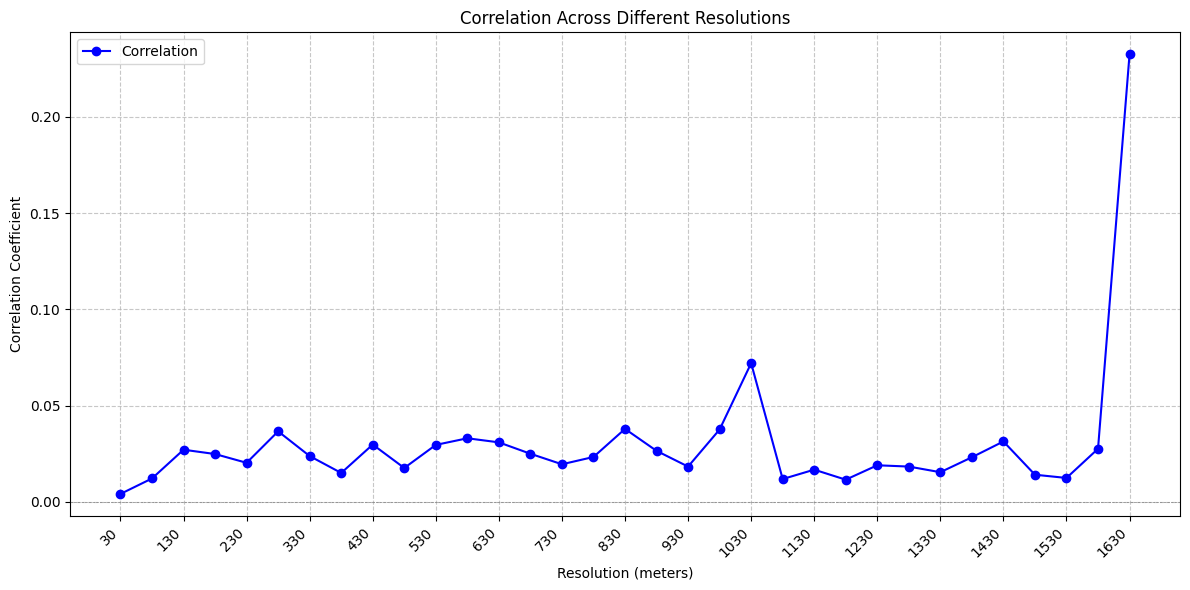

In [ ]:
best_res_bnh_greeness, max_corr_bnh_greeness = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "bnh_greeness"), ground_df, 32618, "bnh_greeness")
# 1430
# rf1580


Processing: build_cove_hunits_res30.tif
Feature importance improved: 0.0091

Processing: build_cove_hunits_res80.tif
Feature importance improved: 0.0223

Processing: build_cove_hunits_res280.tif
Feature importance improved: 0.0255

Processing: build_cove_hunits_res330.tif
Feature importance improved: 0.0267

Processing: build_cove_hunits_res680.tif
Feature importance improved: 0.0385

Processing: build_cove_hunits_res1430.tif
Feature importance improved: 0.0445

Processing: build_cove_hunits_res1480.tif
Feature importance improved: 0.0624

Processing: build_cove_hunits_res1530.tif
Feature importance improved: 0.2623

Best feature importance found:
Resolution: build_cove_hunits_res1530.tif
Feature Importance: 0.2623


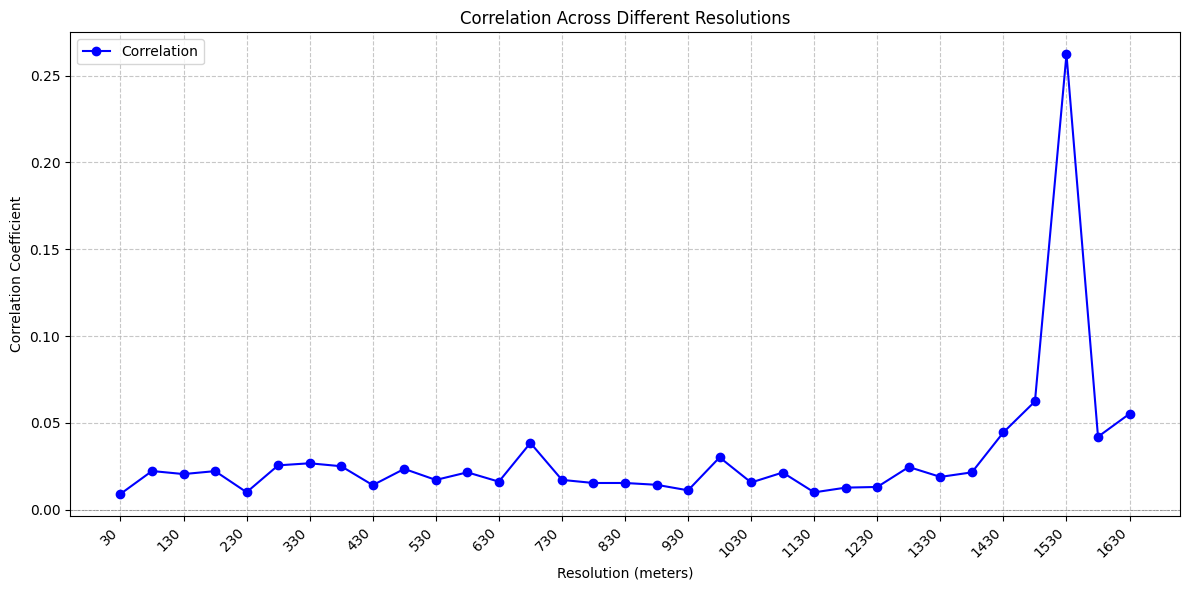

In [ ]:
best_res_build_cove_hunits, max_corr_build_cove_hunits = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "build_cove_hunits"), ground_df, 32618, "build_cove_hunits")
# 1180
# rf1530


Processing: build_cove_pop65pl_res30.tif
Feature importance improved: 0.0139

Processing: build_cove_pop65pl_res80.tif
Feature importance improved: 0.0220

Processing: build_cove_pop65pl_res130.tif
Feature importance improved: 0.0609

Processing: build_cove_pop65pl_res1480.tif
Feature importance improved: 0.3237

Best feature importance found:
Resolution: build_cove_pop65pl_res1480.tif
Feature Importance: 0.3237


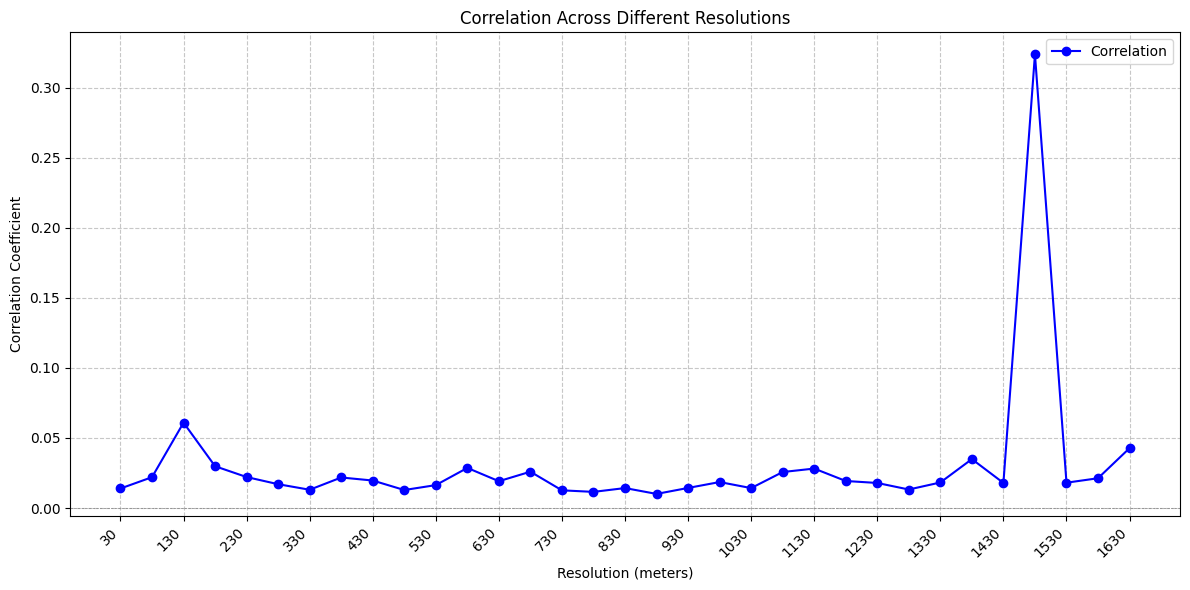

In [ ]:
best_res_build_cove_pop65pl, max_corr_build_cove_pop65pl = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "build_cove_pop65pl"), ground_df, 32618, "build_cove_pop65pl")
# 480
# rf1480


Processing: build_dens_hunits_res30.tif
Feature importance improved: 0.0120

Processing: build_dens_hunits_res80.tif
Feature importance improved: 0.0214

Processing: build_dens_hunits_res680.tif
Feature importance improved: 0.0238

Processing: build_dens_hunits_res730.tif
Feature importance improved: 0.0302

Processing: build_dens_hunits_res930.tif
Feature importance improved: 0.0606

Processing: build_dens_hunits_res1380.tif
Feature importance improved: 0.1380

Processing: build_dens_hunits_res1530.tif
Feature importance improved: 0.1990

Best feature importance found:
Resolution: build_dens_hunits_res1530.tif
Feature Importance: 0.1990


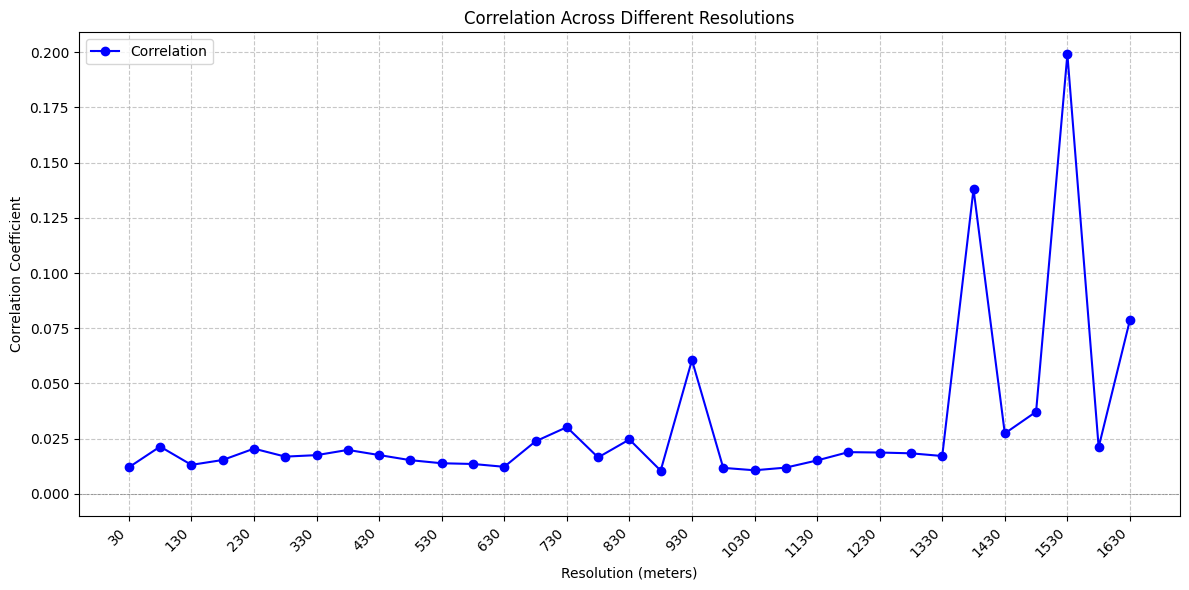

In [ ]:
best_res_build_dens_hunits, max_corr_build_dens_hunits = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "build_dens_hunits"), ground_df, 32618, "build_dens_hunits")
# 980
# rf1530


Processing: build_dens_pop65pl_res30.tif
Feature importance improved: 0.0214

Processing: build_dens_pop65pl_res80.tif
Feature importance improved: 0.0225

Processing: build_dens_pop65pl_res130.tif
Feature importance improved: 0.0437

Processing: build_dens_pop65pl_res1430.tif
Feature importance improved: 0.0755

Processing: build_dens_pop65pl_res1630.tif
Feature importance improved: 0.3064

Best feature importance found:
Resolution: build_dens_pop65pl_res1630.tif
Feature Importance: 0.3064


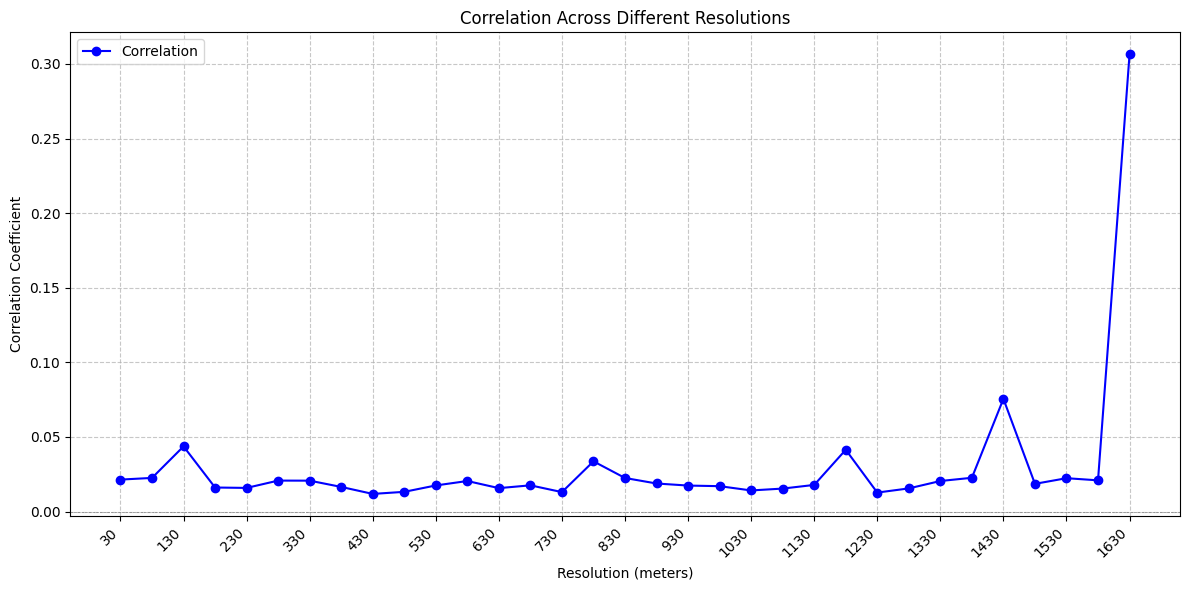

In [ ]:
best_res_build_dens_pop65pl, max_corr_build_dens_pop65pl = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "build_dens_pop65pl"), ground_df, 32618, "build_dens_pop65pl")
# 1480
# rf1430


Processing: build_dens_twopinh_res30.tif
Feature importance improved: 0.0225

Processing: build_dens_twopinh_res80.tif
Feature importance improved: 0.0242

Processing: build_dens_twopinh_res680.tif
Feature importance improved: 0.0482

Processing: build_dens_twopinh_res980.tif
Feature importance improved: 0.0700

Processing: build_dens_twopinh_res1030.tif
Feature importance improved: 0.1252

Best feature importance found:
Resolution: build_dens_twopinh_res1030.tif
Feature Importance: 0.1252


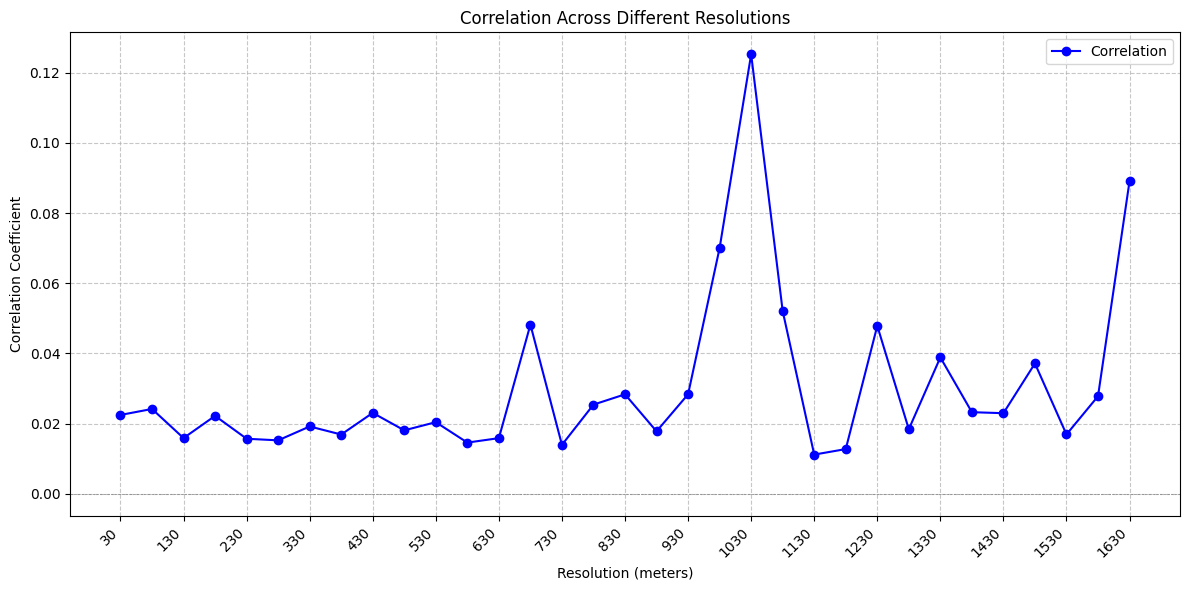

In [ ]:
best_res_build_dens_twopinh, max_corr_build_dens_twopinh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "build_dens_twopinh"), ground_df, 32618, "build_dens_twopinh")
# 780
# rf1030


Processing: build_dens_vachus_res30.tif
Feature importance improved: 0.0247

Processing: build_dens_vachus_res630.tif
Feature importance improved: 0.0360

Processing: build_dens_vachus_res830.tif
Feature importance improved: 0.0366

Processing: build_dens_vachus_res1280.tif
Feature importance improved: 0.0465

Processing: build_dens_vachus_res1530.tif
Feature importance improved: 0.1599

Processing: build_dens_vachus_res1630.tif
Feature importance improved: 0.1711

Best feature importance found:
Resolution: build_dens_vachus_res1630.tif
Feature Importance: 0.1711


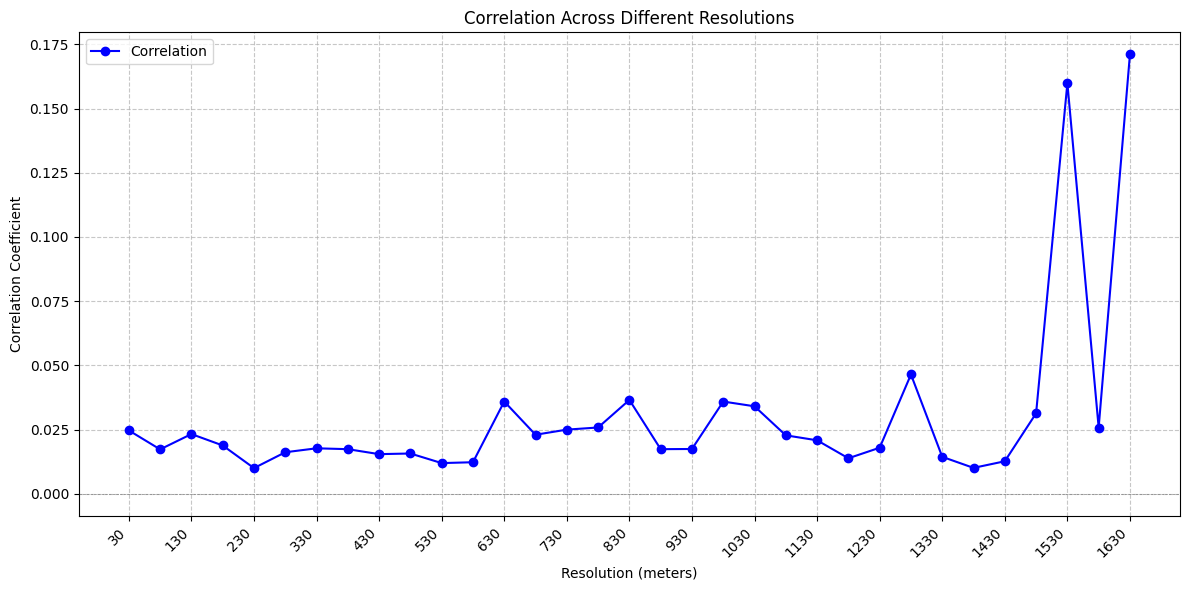

In [ ]:
best_res_build_dens_vachus, max_corr_build_dens_vachus = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "build_dens_vachus"), ground_df, 32618, "build_dens_vachus")
# 630
# rf1630


Processing: build_dens_wnh_res30.tif
Feature importance improved: 0.0116

Processing: build_dens_wnh_res80.tif
Feature importance improved: 0.0161

Processing: build_dens_wnh_res130.tif
Feature importance improved: 0.0206

Processing: build_dens_wnh_res180.tif
Feature importance improved: 0.0212

Processing: build_dens_wnh_res880.tif
Feature importance improved: 0.0321

Processing: build_dens_wnh_res930.tif
Feature importance improved: 0.0359

Processing: build_dens_wnh_res980.tif
Feature importance improved: 0.0463

Processing: build_dens_wnh_res1280.tif
Feature importance improved: 0.1942

Best feature importance found:
Resolution: build_dens_wnh_res1280.tif
Feature Importance: 0.1942


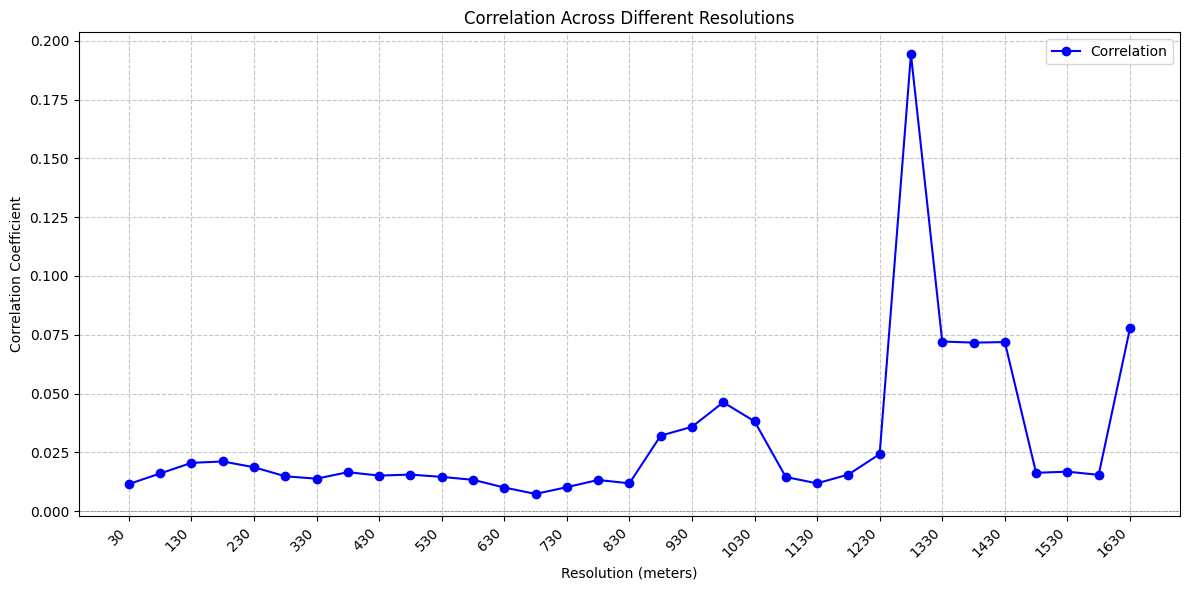

In [ ]:
best_res_build_dens_wnh, max_corr_build_dens_wnh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "build_dens_wnh"), ground_df, 32618, "build_dens_wnh")
# 1480
# rf1530


Processing: dem_mean_heigh_res30.tif
Feature importance improved: 0.0221

Processing: dem_mean_heigh_res130.tif
Feature importance improved: 0.0228

Processing: dem_mean_heigh_res230.tif
Feature importance improved: 0.0255

Processing: dem_mean_heigh_res430.tif
Feature importance improved: 0.0353

Processing: dem_mean_heigh_res580.tif
Feature importance improved: 0.0592

Processing: dem_mean_heigh_res630.tif
Feature importance improved: 0.0676

Processing: dem_mean_heigh_res1480.tif
Feature importance improved: 0.1390

Best feature importance found:
Resolution: dem_mean_heigh_res1480.tif
Feature Importance: 0.1390


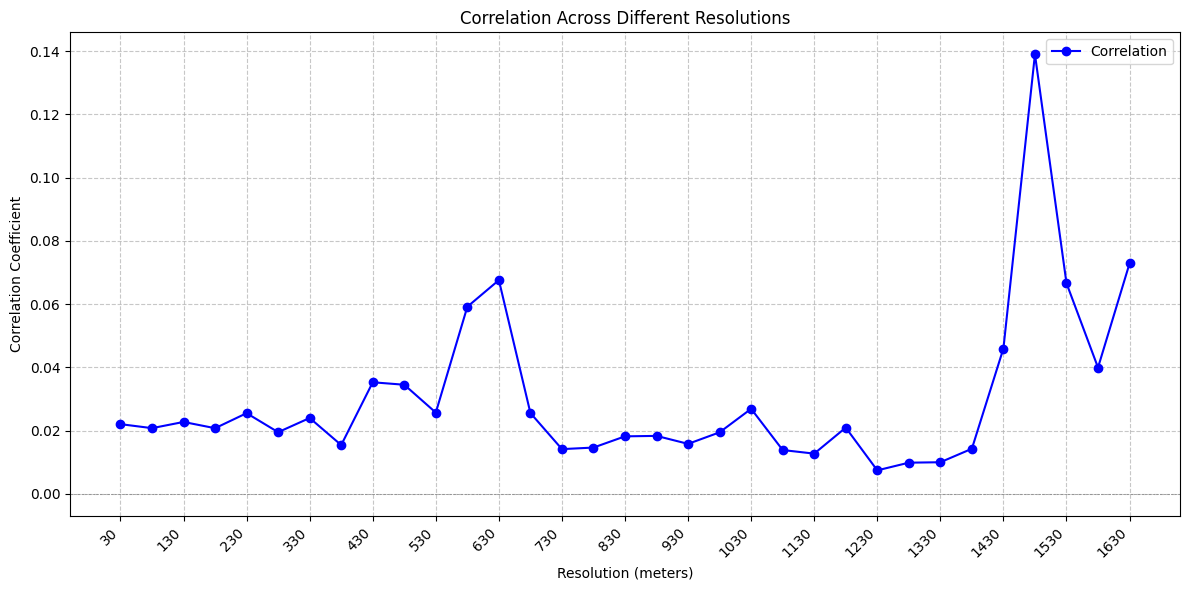

In [ ]:
best_res_dem_mean_heigh, max_corr_dem_mean_heigh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "dem_mean_heigh"), ground_df, 32618, "dem_mean_heigh")
# 1480
# rf1480


Processing: dem_ndli_res30.tif
Feature importance improved: 0.0161

Processing: dem_ndli_res80.tif
Feature importance improved: 0.0345

Processing: dem_ndli_res780.tif
Feature importance improved: 0.0371

Processing: dem_ndli_res1030.tif
Feature importance improved: 0.0758

Processing: dem_ndli_res1380.tif
Feature importance improved: 0.1682

Best feature importance found:
Resolution: dem_ndli_res1380.tif
Feature Importance: 0.1682


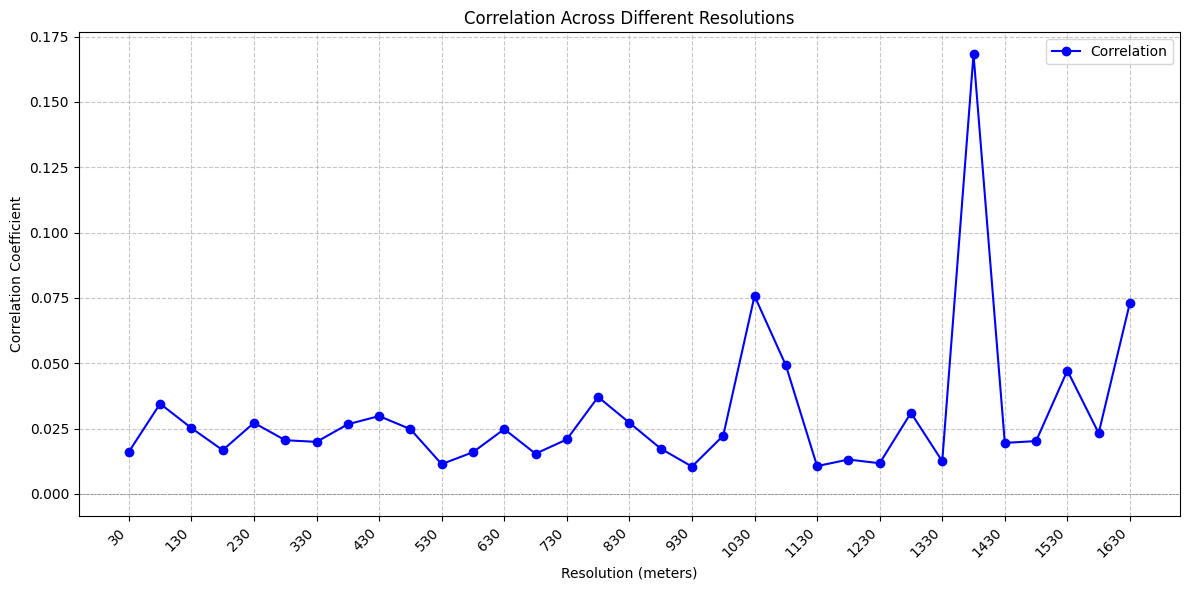

In [ ]:
best_res_dem_ndli, max_corr_dem_ndli = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "dem_ndli"), ground_df, 32618, "dem_ndli")
# 80
# rf1380


Processing: dem_ndvi_res30.tif
Feature importance improved: 0.0146

Processing: dem_ndvi_res80.tif
Feature importance improved: 0.0347

Processing: dem_ndvi_res730.tif
Feature importance improved: 0.0419

Processing: dem_ndvi_res1030.tif
Feature importance improved: 0.0658

Processing: dem_ndvi_res1430.tif
Feature importance improved: 0.1246

Best feature importance found:
Resolution: dem_ndvi_res1430.tif
Feature Importance: 0.1246


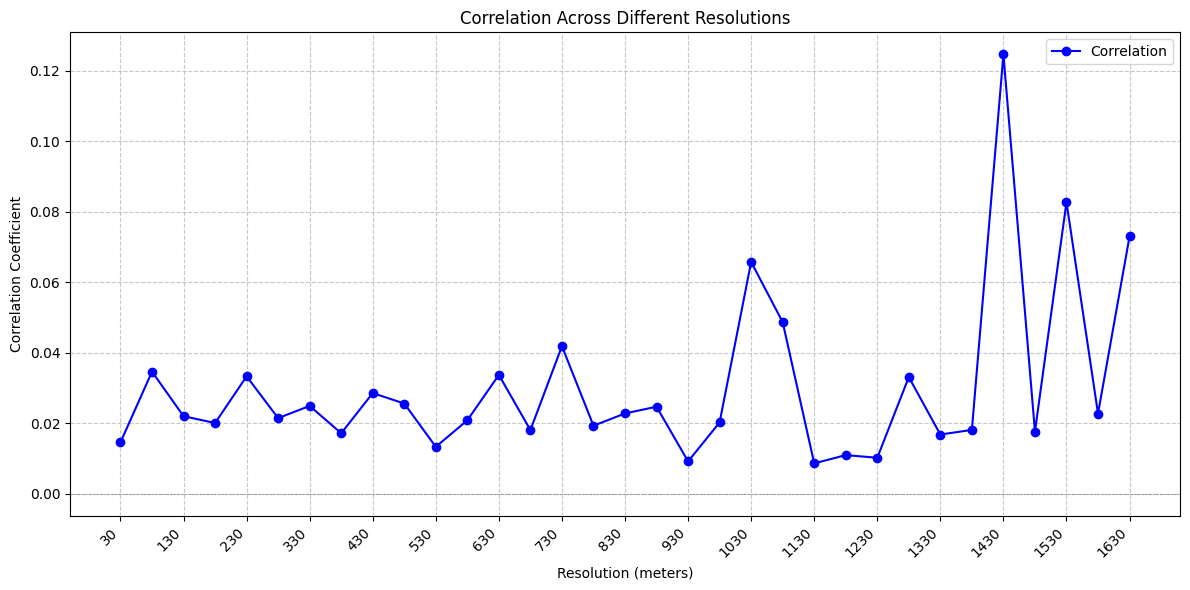

In [ ]:
best_res_dem_ndvi, max_corr_dem_ndvi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "dem_ndvi"), ground_df, 32618, "dem_ndvi")
# 80
# rf1430


Processing: dem_ndwi_res30.tif
Feature importance improved: 0.0379

Processing: dem_ndwi_res430.tif
Feature importance improved: 0.0387

Processing: dem_ndwi_res480.tif
Feature importance improved: 0.0440

Processing: dem_ndwi_res1130.tif
Feature importance improved: 0.0560

Processing: dem_ndwi_res1380.tif
Feature importance improved: 0.0742

Processing: dem_ndwi_res1430.tif
Feature importance improved: 0.1253

Best feature importance found:
Resolution: dem_ndwi_res1430.tif
Feature Importance: 0.1253


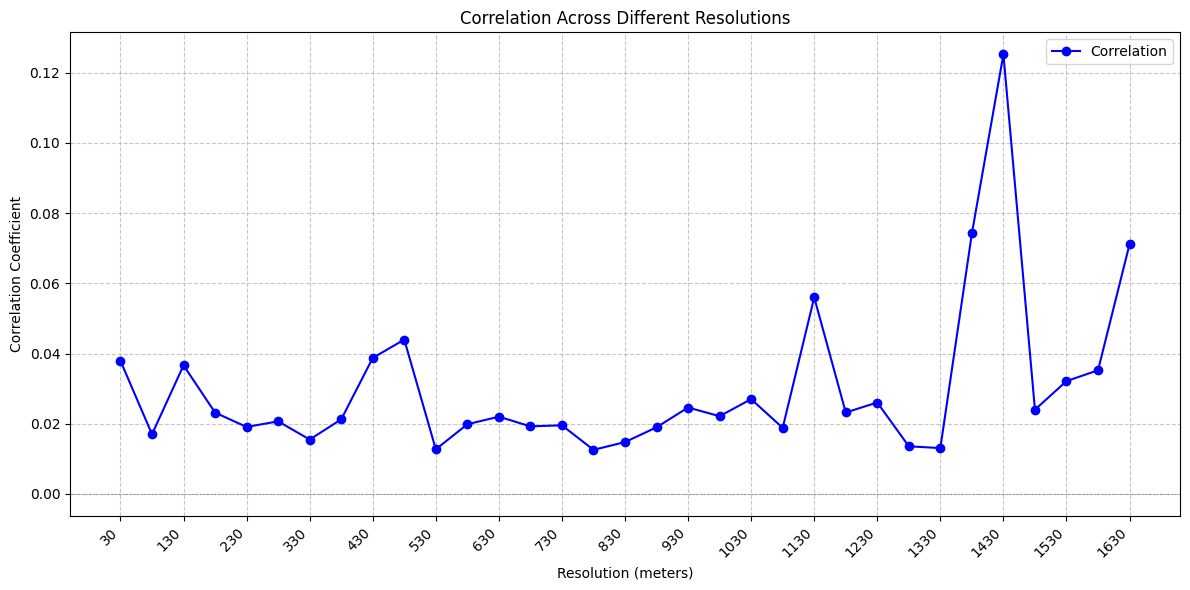

In [ ]:
best_res_dem_ndwi, max_corr_dem_ndwi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "dem_ndwi"), ground_df, 32618, "dem_ndwi")
# 30
# rf1430


Processing: dem_popdensity_res30.tif
Feature importance improved: 0.0249

Processing: dem_popdensity_res80.tif
Feature importance improved: 0.0304

Processing: dem_popdensity_res130.tif
Feature importance improved: 0.0328

Processing: dem_popdensity_res580.tif
Feature importance improved: 0.0365

Processing: dem_popdensity_res680.tif
Feature importance improved: 0.0555

Processing: dem_popdensity_res1530.tif
Feature importance improved: 0.0625

Processing: dem_popdensity_res1630.tif
Feature importance improved: 0.1236

Best feature importance found:
Resolution: dem_popdensity_res1630.tif
Feature Importance: 0.1236


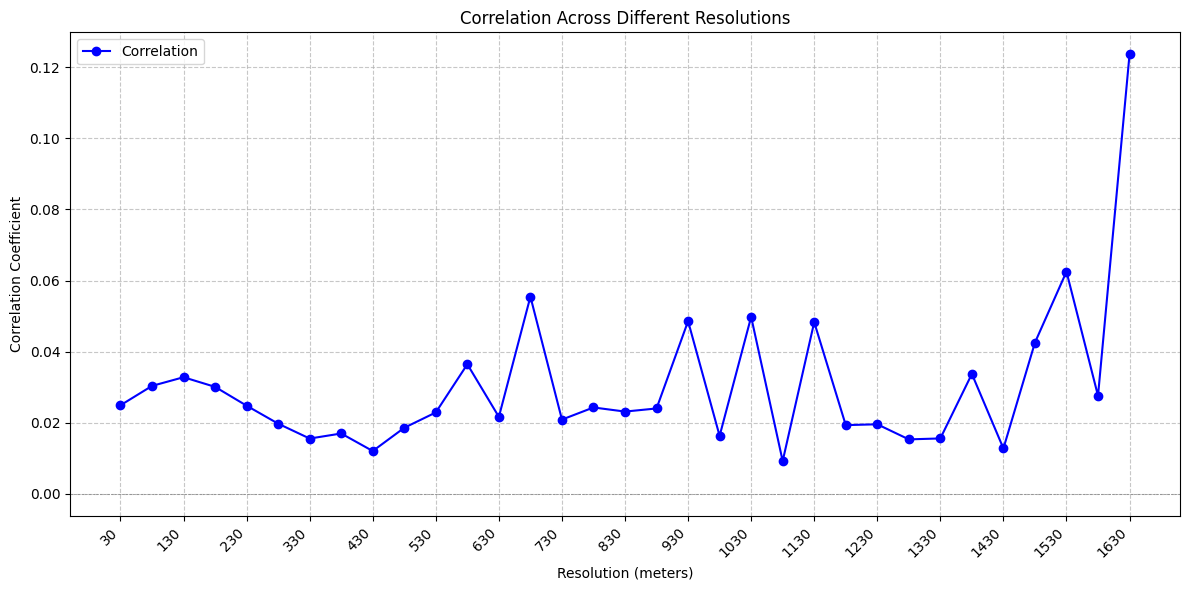

In [ ]:
best_res_dem_popdensity, max_corr_dem_popdensity = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "dem_popdensity"), ground_df, 32618, "dem_popdensity")
# 930
# rf1630


Processing: dem_twopinh_res30.tif
Feature importance improved: 0.0143

Processing: dem_twopinh_res80.tif
Feature importance improved: 0.0174

Processing: dem_twopinh_res130.tif
Feature importance improved: 0.0312

Processing: dem_twopinh_res180.tif
Feature importance improved: 0.0567

Processing: dem_twopinh_res780.tif
Feature importance improved: 0.0747

Processing: dem_twopinh_res1630.tif
Feature importance improved: 0.2835

Best feature importance found:
Resolution: dem_twopinh_res1630.tif
Feature Importance: 0.2835


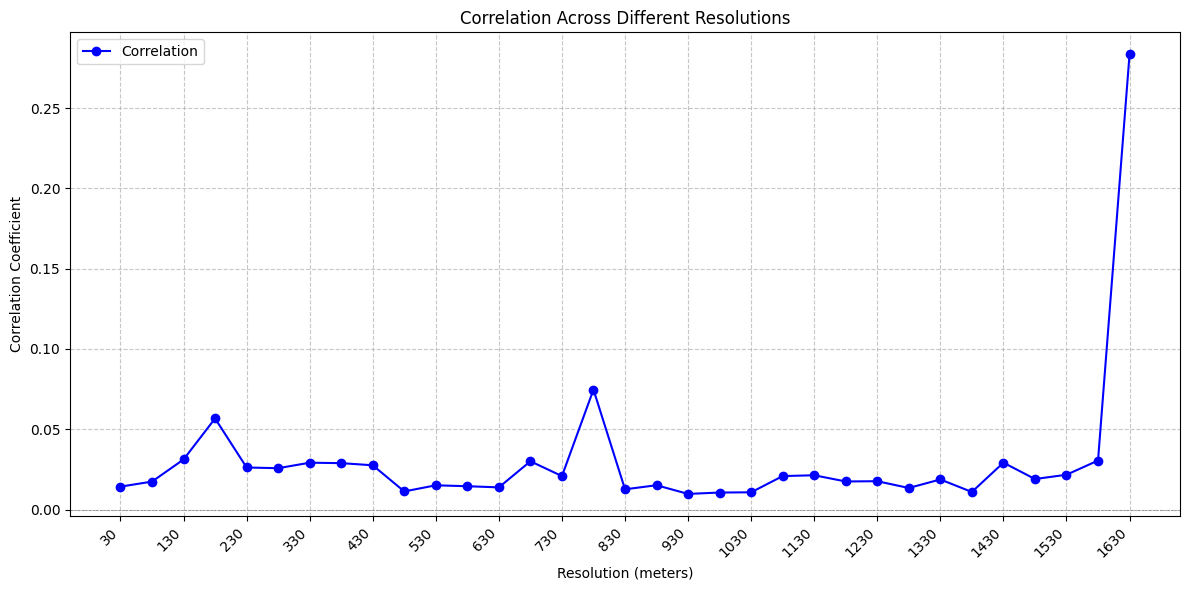

In [ ]:
best_res_dem_twopinh, max_corr_dem_twopinh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "dem_twopinh"), ground_df, 32618, "dem_twopinh")
# 80
# rf1630


Processing: dem_wnh_res30.tif
Feature importance improved: 0.0192

Processing: dem_wnh_res80.tif
Feature importance improved: 0.0300

Processing: dem_wnh_res130.tif
Feature importance improved: 0.0313

Processing: dem_wnh_res380.tif
Feature importance improved: 0.0543

Processing: dem_wnh_res630.tif
Feature importance improved: 0.0656

Processing: dem_wnh_res1630.tif
Feature importance improved: 0.3553

Best feature importance found:
Resolution: dem_wnh_res1630.tif
Feature Importance: 0.3553


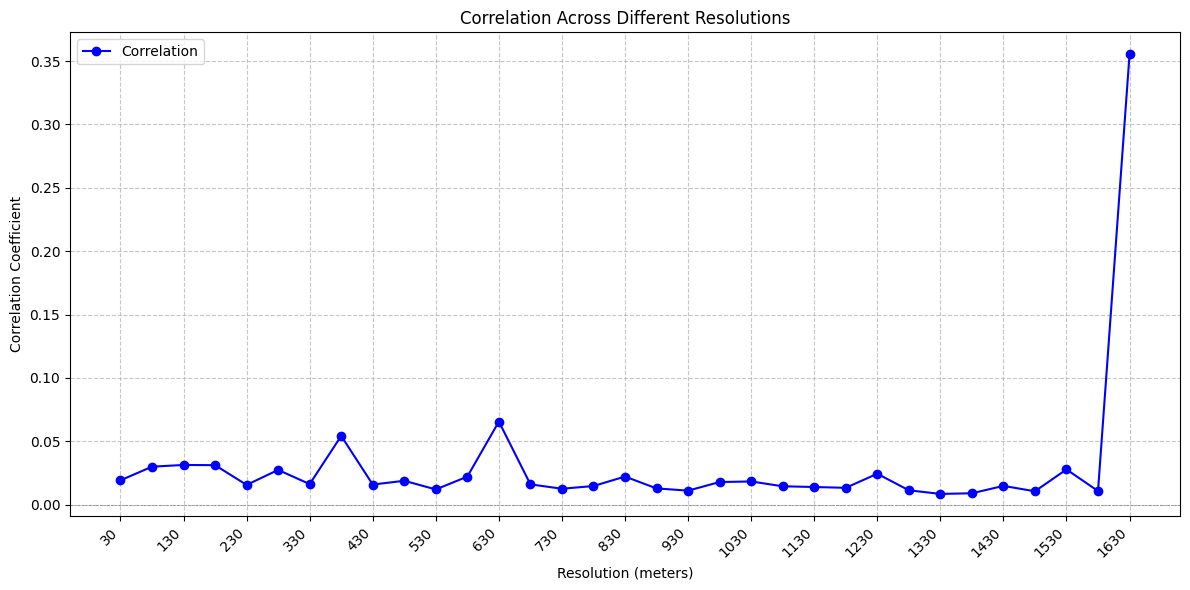

In [ ]:
best_res_dem_wnh, max_corr_dem_wnh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "dem_wnh"), ground_df, 32618, "dem_wnh")
# 1480
# rf1630


Processing: greeness_hsp1_res30.tif
Feature importance improved: 0.0162

Processing: greeness_hsp1_res130.tif
Feature importance improved: 0.0227

Processing: greeness_hsp1_res230.tif
Feature importance improved: 0.0246

Processing: greeness_hsp1_res330.tif
Feature importance improved: 0.0591

Processing: greeness_hsp1_res1230.tif
Feature importance improved: 0.0718

Processing: greeness_hsp1_res1280.tif
Feature importance improved: 0.1463

Best feature importance found:
Resolution: greeness_hsp1_res1280.tif
Feature Importance: 0.1463


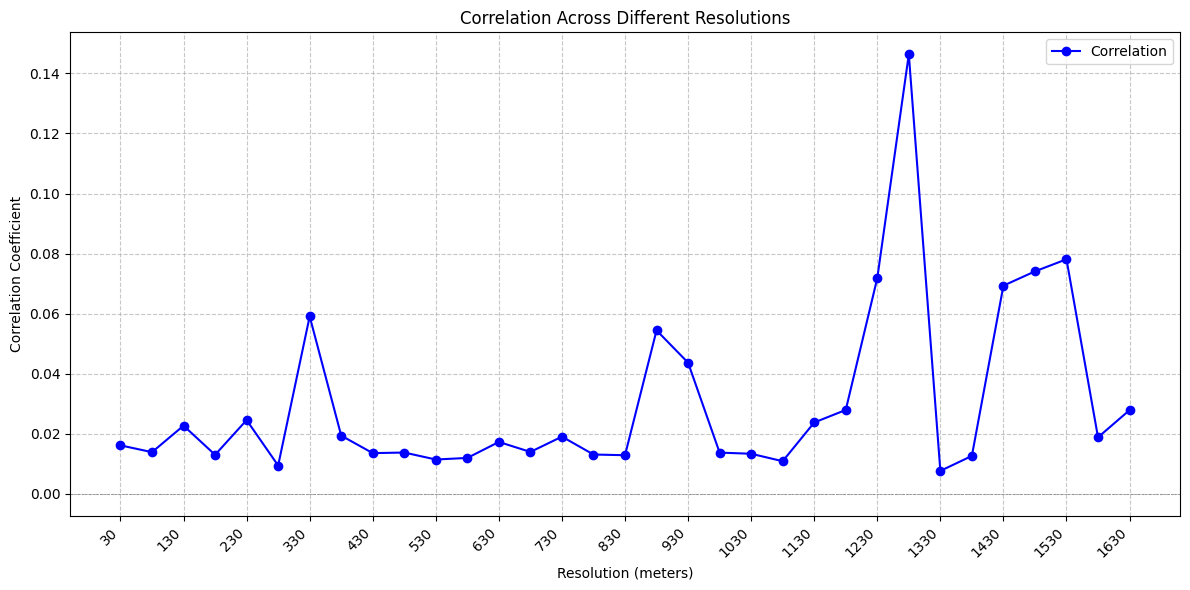

In [ ]:
best_res_greeness_hsp1, max_corr_greeness_hsp1 = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "greeness_hsp1"), ground_df, 32618, "greeness_hsp1")
# 1430
# rf1280


Processing: hunits_popdensity_res30.tif
Feature importance improved: 0.0191

Processing: hunits_popdensity_res130.tif
Feature importance improved: 0.0243

Processing: hunits_popdensity_res780.tif
Feature importance improved: 0.0274

Processing: hunits_popdensity_res880.tif
Feature importance improved: 0.0319

Processing: hunits_popdensity_res930.tif
Feature importance improved: 0.0648

Processing: hunits_popdensity_res1630.tif
Feature importance improved: 0.3244

Best feature importance found:
Resolution: hunits_popdensity_res1630.tif
Feature Importance: 0.3244


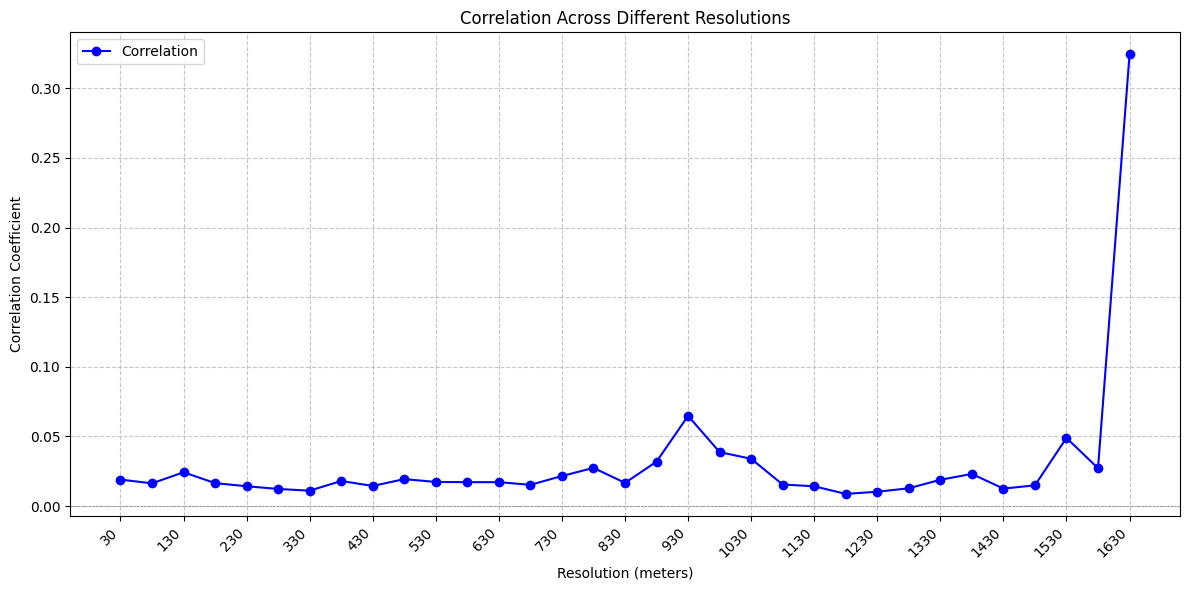

In [ ]:
best_res_hunits_popdensity, max_corr_hunits_popdensity = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "hunits_popdensity"), ground_df, 32618, "hunits_popdensity")
# 1480
# rf1630


Processing: mean_heigh_twopinh_res30.tif
Feature importance improved: 0.0278

Processing: mean_heigh_twopinh_res80.tif
Feature importance improved: 0.0327

Processing: mean_heigh_twopinh_res1330.tif
Feature importance improved: 0.1793

Best feature importance found:
Resolution: mean_heigh_twopinh_res1330.tif
Feature Importance: 0.1793


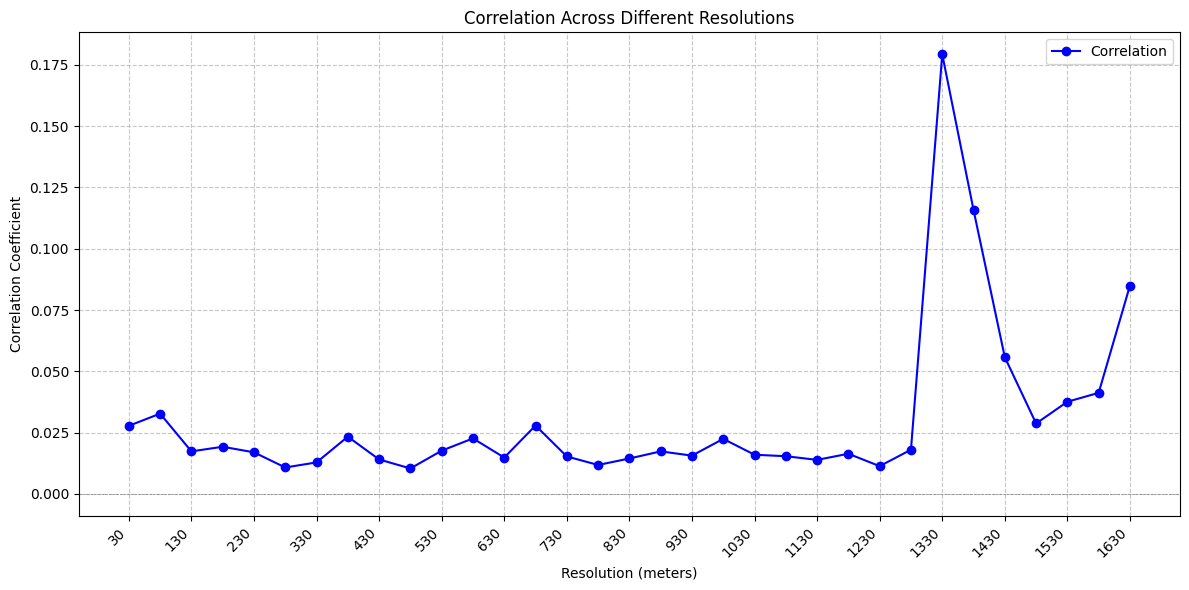

In [ ]:
best_res_mean_heigh_twopinh, max_corr_mean_heigh_twopinh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "mean_heigh_twopinh"), ground_df, 32618, "mean_heigh_twopinh")
# 1280
# rf1330


Processing: mndwi_ndbi_res30.tif
Feature importance improved: 0.0129

Processing: mndwi_ndbi_res80.tif
Feature importance improved: 0.0259

Processing: mndwi_ndbi_res130.tif
Feature importance improved: 0.0903

Best feature importance found:
Resolution: mndwi_ndbi_res130.tif
Feature Importance: 0.0903


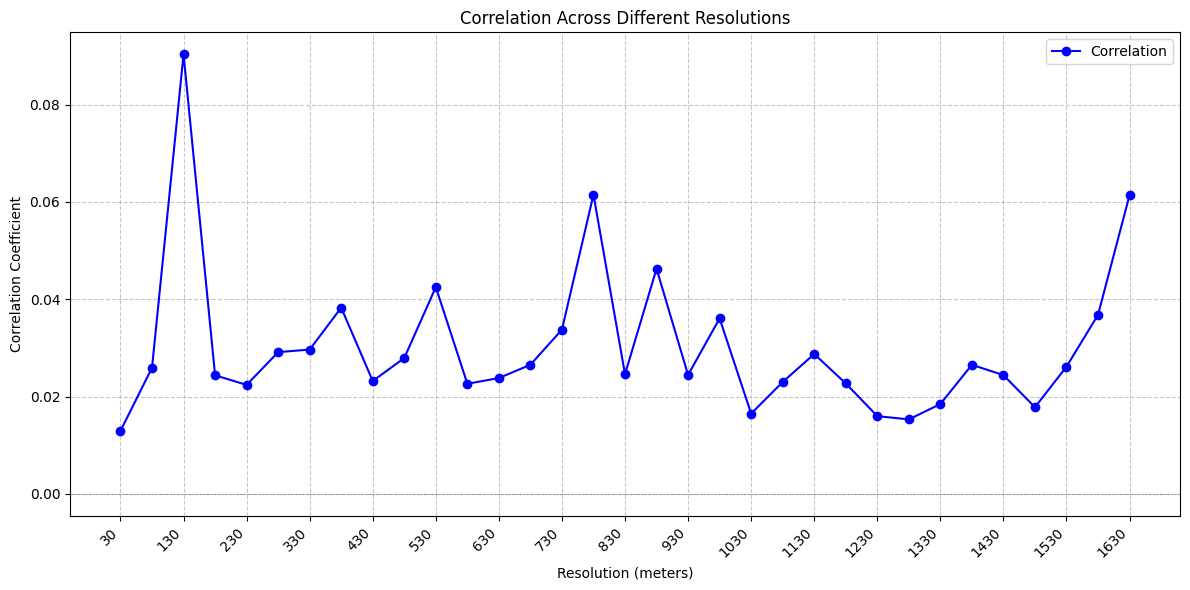

In [ ]:
best_res_mndwi_ndbi, max_corr_mndwi_ndbi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "mndwi_ndbi"), ground_df, 32618, "mndwi_ndbi")
# 30
# rf130


Processing: ndli_ndvi_res30.tif
Feature importance improved: 0.0217

Processing: ndli_ndvi_res130.tif
Feature importance improved: 0.0257

Processing: ndli_ndvi_res730.tif
Feature importance improved: 0.0291

Processing: ndli_ndvi_res880.tif
Feature importance improved: 0.0380

Processing: ndli_ndvi_res1480.tif
Feature importance improved: 0.0821

Processing: ndli_ndvi_res1530.tif
Feature importance improved: 0.1125

Processing: ndli_ndvi_res1630.tif
Feature importance improved: 0.1195

Best feature importance found:
Resolution: ndli_ndvi_res1630.tif
Feature Importance: 0.1195


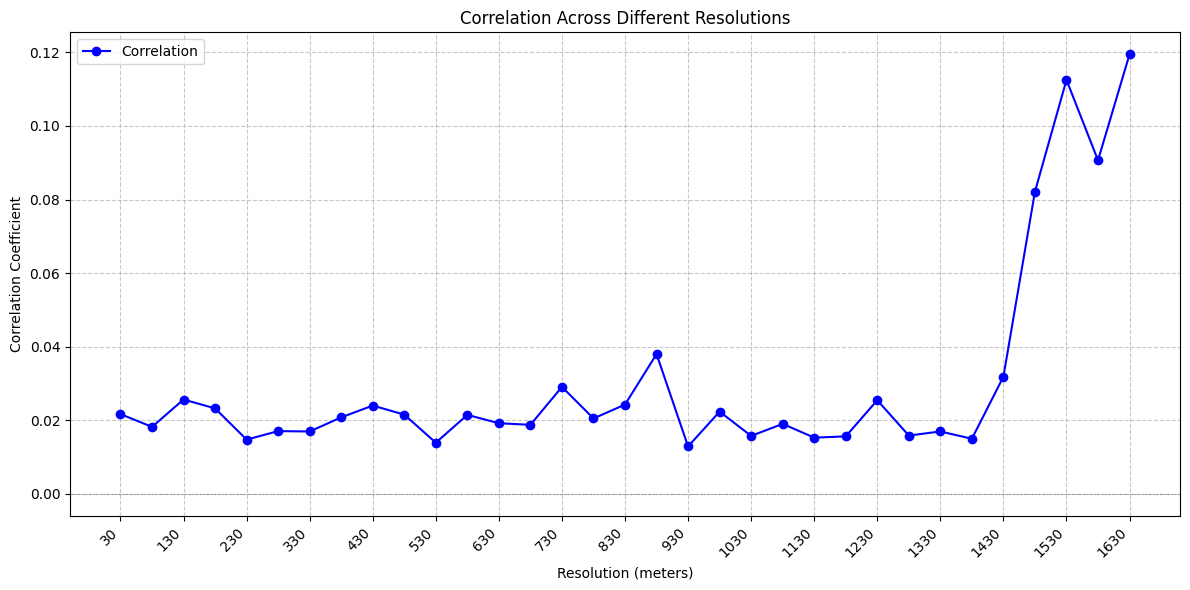

In [ ]:
best_res_ndli_ndvi, max_corr_ndli_ndvi = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "ndli_ndvi"), ground_df, 32618, "ndli_ndvi")
# 1480
# rf1630


Processing: pop65pl_popdensity_res30.tif
Feature importance improved: 0.0167

Processing: pop65pl_popdensity_res80.tif
Feature importance improved: 0.0198

Processing: pop65pl_popdensity_res130.tif
Feature importance improved: 0.0371

Processing: pop65pl_popdensity_res1130.tif
Feature importance improved: 0.0381

Processing: pop65pl_popdensity_res1280.tif
Feature importance improved: 0.0534

Processing: pop65pl_popdensity_res1330.tif
Feature importance improved: 0.0885

Processing: pop65pl_popdensity_res1630.tif
Feature importance improved: 0.1907

Best feature importance found:
Resolution: pop65pl_popdensity_res1630.tif
Feature Importance: 0.1907


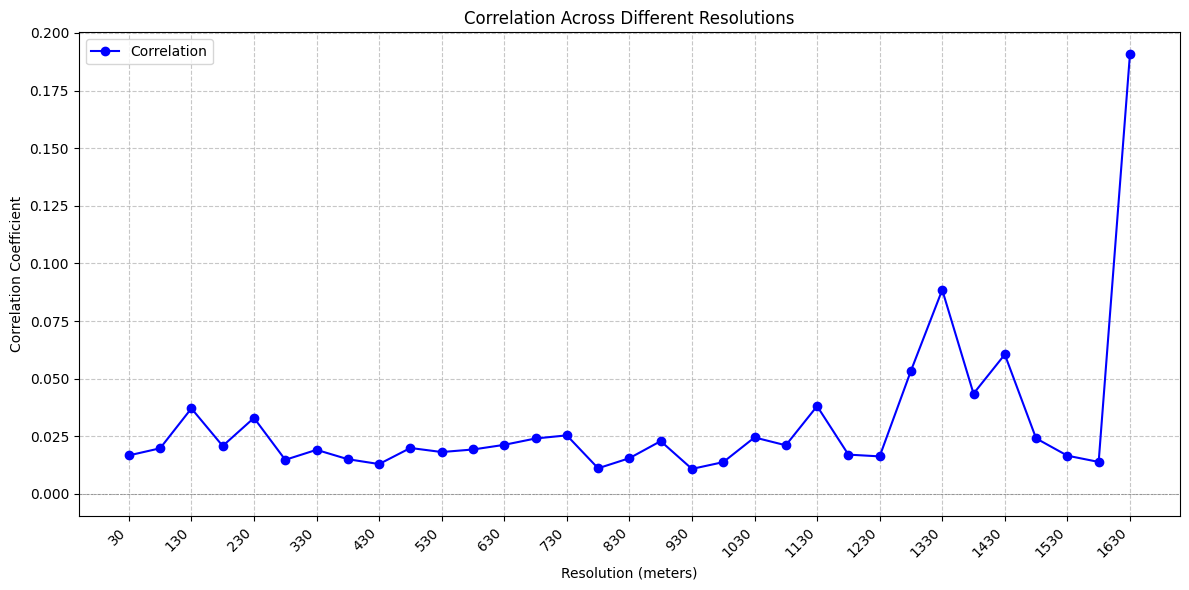

In [ ]:
best_res_pop65pl_popdensity, max_corr_pop65pl_popdensity = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "pop65pl_popdensity"), ground_df, 32618, "pop65pl_popdensity")
# 1280
# rf1630


Processing: popdensity_twopinh_res30.tif
Feature importance improved: 0.0201

Processing: popdensity_twopinh_res180.tif
Feature importance improved: 0.0209

Processing: popdensity_twopinh_res480.tif
Feature importance improved: 0.0211

Processing: popdensity_twopinh_res630.tif
Feature importance improved: 0.0217

Processing: popdensity_twopinh_res980.tif
Feature importance improved: 0.0227

Processing: popdensity_twopinh_res1030.tif
Feature importance improved: 0.0247

Processing: popdensity_twopinh_res1180.tif
Feature importance improved: 0.0946

Processing: popdensity_twopinh_res1230.tif
Feature importance improved: 0.1246

Processing: popdensity_twopinh_res1380.tif
Feature importance improved: 0.1405

Best feature importance found:
Resolution: popdensity_twopinh_res1380.tif
Feature Importance: 0.1405


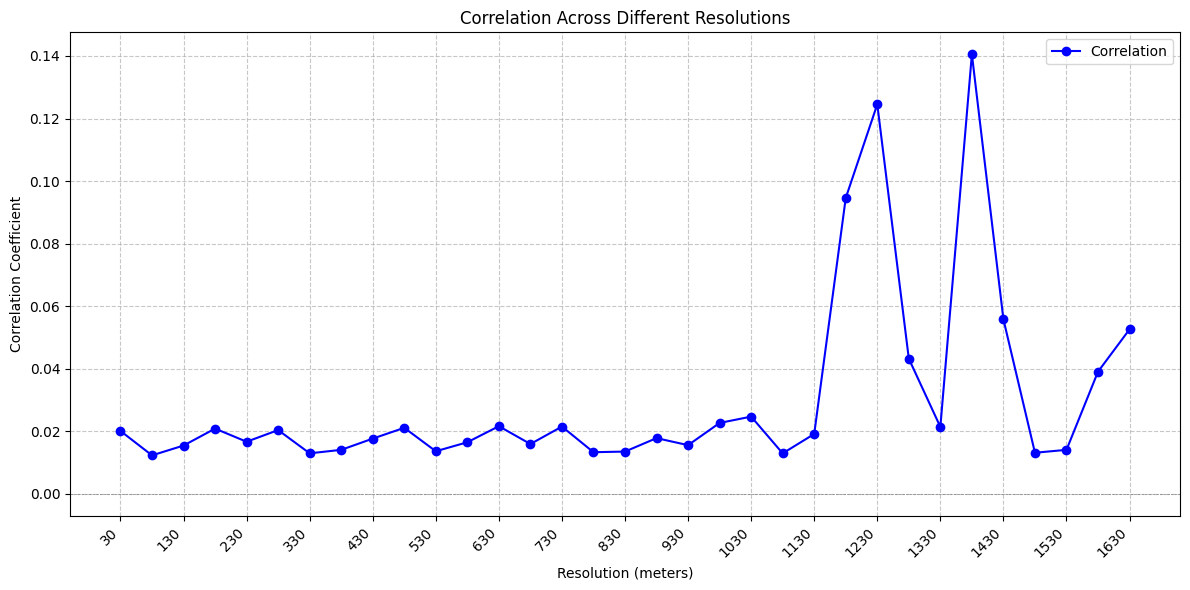

In [ ]:
best_res_popdensity_twopinh, max_corr_popdensity_twopinh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "popdensity_twopinh"), ground_df, 32618, "popdensity_twopinh")
# 1380
# rf1380


Processing: popdensity_wnh_res30.tif
Feature importance improved: 0.0175

Processing: popdensity_wnh_res80.tif
Feature importance improved: 0.0249

Processing: popdensity_wnh_res180.tif
Feature importance improved: 0.0500

Processing: popdensity_wnh_res1130.tif
Feature importance improved: 0.0514

Processing: popdensity_wnh_res1180.tif
Feature importance improved: 0.2531

Best feature importance found:
Resolution: popdensity_wnh_res1180.tif
Feature Importance: 0.2531


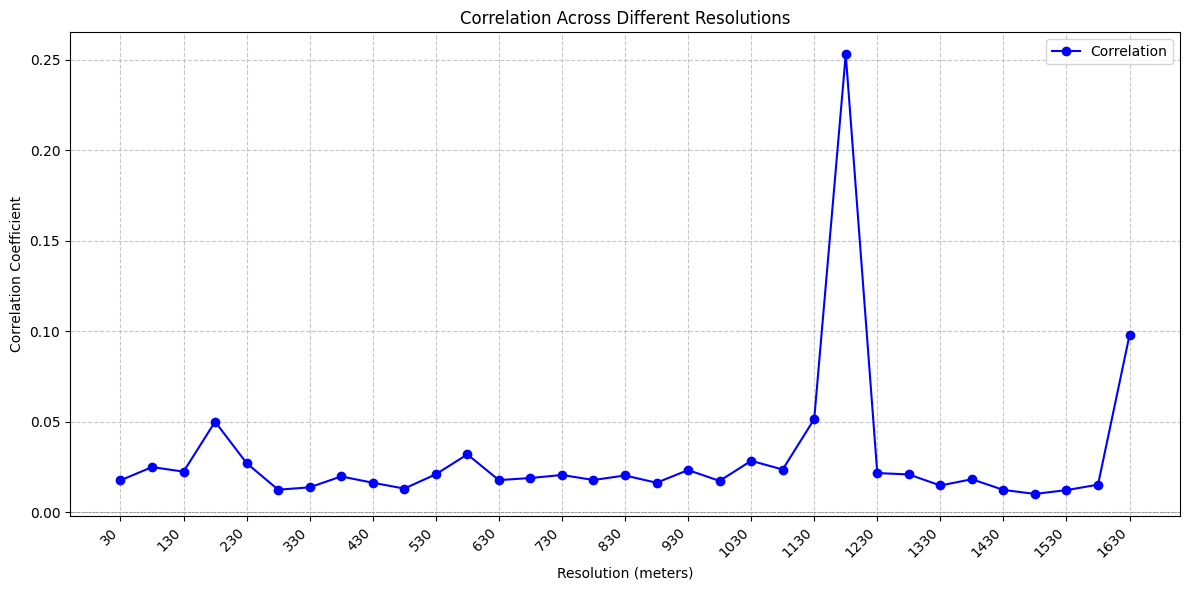

In [ ]:
best_res_popdensity_wnh, max_corr_popdensity_wnh = find_best_resolution_correlation(os.path.join(config.resampled_rasters_path, "popdensity_wnh"), ground_df, 32618, "popdensity_wnh")
# 980
# rf1180

In [2]:
!jupyter nbconvert --to script preprocess.ipynb

[NbConvertApp] Converting notebook preprocess.ipynb to script
[NbConvertApp] Writing 37975 bytes to preprocess.py
